# Car price prediction project (module 5)

## Import

In [192]:
# general packages
import time
from pathlib import Path
import copy
from ordered_set import OrderedSet as OSet
from collections.abc import Sequence
from typing import Callable
from functools import wraps
import re
import multiprocessing
from math import ceil

# tabular data analysis/processing
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas_profiling import ProfileReport

# visualization
%matplotlib inline
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.graph_objects as go

# machine learning
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from category_encoders import BinaryEncoder, LeaveOneOutEncoder
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool

print('Import is completed.')

Import is completed.


## Init setup

In [193]:
# fix random seed
SEED = 37

# visualization flag. Global turn and off time-consumed visualization.
# to iterate different experiments faster when we don't need to visualize everything
# better solution would be to mark some cells from evaluation, but didn't find any good workaround..
VISUALIZE = True

# number of threads for computations
N_THREADS = ceil(0.75 * multiprocessing.cpu_count())

# configure visualization aesthetics
plt.style.use('default')
sb.set_style('dark')

# fix requirements
!pip freeze > requirements.txt

### Constants

In [194]:
# Directories
TRAIN_DIR = 'Parsing/Data'
TEST_DIR = 'Data'
SUB_DIR = 'Data/Submission'

## Functions

In [195]:
def exists(var_name:str):
    """
    Check if a variable with var_name exists in global scope
    """
    return var_name in globals()

def print_framed(text: str, frame_width=100):
    """
    Print text in frame of asterisks ('*')
    """
    text_width = len(text)
    gap = 5
    edge_width = (frame_width - text_width) // 2 - gap
    print('*'*frame_width)
    print('*'*edge_width + ' '*gap + text + ' '*gap + '*'*edge_width)
    print('*'*frame_width)

def correct_name(f_name:str):
    """
    Feature name correction
    """
    new_name = f_name[0].upper()+f_name[1:]
    splitted = new_name.split('_')
    if len(splitted)>1:
        new_name = splitted[0]+splitted[1][0].upper()+splitted[1][1:]
    return new_name

def log_transform(arr: np.ndarray):
    """
    Log transformation of the data in specified numpy array
    """
    return np.log(arr+1)

def inv_log_transform(arr: np.ndarray):
    """
    Inverse log transformation of the data in specified numpy array
    """
    return np.exp(arr)-1

def fillna_mode(df, col):
    """
    Function fills NaN values in column of df with MODE value.
    :param col: Column to replace NaN with mode
    :param df: Dataframe with specified column
    """
    df.fillna({col : df[col].mode().iloc[0]}, inplace=True)

def print_num_col_statistics(col:Series):
    """
    Print statistics for numeric feature
    :param col: Dataframe column with feature values
    :return: None
    """
    print(f'Statistics for {col.name} column:')
    col_stat = col.describe()
    col_stat['Median'] = col.median()
    mode, count = next(col.value_counts(ascending=False).items())
    col_stat['Mode/Count'] = f'{mode}/{count}'
    col_stat['Skewness'] = col.skew()

    q1, q3 = col.quantile([0.25, 0.75])
    IQR = q3 - q1
    n_outliers = sum(~col.between(q1 - 1.5 * IQR, q3 + 1.5 * IQR))

    col_stat['IQR'] = IQR
    col_stat['Number of outliers'] = f'{n_outliers} ({n_outliers / col.shape[0]:.1%})'
    display(col_stat)

# === Visualisation functions ===
def visualisation_check(func):
    """
    Visualising functions decorator
    """
    def func_wrapper(*args, **kwargs):
        wraps(func)
        if VISUALIZE:
            func(*args, **kwargs)
        else:
            print(f'Visualising function {func.__name__}() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).')

    return func_wrapper

@visualisation_check
def vis_analyze_num_col(df:DataFrame,
                        col:str,
                        target:str=None,
                        hist_bins:int=10,
                        hist2d_x_bins:int=None,
                        hist2d_y_bins:int=3,
                        showfliers:bool=True,
                        interactive_hist2d:bool=False,
                        title_add:str=''):
    """
    Visual analysis of numeric feature
    """

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Column '+col+' analysis '+title_add)

    # histogram
    df[col].plot.hist(ax=ax[0], bins=hist_bins)
    # boxplot
    sb.boxplot(data=df, y=col, ax=ax[1], orient='v', showfliers=showfliers, medianprops={'color':'red'}, showmeans=True)
    plt.show()

    # plots with target if any
    if target:
        if not interactive_hist2d:
            # # _, ax = plt.subplots(1,1, figsize=(15,7))
            # joint_plot = sb.jointplot(data=df, x=col, y=target, ax=ax)
            # joint_plot.fig.set_figwidth(15)
            # plt.show()

            plt.rcParams["figure.autolayout"] = False

            if not hist2d_x_bins: hist2d_x_bins = hist_bins
            jp = sb.jointplot(data=df, x=col, y=target, kind='hist', bins=(hist2d_x_bins,hist2d_y_bins), color='blue')
            jp.fig.set_figwidth(15,5)
            # jp.ax_joint.cla()
            plt.sca(jp.ax_joint)
            fig, ax = plt.gcf(), plt.gca()

            x_l, x_r = jp.ax_joint.get_xlim()
            y_b, y_u = jp.ax_joint.get_ylim()

            _,_,_,img = plt.hist2d(data=df, x=col, y=target, cmap='YlOrRd', bins=(hist2d_x_bins,hist2d_y_bins))

            plt.xlim([x_l, x_r])
            plt.ylim([y_b, y_u])

            plt.scatter(data=df, x=col, y=target, s=7, c='blue', alpha=0.5)

            # plot bins median line
            df_bins = df[[col, target]].copy()
            df_bins['Bins'] = pd.cut(x=df_bins[col], bins=hist2d_x_bins)
            bin_medians = df_bins.groupby('Bins').median()[target]
            bin_medians.index = map(lambda i: (i.left + i.right)/2,bin_medians.index)
            bin_medians.plot(style='-s', color='green', ms=5)

            plt.legend(labels=[target, target +' bin median'], bbox_to_anchor=(1.02,1.1), loc="lower left", ncol=2)

            cbar_ax = fig.add_axes([1, 0.1, .03, .7])
            plt.colorbar(mappable=img, cax=cbar_ax)
            plt.show()

            plt.rcParams["figure.autolayout"] = True

        else:
            # 2d hist with scatter chart
            fig_2 = go.Figure()

            fig_2.add_trace(go.Scatter(
                x=df[col],
                y=df[target],
                mode='markers',
                showlegend=False,
                marker=dict(
                    symbol='circle',
                    opacity=0.5,
                    color='blue',
                    size=3,
                    # line=dict(width=1),
                )
            ))
            fig_2.add_trace(go.Histogram2d(
                x=df[col],
                y=df[target],
                colorscale='YlOrRd',
                # zmax=10,
                nbinsx=hist2d_x_bins,
                nbinsy=hist2d_y_bins,
                # zauto=False,
            ))

            fig_2.update_layout(
                xaxis=dict( ticks='', showgrid=False, zeroline=False, nticks=30 ),
                yaxis=dict( ticks='', showgrid=False, zeroline=False, nticks=30 ),
                autosize=False,
                height=500,
                width=1000,
                hovermode='closest'
            )

            fig_2.show()
    else: # no target defined - show point plot for num col
        plt.figure(figsize=(15,7))
        df[col].sort_values().reset_index(drop=True).plot(style='.', ms=5)
        df[col].hist(orientation='horizontal', bins=hist_bins, alpha=0.5)
        plt.show()

@visualisation_check
def analyze_num_col(df:DataFrame ,
                    col:str,
                    target:str=None,
                    hist_bins:int=10,
                    hist2d_x_bins:int=100,
                    hist2d_y_bins:int=3,
                    showfliers:bool=True,
                    need_log:bool = False,
                    interactive_hist2d:bool=False,):
    """
    Analyze numeric column with visualization

    param: df: DataFrame with column to analyze
    param: col: Name of the numeric column to analyze
    param: target: Name of the target column in the DataFrame
    """

    vis_analyze_num_col(df, col, target, hist_bins, hist2d_x_bins, hist2d_y_bins,
                        showfliers=showfliers,
                        interactive_hist2d=interactive_hist2d)
    print_num_col_statistics(df[col])

    to_corr_analysis = [df[col]]

    if need_log:
        print()
        print(f'Column {col} log transform analysis:')
        col_log = col+'_log'
        df_log = pd.DataFrame()
        df_log[col_log] = df[col].apply(log_transform)
        # df_log = pd.DataFrame(col_log_data)
        df_log[col]  = df[col]
        if target:
            df_log[target]  = df[target]

        vis_analyze_num_col(df_log, col_log, target, hist_bins, hist2d_x_bins, hist2d_y_bins,
                            showfliers=showfliers,
                            interactive_hist2d=interactive_hist2d,
                            title_add='(Log transformed)')
        print_num_col_statistics(df_log[col_log])

        to_corr_analysis.append(df_log[col_log])

    if target:
        to_corr_analysis.append(df[target])

    # display corr analysis
    display(pd.concat(to_corr_analysis, axis=1).corr())

@visualisation_check
def show_boxplot(df:DataFrame, qual_col:str, y_col:str, showfliers=True, ordering=None):
    """
    Show boxplots for qualitative value in specified column

    :param df: DataFrame
    :param qual_col: Column with qualitative values
    :param y_col: y variable for boxplot
    :param showfliers: parameter for show/hide outliers
    :param ordering: Flag of boxplots ordering (by median)
    """

    n_unique = df[qual_col].nunique()
    fig, ax = plt.subplots(figsize = (n_unique, 10))

    order = None
    if ordering:
        ordered = df.loc[:,[qual_col, y_col]].groupby([qual_col]).median().sort_values(ascending=False,by=y_col)
        order = ordered.index

    sb.boxplot(x=qual_col, y=y_col, data=df, ax=ax, showfliers=showfliers, medianprops={'color':'red'}, showmeans=True, order=order)

    ax.set_title(f'Boxplot for {qual_col}')
    plt.xticks(fontsize=20, rotation=90)
    plt.yticks(fontsize=20)
    ax.xaxis.label.set_size(30)
    ax.yaxis.label.set_size(30)

    plt.show()

@visualisation_check
def show_countplot(df:DataFrame, qual_col:str, vals=None, ordering=None):
    """
    Show countplot for qualitative value in specified column

    :param df: DataFrame
    :param qual_col: Column with qualitative values
    :param ordering: Flag of boxplots ordering (by median)
    """

    data_to_plot = df[df[qual_col].isin(vals)][qual_col] if vals else df[qual_col]

    n_unique = data_to_plot.nunique()
    fig, ax = plt.subplots(figsize = (n_unique, 10))

    order = None
    if ordering:
        ordered = data_to_plot.value_counts(ascending=False)
        order = ordered.index

    sb.countplot(x=data_to_plot, order=order)

    ax.set_title(f'Countplot for {qual_col}')
    plt.xticks(fontsize=20, rotation=90)
    plt.yticks(fontsize=20)
    ax.xaxis.label.set_size(30)
    ax.yaxis.label.set_size(30)

    plt.show()

def mape(y_pred: np.ndarray, y_true: np.ndarray):
    """
    Calculate the mean absolute percentage error (MAPE).
    """
    return np.mean(np.abs((y_pred-y_true)/y_true))

def gridsearch_for_submission(model, fit_func:str, predict_func:str, X_train, y_train, X_sub, coef_grid:np.ndarray,
                              n_target_features:int=0, y_transform_func:Callable=None, y_inv_transform_func:Callable=None) -> list:
    """
    Train model on specified and predict target for values of target correction coefficient defined as a grid
    :param model: Model to train
    :param fit_func: Name of fit function of the model
    :param predict_func: Name of predict function of the model
    :param X_train: X for train (as a rule should be all available train data)
    :param y_train: y for train
    :param X_sub: X valus to predict submission target
    :param coef_grid: Grid of the target correction coefficients
    :param n_target_features: Number of target features (e.g. LeaveOneOut) at the end of X
    :param y_transform_func: Function for target transformation
    :param y_inv_transform_func: Function for inverse target transformation
    :return: list of predicted y values for X_sub for every coefficient in grid
    """

    need_transform = True if y_transform_func or y_inv_transform_func else False

    fit_f = getattr(model, fit_func)
    predict_f = getattr(model, predict_func)

    results = []
    for coef in coef_grid:
        y_cur = coef*y_train
        if n_target_features:
            X_train_cur = np.hstack((X_train[:,:-n_target_features], coef*X_train[:,-n_target_features:]))
            X_sub_cur = np.hstack((X_sub[:,:-n_target_features], coef*X_sub[:,-n_target_features:]))
        else:
            X_train_cur = X_train
            X_sub_cur = X_sub

        if need_transform:
            if n_target_features:
                X_train_cur = np.hstack((X_train_cur[:,:-n_target_features], y_transform_func(X_train_cur[:,-n_target_features:])))
                X_sub_cur = np.hstack((X_sub_cur[:,:-n_target_features], y_transform_func(X_sub_cur[:,-n_target_features:])))
            y_cur = y_transform_func(y_cur)

        fit_f(X_train_cur, y_cur)
        y_pred_sub = predict_f(X_sub_cur)

        if need_transform:
            y_pred_sub = y_inv_transform_func(y_pred_sub)

        # save current grid search results for submission
        results.append(y_pred_sub)

    return results


## Data loading

Load parsed in [separate notebook](https://github.com/PavelKucherenko/sf-ds50-course/blob/main/module_5/Parsing/Parsing.ipynb) train data and provided test project data for submission.

In [196]:
print_framed('TRAIN DATASET')
if not exists('df_train_orig'): df_train_orig = pd.read_csv(f'{TRAIN_DIR}/parsed_car_data_all__06_02_2022.csv')
# noinspection PyUnboundLocalVariable
display(df_train_orig.head(5))
df_train_orig.info()
display(df_train_orig.describe())

print_framed('TEST DATASET')
if not exists('df_test_orig'): df_test_orig = pd.read_csv(f'{TEST_DIR}/test.csv')
# noinspection PyUnboundLocalVariable
display(df_test_orig.head(5))
df_test_orig.info()
display(df_test_orig.describe())

****************************************************************************************************
**************************************     TRAIN DATASET     **************************************
****************************************************************************************************


№ bodyType  brand                                            car_url  \
0  0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
1  1  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
2  2      NaN  SKODA  https://auto.ru/cars/new/group/skoda/karoq/225...   
3  3      NaN  SKODA  https://auto.ru/cars/new/group/skoda/rapid/217...   
4  4  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/rapid/110...   

        color                                 complectation_dict  \
0  коричневый  {'id': '20291328', 'name': 'Laurin&Klement', '...   
1     красный                                        {'id': '0'}   
2       белый  {'id': '22687243', 'name': 'Hockey Edition', '...   
3  коричневый  {'id': '22870340', 'name': 'Hockey Edition', '...   
4      чёрный                                        {'id': '0'}   

                                         description  engineDisplacement  \
0  1 владелец.\r\nРодной пробег.\r\nПТС оригинал....                 1.8   
1  Skoda Octavia\r\n\r\n❕ ПТС ОРИГИНАЛ\r\n❕ ДВА В...                 1.8   
2  В стоимость автомобиля включено дополнительное...                 NaN   
3  ———————————————————————————\r\nФУНКЦИОНАЛЬНОЕ ...                 NaN   
4  ЛОТ: 01306544\r\nЛокация №16\r\nФаворит Моторс...                 1.6   

   enginePower                                     equipment_dict  ...  \
0        180.0  {'cruise-control': True, 'esp': True, 'adaptiv...  ...   
1        150.0  {'condition': True, 'mirrors-heat': True, 'ele...  ...   
2          NaN  {'cruise-control': True, 'asr': True, 'tinted-...  ...   
3          NaN  {'cruise-control': True, 'asr': True, 'tinted-...  ...   
4        110.0  {'cruise-control': True, 'glonass': True, 'asr...  ...   

  vehicleTransmission vendor    Владельцы  Владение       ПТС    Привод  \
0    роботизированная    NaN   1 владелец       NaN  Оригинал  передний   
1        механическая    NaN  2 владельца       NaN  Оригинал  передний   
2                 NaN    NaN          NaN       NaN       NaN       NaN   
3                 NaN    NaN          NaN       NaN       NaN       NaN   
4      автоматическая    NaN   1 владелец       NaN  Оригинал  передний   

    Руль           Состояние     Таможня      Price  
0  Левый  Не требует ремонта  Растаможен  1030000.0  
1  Левый  Не требует ремонта  Растаможен   400000.0  
2    NaN                 NaN         NaN  2655000.0  
3    NaN                 NaN         NaN  1335000.0  
4  Левый  Не требует ремонта  Растаможен  1820000.0  

[5 rows x 34 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42441 entries, 0 to 42440
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   №                     42441 non-null  int64  
 1   bodyType              33328 non-null  object 
 2   brand                 41768 non-null  object 
 3   car_url               42441 non-null  object 
 4   color                 41768 non-null  object 
 5   complectation_dict    38643 non-null  object 
 6   description           41768 non-null  object 
 7   engineDisplacement    32637 non-null  float64
 8   enginePower           32757 non-null  float64
 9   equipment_dict        41685 non-null  object 
 10  fuelType              32757 non-null  object 
 11  image                 30738 non-null  object 
 12  mileage               33328 non-null  float64
 13  modelDate             40194 non-null  float64
 14  model_info            41685 non-null  object 
 15  model_name         

№  engineDisplacement   enginePower       mileage  \
count  42441.000000        32637.000000  32757.000000  3.332800e+04   
mean   21084.445701            2.381457    193.728547  1.306305e+05   
std    12251.038731            0.970799     88.229736  9.348202e+04   
min        0.000000            0.700000     45.000000  1.000000e+03   
25%    10474.000000            1.800000    136.000000  6.000000e+04   
50%    21084.000000            2.000000    170.000000  1.160000e+05   
75%    31694.000000            3.000000    240.000000  1.810000e+05   
max    42304.000000            6.600000    900.000000  1.090000e+06   

          modelDate  numberOfDoors  parsing_unixtime  productionDate  sell_id  \
count  40194.000000   41685.000000      4.244100e+04    41768.000000      0.0   
mean    2012.170598       4.651889      1.643820e+09     2014.457695      NaN   
std        6.810206       0.578531      1.852711e+04        6.733014      NaN   
min     1937.000000       2.000000      1.643814e+09     1948.000000      NaN   
25%     2009.000000       4.000000      1.643816e+09     2011.000000      NaN   
50%     2014.000000       5.000000      1.643819e+09     2016.000000      NaN   
75%     2017.000000       5.000000      1.643821e+09     2020.000000      NaN   
max     2021.000000       5.000000      1.644143e+09     2022.000000      NaN   

       vehicleConfiguration  vendor         Price  
count                   0.0     0.0  3.779000e+04  
mean                    NaN     NaN  2.788796e+06  
std                     NaN     NaN  2.904376e+06  
min                     NaN     NaN  4.000000e+04  
25%                     NaN     NaN  1.090000e+06  
50%                     NaN     NaN  1.930000e+06  
75%                     NaN     NaN  3.460000e+06  
max                     NaN     NaN  1.111000e+08

****************************************************************************************************
***************************************     TEST DATASET     ***************************************
****************************************************************************************************


bodyType  brand                                            car_url  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
1  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
2  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/superb/11...   
3  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
4  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   

        color                                 complectation_dict  \
0       синий                                                NaN   
1      чёрный                                                NaN   
2       серый  {"id":"20026336","name":"Ambition","available_...   
3  коричневый  {"id":"20803582","name":"Ambition","available_...   
4       белый                                                NaN   

                                         description engineDisplacement  \
0  Все автомобили, представленные в продаже, прох...            1.2 LTR   
1  ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...            1.6 LTR   
2  Все автомобили, представленные в продаже, прох...            1.8 LTR   
3  КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...            1.6 LTR   
4  ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...            1.8 LTR   

  enginePower                                     equipment_dict fuelType  \
0     105 N12  {"engine-proof":true,"tinted-glass":true,"airb...   бензин   
1     110 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   
2     152 N12  {"cruise-control":true,"tinted-glass":true,"es...   бензин   
3     110 N12  {"cruise-control":true,"roller-blind-for-rear-...   бензин   
4     152 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   

   ...     vehicleConfiguration  vehicleTransmission    vendor    Владельцы  \
0  ...       LIFTBACK ROBOT 1.2     роботизированная  EUROPEAN  3 или более   
1  ...  LIFTBACK MECHANICAL 1.6         механическая  EUROPEAN   1 владелец   
2  ...       LIFTBACK ROBOT 1.8     роботизированная  EUROPEAN   1 владелец   
3  ...   LIFTBACK AUTOMATIC 1.6       автоматическая  EUROPEAN   1 владелец   
4  ...   LIFTBACK AUTOMATIC 1.8       автоматическая  EUROPEAN   1 владелец   

  Владение       ПТС    Привод   Руль           Состояние     Таможня  
0      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
1      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
2      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
3      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
4      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  

[5 rows x 32 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

mileage     modelDate  numberOfDoors  parsing_unixtime  \
count    34686.000000  34686.000000   34686.000000      3.468600e+04   
mean    162009.767889   2007.074728       4.450816      1.603287e+09   
std     100676.559489      7.415894       0.703040      1.493071e+05   
min          1.000000   1904.000000       0.000000      1.603107e+09   
25%      91153.500000   2004.000000       4.000000      1.603221e+09   
50%     149779.500000   2008.000000       5.000000      1.603254e+09   
75%     215000.000000   2012.000000       5.000000      1.603290e+09   
max    1000000.000000   2020.000000       5.000000      1.603710e+09   

       productionDate       sell_id  
count    34686.000000  3.468600e+04  
mean      2009.264602  1.098300e+09  
std          7.047661  1.911225e+07  
min       1904.000000  2.665000e+03  
25%       2006.000000  1.099049e+09  
50%       2011.000000  1.100911e+09  
75%       2014.000000  1.101245e+09  
max       2020.000000  1.101375e+09

So, after parse stage we have all necessary columns in train set to predict car price based on test data. But let's look at those data more thoroughly.

## Preliminary data analysis and preprocessing

In [197]:
# create work copy of datasets
df_train = df_train_orig.copy()
df_test = df_test_orig.copy()

In [198]:
# and their combined dict
# (without merging them into one dataframe to avoid data leakage in analysis)
dfs = {'train':df_train, 'test':df_test}

Now we have working copy of our dataset and a combined list.
NB! For all common actions to be done on BOTH datasets we'll use this dict. *Was searching for best practice here and settled on this decision

### Data cleaning

There are some unuseful columns in both datasets. Let's analyze them and maybe delete.

In [199]:
# run profiling on both sets
# ProfileReport(df_train).to_file(output_file='Reports/train_profiling.html')
# ProfileReport(df_test).to_file(output_file='Reports/test_profiling.html')

Analyzing pandas profiling results and other statistics, there are following columns that can be deleted from both datasets:

'car_url'               - potentially we could get some additional info from car page but for this case we don't need this "overhead"

'complectation_dict'    - 81.5% missing in test - too many

'equipment_dict'        - 28.8%  missing in test. Theoretically we could take from test set records without this missings and predict via specific model, which was trained                             with this feature (there are only 1.8% missing values in train), but for this study case let's delete this column due to large amount of missing values anyway

'image'                 - don't go with CV for now, so don't need this column

'model_info'            - have potentially useful information from here in other columns

'name'                  - have this information in other columns

'priceCurrency'         - rubles everywhere (in test and in train)

'sell_id'               - not useful

'vehicleConfiguration'  - have this information in other columns

'Владение'              - 65.4% misssing in test

'Состояние'             - single-valued column in test and in train

'Таможня'               - single-valued column in test and in train


In [200]:
# as a result - cols to be deleted from both sets:
cols_to_del = [   'car_url',
                  'complectation_dict',
                  'equipment_dict',
                  'image',
                  'model_info',
                  'name',
                  'priceCurrency',
                  'sell_id',
                  'vehicleConfiguration',
                  'Владение',
                  'Состояние',
                  'Таможня']

# delete them
for df in dfs.values():
    df.drop(columns=cols_to_del, inplace=True)
    df.info()

# also delete 'number' column from train
df_train.drop(columns='№', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42441 entries, 0 to 42440
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   №                    42441 non-null  int64  
 1   bodyType             33328 non-null  object 
 2   brand                41768 non-null  object 
 3   color                41768 non-null  object 
 4   description          41768 non-null  object 
 5   engineDisplacement   32637 non-null  float64
 6   enginePower          32757 non-null  float64
 7   fuelType             32757 non-null  object 
 8   mileage              33328 non-null  float64
 9   modelDate            40194 non-null  float64
 10  model_name           41685 non-null  object 
 11  numberOfDoors        41685 non-null  float64
 12  parsing_unixtime     42441 non-null  int64  
 13  productionDate       41768 non-null  float64
 14  super_gen            41685 non-null  object 
 15  vehicleTransmission  33328 non-null 

In [201]:
# and check if the columns are equal and with same order (without last target 'Price' in train)
list(df_train.columns[:-1]) == list(df_test.columns)

True

Ok, we have same features in train and in test.

We also have some missing values 'bodyType' in train set, let's deal with them.

In [202]:
df_train[df_train['bodyType'].isna()].shape

(9113, 21)

In [203]:
df_train[df_train['bodyType'].isna()]

bodyType       brand       color  \
2          NaN       SKODA       белый   
3          NaN       SKODA  коричневый   
9          NaN       SKODA       синий   
18         NaN       SKODA       синий   
19         NaN       SKODA  коричневый   
...        ...         ...         ...   
42300      NaN  MITSUBISHI       белый   
42302      NaN  MITSUBISHI       белый   
42318      NaN         NaN         NaN   
42377      NaN         NaN         NaN   
42401      NaN         NaN         NaN   

                                             description  engineDisplacement  \
2      В стоимость автомобиля включено дополнительное...                 NaN   
3      ———————————————————————————\r\nФУНКЦИОНАЛЬНОЕ ...                 NaN   
9      ———————————————————————————\r\nФУНКЦИОНАЛЬНОЕ ...                 NaN   
18     В стоимость автомобиля включено дополнительное...                 NaN   
19     В стоимость автомобиля включено дополнительное...                 NaN   
...                                                  ...                 ...   
42300  В честь 30-летия бренда Mitsubishi в России ст...                 NaN   
42302  Специальные условия на покупку Mitsubishi ASX ...                 NaN   
42318                                                NaN                 NaN   
42377                                                NaN                 NaN   
42401                                                NaN                 NaN   

       enginePower fuelType  mileage  modelDate model_name  ...  \
2              NaN      NaN      NaN     2017.0      KAROQ  ...   
3              NaN      NaN      NaN     2020.0      RAPID  ...   
9              NaN      NaN      NaN        NaN      RAPID  ...   
18             NaN      NaN      NaN     2020.0      RAPID  ...   
19             NaN      NaN      NaN     2020.0      RAPID  ...   
...            ...      ...      ...        ...        ...  ...   
42300          NaN      NaN      NaN     2020.0        ASX  ...   
42302          NaN      NaN      NaN     2020.0        ASX  ...   
42318          NaN      NaN      NaN        NaN        NaN  ...   
42377          NaN      NaN      NaN        NaN        NaN  ...   
42401          NaN      NaN      NaN        NaN        NaN  ...   

       parsing_unixtime  productionDate  \
2            1643813748          2022.0   
3            1643813747          2022.0   
9            1643813747          2022.0   
18           1643813748          2022.0   
19           1643813748          2022.0   
...                 ...             ...   
42300        1643823712          2021.0   
42302        1643823712          2021.0   
42318        1644142619             NaN   
42377        1644142632             NaN   
42401        1644142642             NaN   

                                               super_gen vehicleTransmission  \
2      {'gear_type': 'FORWARD_CONTROL', 'engine_type'...                 NaN   
3      {'gear_type': 'FORWARD_CONTROL', 'engine_type'...                 NaN   
9      {'gear_type': 'FORWARD_CONTROL', 'engine_type'...                 NaN   
18     {'gear_type': 'FORWARD_CONTROL', 'engine_type'...                 NaN   
19     {'gear_type': 'FORWARD_CONTROL', 'engine_type'...                 NaN   
...                                                  ...                 ...   
42300  {'gear_type': 'ALL_WHEEL_DRIVE', 'engine_type'...                 NaN   
42302  {'gear_type': 'FORWARD_CONTROL', 'engine_type'...                 NaN   
42318                                                NaN                 NaN   
42377                                                NaN                 NaN   
42401                                                NaN                 NaN   

      vendor  Владельцы  ПТС Привод Руль      Price  
2        NaN        NaN  NaN    NaN  NaN  2655000.0  
3        NaN        NaN  NaN    NaN  NaN  1335000.0  
9        NaN        NaN  NaN    NaN  NaN        NaN  
18       NaN        NaN  NaN    NaN  NaN 

In [204]:
no_bodyType_mask = df_train['bodyType'].isna()
print(sum(no_bodyType_mask ^ df_train[no_bodyType_mask]['fuelType'].isna()))
print(sum(no_bodyType_mask ^ df_train[no_bodyType_mask]['mileage'].isna()))
print(sum(no_bodyType_mask ^ df_train[no_bodyType_mask]['vehicleTransmission'].isna()))

0
0
0


Exactly these rows have a lot of missing values in other important columns - unfortunately not useful. Delete these rows.

In [205]:
df_train.drop(labels=df_train[df_train['bodyType'].isna()].index, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33328 entries, 0 to 33327
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             33328 non-null  object 
 1   brand                33328 non-null  object 
 2   color                33328 non-null  object 
 3   description          33328 non-null  object 
 4   engineDisplacement   32637 non-null  float64
 5   enginePower          32757 non-null  float64
 6   fuelType             32757 non-null  object 
 7   mileage              33328 non-null  float64
 8   modelDate            32858 non-null  float64
 9   model_name           33328 non-null  object 
 10  numberOfDoors        33328 non-null  float64
 11  parsing_unixtime     33328 non-null  int64  
 12  productionDate       33328 non-null  float64
 13  super_gen            33328 non-null  object 
 14  vehicleTransmission  33328 non-null  object 
 15  vendor               0 non-null     

Now check and delete missing price rows in train set.

In [206]:
df_train[df_train['Price'].isna()].shape

(2770, 21)

In [207]:
df_train.drop(labels=df_train[df_train['Price'].isna()].index, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30558 entries, 0 to 30557
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             30558 non-null  object 
 1   brand                30558 non-null  object 
 2   color                30558 non-null  object 
 3   description          30558 non-null  object 
 4   engineDisplacement   30347 non-null  float64
 5   enginePower          30466 non-null  float64
 6   fuelType             30466 non-null  object 
 7   mileage              30558 non-null  float64
 8   modelDate            30558 non-null  float64
 9   model_name           30558 non-null  object 
 10  numberOfDoors        30558 non-null  float64
 11  parsing_unixtime     30558 non-null  int64  
 12  productionDate       30558 non-null  float64
 13  super_gen            30558 non-null  object 
 14  vehicleTransmission  30558 non-null  object 
 15  vendor               0 non-null     

Also we have !equal amount! of missing values in 'enginePower' and 'fuelType' cols of train set. Let's see what are they.

In [208]:
print(df_train[df_train['enginePower'].isna()].shape)
print(df_train[df_train['fuelType'].isna()].shape)

(92, 21)
(92, 21)


In [209]:
# not so much. Check if they are the same rows
sum(df_train['enginePower'].isna() ^ df_train['fuelType'].isna())

0

In [210]:
# yes, they are the same rows - delete them due to their small number anyhow
df_train.drop(labels=df_train[df_train['enginePower'].isna()].index, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_train.shape

(30466, 21)

### Check and process duplicates

In [211]:
sum(df_train.duplicated())

39

In [212]:
# what are they..?
df_train[df_train.duplicated(keep=False)]

bodyType       brand       color  \
746              лифтбек       SKODA       белый   
755              лифтбек       SKODA       белый   
906              лифтбек       SKODA       белый   
921              лифтбек       SKODA       белый   
1432             лифтбек       SKODA       белый   
...                  ...         ...         ...   
26886              седан  VOLKSWAGEN       белый   
29187  внедорожник 5 дв.  MITSUBISHI      чёрный   
29191  внедорожник 5 дв.  MITSUBISHI      чёрный   
29890  внедорожник 5 дв.  MITSUBISHI  коричневый   
29900  внедорожник 5 дв.  MITSUBISHI  коричневый   

                                             description  engineDisplacement  \
746    ...\r\nУникальное предложение на автомобили с ...                 1.0   
755    ...\r\nУникальное предложение на автомобили с ...                 1.0   
906    АВТОВЕК, являясь официальным дилером LADA, пре...                 1.8   
921    АВТОВЕК, являясь официальным дилером LADA, пре...                 1.8   
1432   ✅ ПТС оригинал\r\n\r\n✅Хорошее техническое сос...                 1.6   
...                                                  ...                 ...   
26886  Volkswagen Passat 2012г.в.  нaxодитcя по адреc...                 1.4   
29187  Безопасность: 11. Обзор: 4. Комфорт: 15. Элеме...                 2.4   
29191  Безопасность: 11. Обзор: 4. Комфорт: 15. Элеме...                 2.4   
29890  Автомобиль в отличном состоянии. Бережная эксп...                 1.6   
29900  Автомобиль в отличном состоянии. Бережная эксп...                 1.6   

       enginePower fuelType   mileage  modelDate    model_name  ...  \
746          110.0   Бензин   39000.0     2017.0         RAPID  ...   
755          110.0   Бензин   39000.0     2017.0         RAPID  ...   
906          180.0   Бензин   61000.0     2017.0       OCTAVIA  ...   
921          180.0   Бензин   61000.0     2017.0       OCTAVIA  ...   
1432          90.0   Бензин   64000.0     2017.0         RAPID  ...   
...            ...      ...       ...        ...           ...  ...   
26886        122.0   Бензин  151000.0     2011.0        PASSAT  ...   
29187        181.0   Дизель   31000.0     2015.0  PAJERO_SPORT  ...   
29191        181.0   Дизель   31000.0     2015.0  PAJERO_SPORT  ...   
29890        117.0   Бензин  180000.0     2010.0           ASX  ...   
29900        117.0   Бензин  180000.0     2010.0           ASX  ...   

       parsing_unixtime  productionDate  \
746          1643814001          2019.0   
755          1643814001          2019.0   
906          1643814054          2018.0   
921          1643814054          2018.0   
1432         1643814235          2017.0   
...                 ...             ...   
26886        1643822550          2012.0   
29187        1643823314          2018.0   
29191        1643823314          2018.0   
29890        1643823556          2011.0   
29900        1643823556          2011.0   

                                               super_gen vehicleTransmission  \
746    {'gear_type': 'FORWARD_CONTROL', 'engine_type'...        механическая   
755    {'gear_type': 'FORWARD_CONTROL', 'engine_type'...        механическая   
906    {'gear_type': 'FORWARD_CONTROL', 'engine_type'...    роботизированная   
921    {'gear_type': 'FORWARD_CONTROL', 'engine_type'...    роботизированная   
1432   {'gear_type': 'FORWARD_CONTROL', 'engine_type'...        механическая   
...                                                  ...                 ...   
26886  {'gear_type': 'FORWARD_CONTROL', 'engine_type'...    роботизированная   
29187  {'gear_type': 'ALL_WHEEL_DRIVE', 'engine_type'...      автоматическая   
29191  {'gear_type': 'ALL_WHEEL_DRIVE', 'engine_type'...      автоматическая   
29890  {'gear_type': 'FORWARD_CONTROL', 'engine_type'...        механическая   
29900  {'gear_type': 'FORWARD_CONTROL', 'engine_type'...        механическая   

      vendor    Владельцы       ПТС    Привод   Руль      Price  
746      NaN  2 владельца  Оригин

In [213]:
# delete duplicates
df_train.drop_duplicates(inplace=True)
df_train.shape

(30427, 21)

In [214]:
sum(df_test.duplicated())

0

We have no duplicates in test set.

In [215]:
print_framed('TRAIN SET')
df_train.info()

print_framed('TEST SET')
df_test.info()

****************************************************************************************************
****************************************     TRAIN SET     ****************************************
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30427 entries, 0 to 30465
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             30427 non-null  object 
 1   brand                30427 non-null  object 
 2   color                30427 non-null  object 
 3   description          30427 non-null  object 
 4   engineDisplacement   30308 non-null  float64
 5   enginePower          30427 non-null  float64
 6   fuelType             30427 non-null  object 
 7   mileage              30427 non-null  float64
 8   modelDate            30427 non-null  float64
 9   model_name           30427 non-nul

So, we have 20 features with 30_427 rows in train (with little missings only in 'engineDisplacement' (electro cars)) and 34_686 in test.

Although the size of cleaned train set is not so large it is although not so small, and for future models in this study project we decide to use our own parsed train data.

## EDA

In [216]:
# rename features for more convenience
rename_dict = {fn:correct_name(fn) for fn in df_train.columns}
rename_dict.update({'Владельцы':'Owners', 'ПТС':'PTS','Привод':'Drive', 'Руль':'Wheel'})

for df in dfs.values():
    df.rename(columns=rename_dict, inplace=True)
    display(df.head())

BodyType  Brand       Color  \
0          лифтбек  SKODA  коричневый   
1          лифтбек  SKODA     красный   
2          лифтбек  SKODA      чёрный   
3          лифтбек  SKODA       белый   
4  универсал 5 дв.  SKODA       серый   

                                         Description  EngineDisplacement  \
0  1 владелец.\r\nРодной пробег.\r\nПТС оригинал....                 1.8   
1  Skoda Octavia\r\n\r\n❕ ПТС ОРИГИНАЛ\r\n❕ ДВА В...                 1.8   
2  ЛОТ: 01306544\r\nЛокация №16\r\nФаворит Моторс...                 1.6   
3  Автомобиль продается от дилерского центра РРТ ...                 1.4   
4  Автомобиль представлен официальным дилером GEE...                 1.8   

   EnginePower FuelType   Mileage  ModelDate ModelName  ...  ParsingUnixtime  \
0        180.0   Бензин   98000.0     2013.0   OCTAVIA  ...       1643813748   
1        150.0   Бензин  239000.0     2000.0   OCTAVIA  ...       1643813748   
2        110.0   Бензин    2000.0     2020.0     RAPID  ...       1643813747   
3        122.0   Бензин  156000.0     2012.0     RAPID  ...       1643813748   
4        180.0   Бензин   50000.0     2013.0   OCTAVIA  ...       1643813749   

   ProductionDate                                           SuperGen  \
0          2014.0  {'gear_type': 'FORWARD_CONTROL', 'engine_type'...   
1          2008.0  {'gear_type': 'FORWARD_CONTROL', 'engine_type'...   
2          2020.0  {'gear_type': 'FORWARD_CONTROL', 'engine_type'...   
3          2017.0  {'gear_type': 'FORWARD_CONTROL', 'engine_type'...   
4          2016.0  {'gear_type': 'ALL_WHEEL_DRIVE', 'engine_type'...   

  VehicleTransmission Vendor       Owners       PTS     Drive  Wheel  \
0    роботизированная    NaN   1 владелец  Оригинал  передний  Левый   
1        механическая    NaN  2 владельца  Оригинал  передний  Левый   
2      автоматическая    NaN   1 владелец  Оригинал  передний  Левый   
3    роботизированная    NaN  2 владельца  Оригинал  передний  Левый   
4    роботизированная    NaN   1 владелец  Оригинал    полный  Левый   

       Price  
0  1030000.0  
1   400000.0  
2  1820000.0  
3   730000.0  
4  2250000.0  

[5 rows x 21 columns]

BodyType  Brand       Color  \
0  лифтбек  SKODA       синий   
1  лифтбек  SKODA      чёрный   
2  лифтбек  SKODA       серый   
3  лифтбек  SKODA  коричневый   
4  лифтбек  SKODA       белый   

                                         Description EngineDisplacement  \
0  Все автомобили, представленные в продаже, прох...            1.2 LTR   
1  ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...            1.6 LTR   
2  Все автомобили, представленные в продаже, прох...            1.8 LTR   
3  КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...            1.6 LTR   
4  ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...            1.8 LTR   

  EnginePower FuelType  Mileage  ModelDate ModelName  NumberOfDoors  \
0     105 N12   бензин    74000       2013   OCTAVIA              5   
1     110 N12   бензин    60563       2017   OCTAVIA              5   
2     152 N12   бензин    88000       2013    SUPERB              5   
3     110 N12   бензин    95000       2013   OCTAVIA              5   
4     152 N12   бензин    58536       2008   OCTAVIA              5   

   ParsingUnixtime  ProductionDate  \
0       1603226273            2014   
1       1603226277            2017   
2       1603226280            2014   
3       1603226284            2014   
4       1603226288            2012   

                                            SuperGen VehicleTransmission  \
0  {"id":"10373605","displacement":1197,"engine_t...    роботизированная   
1  {"id":"20913311","displacement":1598,"engine_t...        механическая   
2  {"id":"20026323","nameplate":"DSG","displaceme...    роботизированная   
3  {"id":"20105521","displacement":1598,"engine_t...      автоматическая   
4  {"id":"4561004","displacement":1798,"engine_ty...      автоматическая   

     Vendor       Owners       PTS     Drive  Wheel  
0  EUROPEAN  3 или более  Оригинал  передний  Левый  
1  EUROPEAN   1 владелец  Оригинал  передний  Левый  
2  EUROPEAN   1 владелец  Оригинал  передний  Левый  
3  EUROPEAN   1 владелец  Оригинал  передний  Левый  
4  EUROPEAN   1 владелец  Оригинал  передний  Левый

In [217]:
# define different types of columns based on previous analysis
# (make them OrderedSet to simplify +/- operations with them and keep in order (built-in list lacks "-" operation, alas))
num_cols = OSet(['EngineDisplacement', 'EnginePower', 'Mileage', 'ModelDate', 'ProductionDate']) # let date cols be numeric for now
cat_cols = OSet(['BodyType', 'Brand', 'Color', 'FuelType', 'ModelName', 'NumberOfDoors', 'VehicleTransmission', 'Owners', 'Drive'])
bin_cols = OSet(['Vendor', 'PTS', 'Wheel'])
qual_cols = cat_cols | bin_cols
other_cols = OSet(['ParsingUnixtime', 'Description', 'SuperGen'])
print(len(num_cols | cat_cols | bin_cols | other_cols))

# and prepare useful cols list
# columns to log transform
cols_to_log = OSet()
# columns to delete
cols_to_del = OSet()

20


### "Feature-generators"

#### 'SuperGen'

We have only one feature that can "generate" new features ("feature-generator") - 'SuperGen'

In [218]:
df_train['SuperGen'][0]

"{'gear_type': 'FORWARD_CONTROL', 'engine_type': 'GASOLINE', 'transmission': 'ROBOT', 'id': '10373615', 'displacement': 1798, 'power': 180, 'power_kvt': 132, 'human_name': '1.8 AMT (180 л.с.)', 'acceleration': 7.4, 'clearance_min': 155, 'fuel_rate': 6.1}"

In [219]:
df_test['SuperGen'][0]

'{"id":"10373605","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 л.с.)","acceleration":10.5,"clearance_min":155,"fuel_rate":5}'

The most useful new features from SuperGen and potentially not correlated with already existing in other features of train set is probably only 'fuel_rate'. Based on it we can define fuel-effectiveness new features. Feature 'acceleration' would be high correlated with EnginePower and clearence seems to have a little influence on target compared to other "main" features. So decide for the this project to take only this feature from SuperGen.

In [220]:
fuel_rate_col = df_train['SuperGen'].map(eval).apply(lambda d: d.get('fuel_rate', np.nan))
fuel_rate_col.isna().sum()

23853

Unfortunately there are too many missing values in 'fuel_rate' - not useful, don't take it.

### Numeric features

#### 'EngineDisplacement'

In [221]:
display(df_test['EngineDisplacement'].value_counts(dropna=False))
display(df_train['EngineDisplacement'].value_counts(dropna=False))

2.0 LTR    7391
1.6 LTR    4973
3.0 LTR    3915
1.8 LTR    3349
2.5 LTR    2477
2.4 LTR    1745
3.5 LTR    1710
1.4 LTR    1635
1.5 LTR     725
1.2 LTR     485
4.4 LTR     447
2.8 LTR     384
4.7 LTR     377
1.3 LTR     365
5.5 LTR     361
4.0 LTR     356
3.2 LTR     348
4.5 LTR     346
2.1 LTR     271
3.7 LTR     242
2.2 LTR     236
4.2 LTR     228
1.9 LTR     221
2.3 LTR     203
2.7 LTR     189
3.6 LTR     183
5.6 LTR     170
5.0 LTR     158
5.7 LTR     135
2.9 LTR     131
4.6 LTR     108
3.1 LTR      88
4.8 LTR      84
1.7 LTR      59
1.0 LTR      57
3.8 LTR      57
2.6 LTR      55
 LTR         55
6.0 LTR      53
0.7 LTR      53
3.3 LTR      44
3.4 LTR      36
4.1 LTR      35
4.3 LTR      32
5.4 LTR      31
6.2 LTR      28
5.2 LTR      12
5.9 LTR      12
6.3 LTR       8
5.8 LTR       7
6.6 LTR       6
4.9 LTR       4
1.1 LTR       4
3.9 LTR       1
5.3 LTR       1
Name: EngineDisplacement, dtype: int64

2.0    8365
1.6    3377
3.0    2903
3.5    1805
2.5    1764
2.4    1630
1.4    1527
1.8    1427
1.5    1270
1.2     508
2.2     415
1.3     408
5.7     369
4.0     361
2.1     342
5.6     275
2.7     264
4.5     253
2.3     244
4.6     225
4.7     222
4.4     221
3.7     216
2.8     211
3.2     211
1.9     178
1.0     150
5.5     140
3.3     136
5.0     135
2.9     130
0.7     122
NaN     119
4.2      79
1.7      72
3.6      66
4.1      61
4.3      48
6.0      40
3.4      28
3.8      28
3.1      14
2.6      14
5.4      11
6.3      11
5.9       7
5.2       6
4.8       5
6.6       3
6.2       3
4.9       3
1.1       3
5.8       2
Name: EngineDisplacement, dtype: int64

In [222]:
# need to correct test data
df_test['EngineDisplacement'] = pd.to_numeric(df_test['EngineDisplacement'].apply(lambda s: s.replace(' LTR','')), errors='coerce')
df_test['EngineDisplacement'].value_counts(dropna=False).sort_index()

0.7      53
1.0      57
1.1       4
1.2     485
1.3     365
1.4    1635
1.5     725
1.6    4973
1.7      59
1.8    3349
1.9     221
2.0    7391
2.1     271
2.2     236
2.3     203
2.4    1745
2.5    2477
2.6      55
2.7     189
2.8     384
2.9     131
3.0    3915
3.1      88
3.2     348
3.3      44
3.4      36
3.5    1710
3.6     183
3.7     242
3.8      57
3.9       1
4.0     356
4.1      35
4.2     228
4.3      32
4.4     447
4.5     346
4.6     108
4.7     377
4.8      84
4.9       4
5.0     158
5.2      12
5.3       1
5.4      31
5.5     361
5.6     170
5.7     135
5.8       7
5.9      12
6.0      53
6.2      28
6.3       8
6.6       6
NaN      55
Name: EngineDisplacement, dtype: int64

In [223]:
df_test[df_test['EngineDisplacement'].isna()]['FuelType'].value_counts()

электро    55
Name: FuelType, dtype: int64

In [224]:
df_train[df_train['EngineDisplacement'].isna()]['FuelType'].value_counts()

электро    119
Name: FuelType, dtype: int64

In [225]:
print(f'Test EngineDisplacement range [{min(df_test["EngineDisplacement"])}, {max(df_test["EngineDisplacement"])}]')
print(f'Train EngineDisplacement range [{min(df_train["EngineDisplacement"])}, {max(df_train["EngineDisplacement"])}]')

Test EngineDisplacement range [0.7, 6.6]
Train EngineDisplacement range [0.7, 6.6]


In [226]:
# need to fill NaN for electro car EngineDisplacement (for both sets)
# fill it with -1 as attempt to indicate for algorithm that there is no EngineDisplacement for electro car..
# !Q! for Mentor about better value here depending on the algorithm
for df in dfs.values():
    df.fillna({'EngineDisplacement':-1}, inplace=True)
    print(df['EngineDisplacement'].value_counts(dropna=False).sort_index())

-1.0     119
 0.7     122
 1.0     150
 1.1       3
 1.2     508
 1.3     408
 1.4    1527
 1.5    1270
 1.6    3377
 1.7      72
 1.8    1427
 1.9     178
 2.0    8365
 2.1     342
 2.2     415
 2.3     244
 2.4    1630
 2.5    1764
 2.6      14
 2.7     264
 2.8     211
 2.9     130
 3.0    2903
 3.1      14
 3.2     211
 3.3     136
 3.4      28
 3.5    1805
 3.6      66
 3.7     216
 3.8      28
 4.0     361
 4.1      61
 4.2      79
 4.3      48
 4.4     221
 4.5     253
 4.6     225
 4.7     222
 4.8       5
 4.9       3
 5.0     135
 5.2       6
 5.4      11
 5.5     140
 5.6     275
 5.7     369
 5.8       2
 5.9       7
 6.0      40
 6.2       3
 6.3      11
 6.6       3
Name: EngineDisplacement, dtype: int64
-1.0      55
 0.7      53
 1.0      57
 1.1       4
 1.2     485
 1.3     365
 1.4    1635
 1.5     725
 1.6    4973
 1.7      59
 1.8    3349
 1.9     221
 2.0    7391
 2.1     271
 2.2     236
 2.3     203
 2.4    1745
 2.5    2477
 2.6      55
 2.7     189
 2.8     384

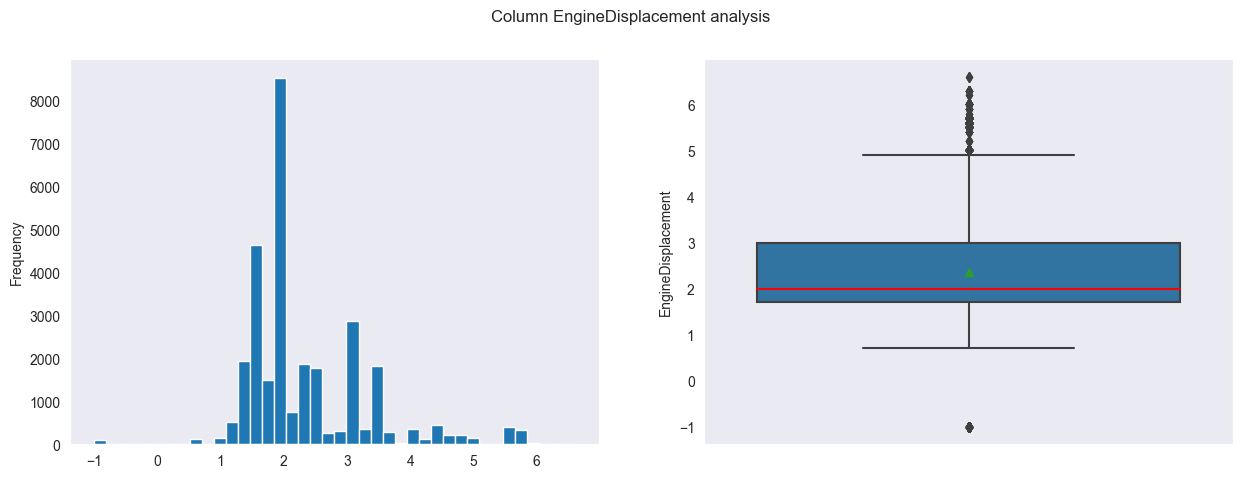

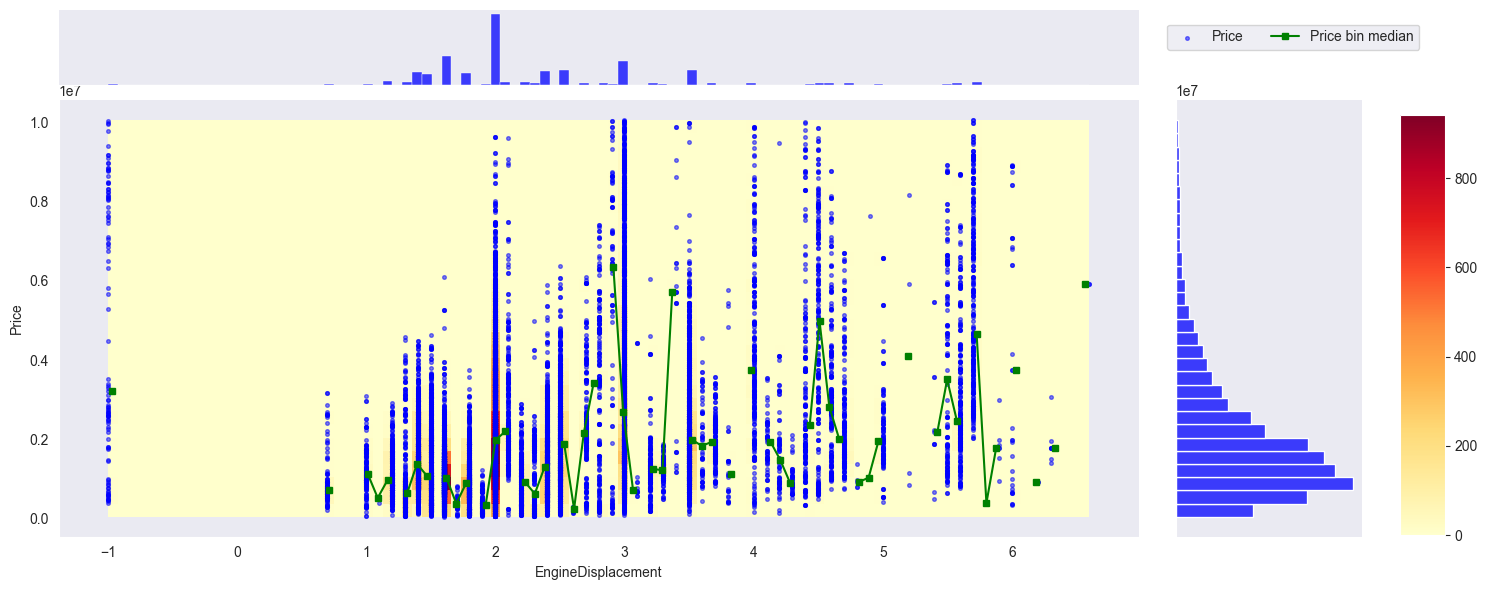

Statistics for EngineDisplacement column:


count                     30121.0
mean                     2.359709
std                      0.979204
min                          -1.0
25%                           1.7
50%                           2.0
75%                           3.0
max                           6.6
Median                        2.0
Mode/Count               2.0/8355
Skewness                 1.336466
IQR                           1.3
Number of outliers    1056 (3.5%)
Name: EngineDisplacement, dtype: object

EngineDisplacement     Price
EngineDisplacement            1.000000  0.354627
Price                         0.354627  1.000000

In [227]:
# analyze this numeric column for train and test
# there are extreme values in Price column, so we will use "almost all" quantile for more detailed picture
analyze_num_col(df_train[df_train['Price'] < df_train['Price'].quantile(0.99)],
                'EngineDisplacement', 'Price', hist_bins=40, hist2d_y_bins=30)

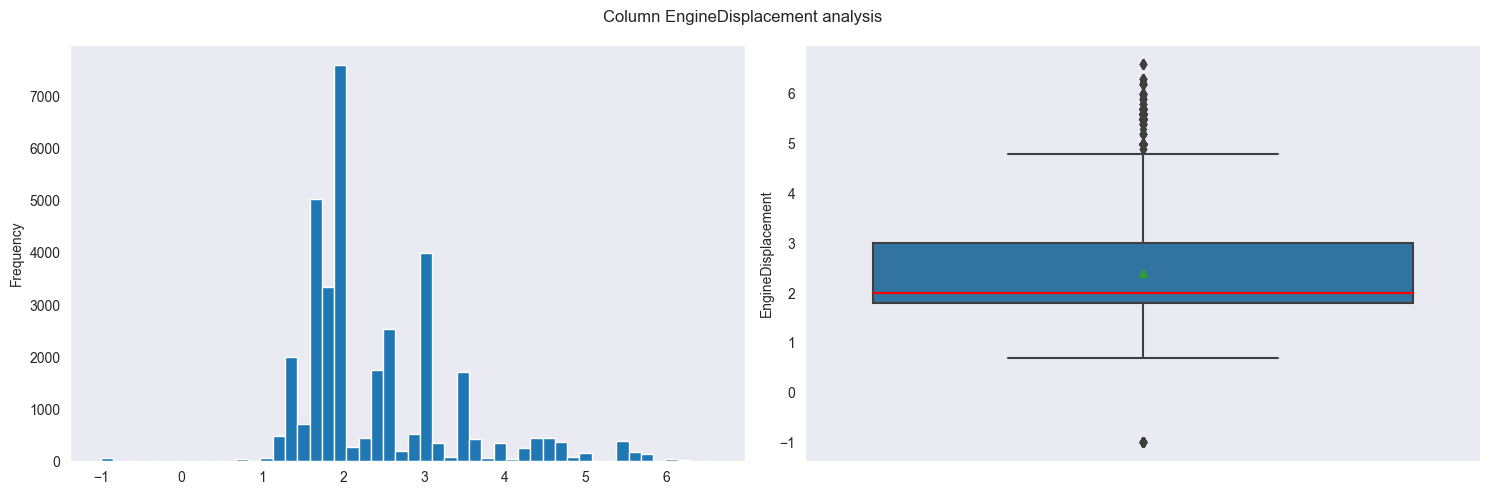

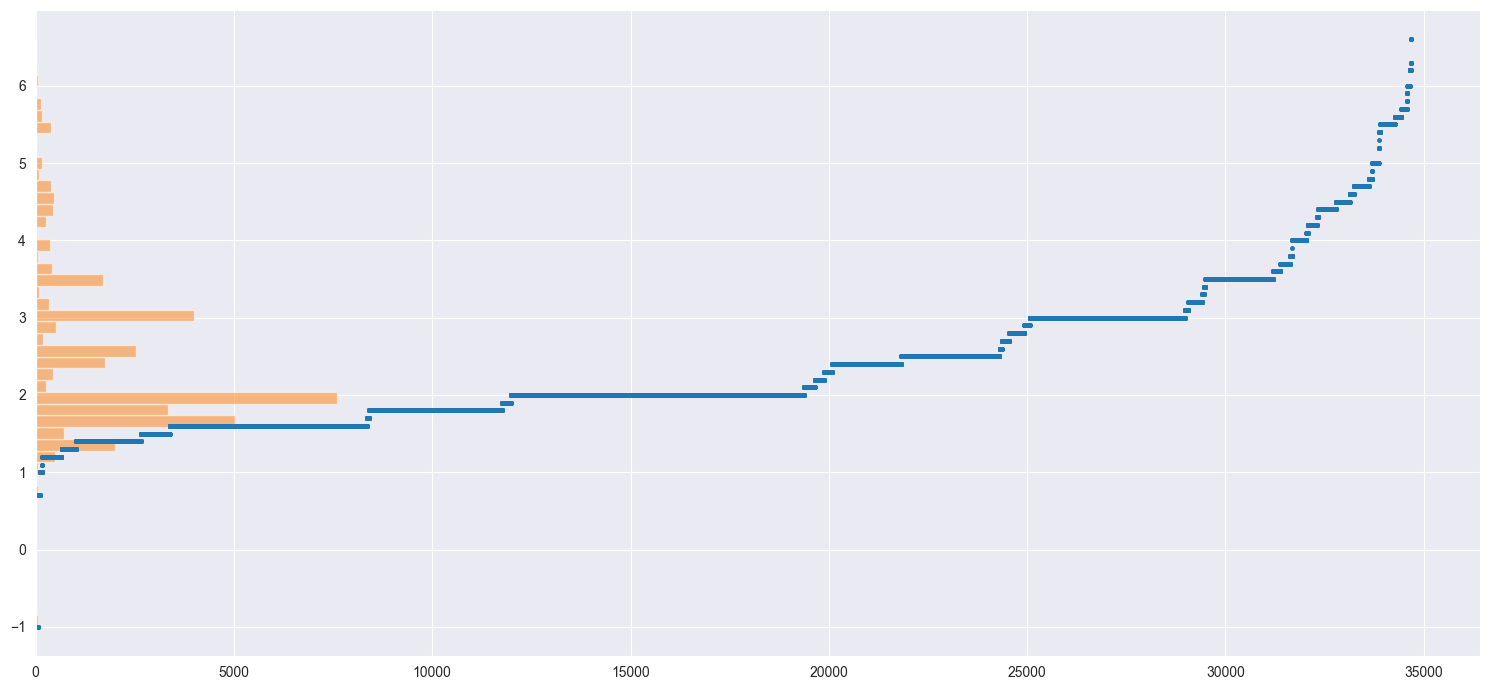

Statistics for EngineDisplacement column:


count                     34686.0
mean                     2.400669
std                      0.969242
min                          -1.0
25%                           1.8
50%                           2.0
75%                           3.0
max                           6.6
Median                        2.0
Mode/Count               2.0/7391
Skewness                 1.337277
IQR                           1.2
Number of outliers    1041 (3.0%)
Name: EngineDisplacement, dtype: object

EngineDisplacement
EngineDisplacement                 1.0

In [228]:
analyze_num_col(df_test, 'EngineDisplacement', hist_bins=50)

Conclusion:
Not so many outliers, not so far from IQR and values are real - no need to handle them.
Skewness is moderate - choose not to use log transformation.
See little positive correlation with price (corr coef 0.35). On graph by bins median line we see no correlation for values less than ~2.5 and then little positive.
**PNF(Possible New Feature)** Maybe create new feature for powerfull car. UPD: decided not to add this feature.
Train and test data are very similar for this feature - good for us.

#### 'EnginePower'

In [229]:
display(df_test['EnginePower'].value_counts(dropna=False).sort_index())
display(df_train['EnginePower'].value_counts(dropna=False).sort_index())

100 N12     88
101 N12    136
102 N12    832
103 N12     79
104 N12      9
          ... 
95 N12      72
96 N12       2
97 N12      70
98 N12     569
99 N12     118
Name: EnginePower, Length: 315, dtype: int64

45.0      9
46.0      4
49.0      6
50.0     11
52.0      4
         ..
639.0     5
646.0     1
700.0     3
843.0     2
900.0     3
Name: EnginePower, Length: 315, dtype: int64

In [230]:
# need to correct test data
df_test['EnginePower'] = pd.to_numeric(df_test['EnginePower'].apply(lambda s: s.replace(' N12','')), errors='coerce')
sum(df_test['EnginePower'].isna())

0

Ok, no missing values after correction. Let's analyze this feature.

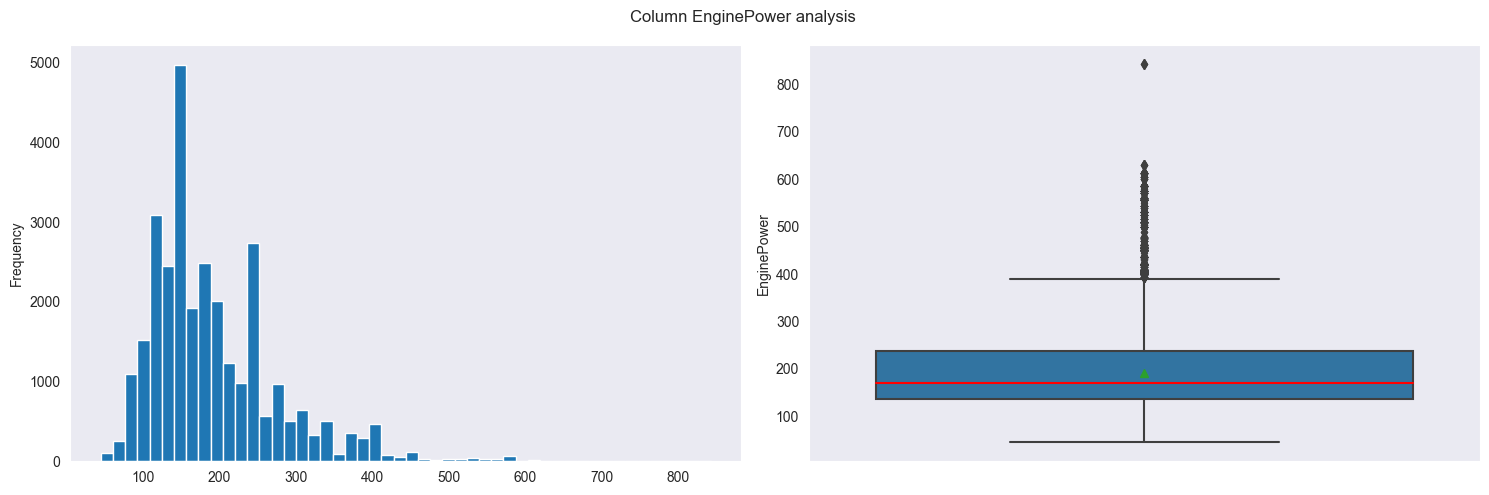

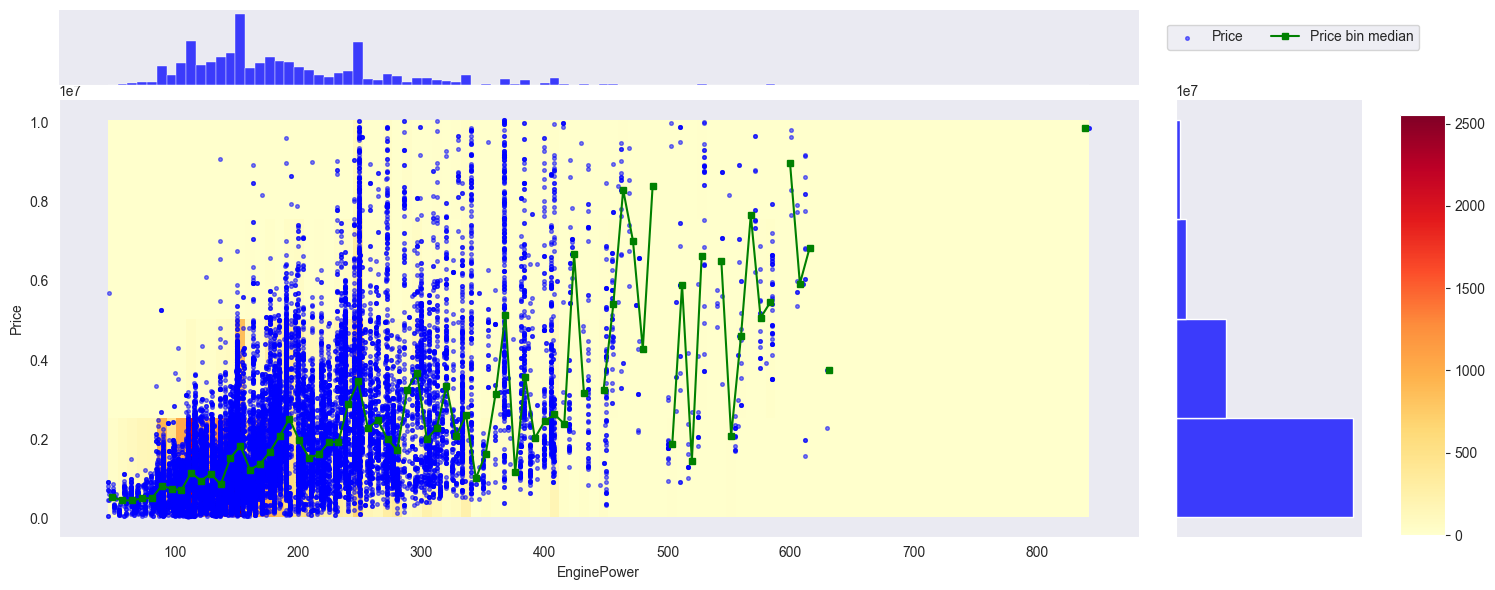

Statistics for EnginePower column:


count                     30121.0
mean                   192.177717
std                     84.628892
min                          45.0
25%                         136.0
50%                         170.0
75%                         238.0
max                         843.0
Median                      170.0
Mode/Count             150.0/2631
Skewness                 1.413503
IQR                         102.0
Number of outliers    1023 (3.4%)
Name: EnginePower, dtype: object


Column EnginePower log transform analysis:


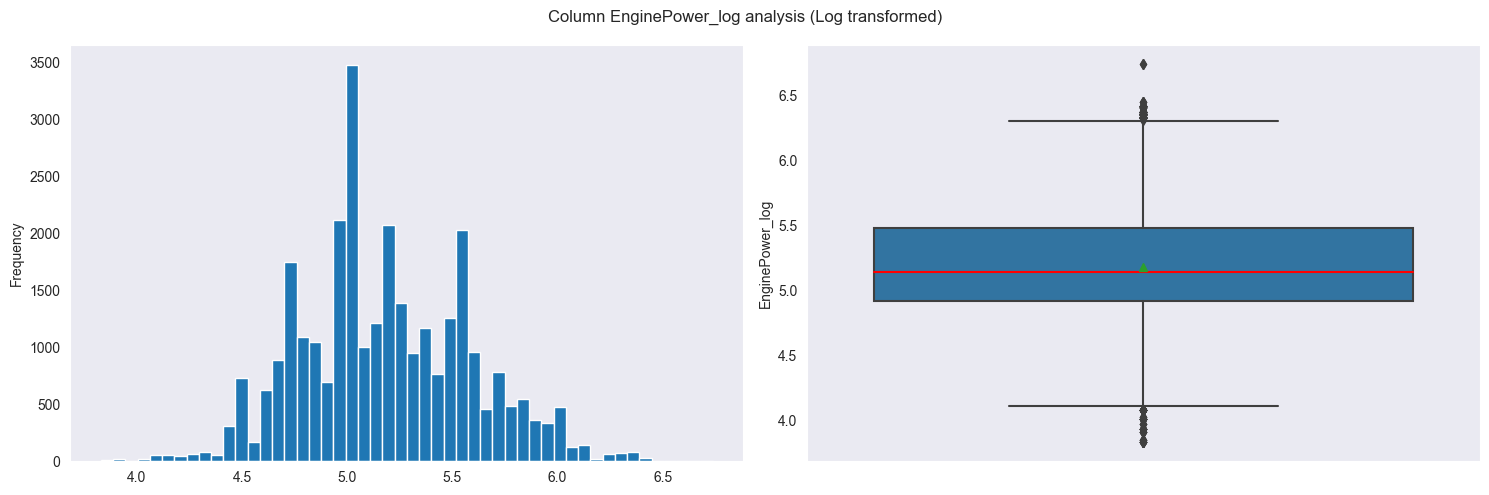

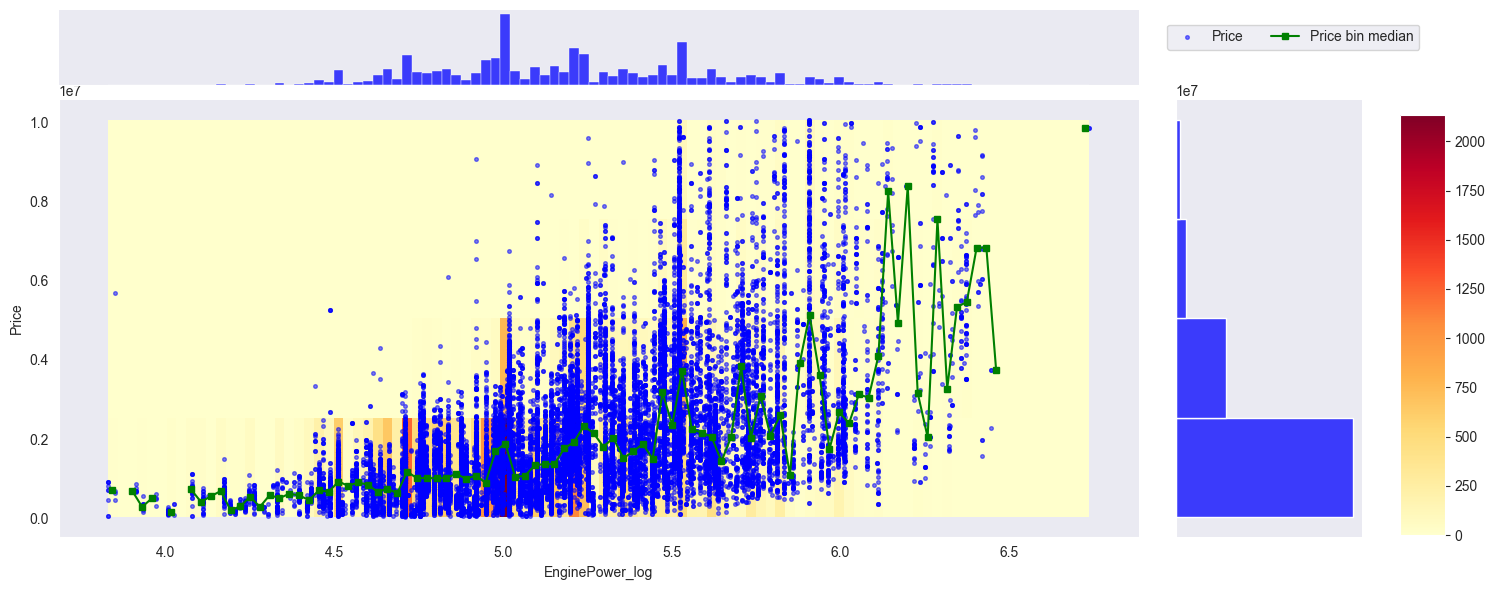

Statistics for EnginePower_log column:


count                                30121.0
mean                                5.179181
std                                 0.404994
min                                 3.828641
25%                                 4.919981
50%                                 5.141664
75%                                 5.476464
max                                 6.738152
Median                              5.141664
Mode/Count            5.017279836814924/2631
Skewness                            0.239467
IQR                                 0.556483
Number of outliers                222 (0.7%)
Name: EnginePower_log, dtype: object

EnginePower  EnginePower_log     Price
EnginePower         1.000000         0.963686  0.549122
EnginePower_log     0.963686         1.000000  0.553063
Price               0.549122         0.553063  1.000000

In [231]:
# also use quantile due to outliers in Price
analyze_num_col(df_train[df_train['Price'] < df_train['Price'].quantile(0.99)],
                'EnginePower', 'Price', hist_bins=50, need_log=True, hist2d_y_bins=4)

In [232]:
# skewness of distribution improved significantly after log transform and correlation is a bit greater log transformed feature
# so, add to log_transform features instead of source feature
cols_to_log.add('EnginePower');

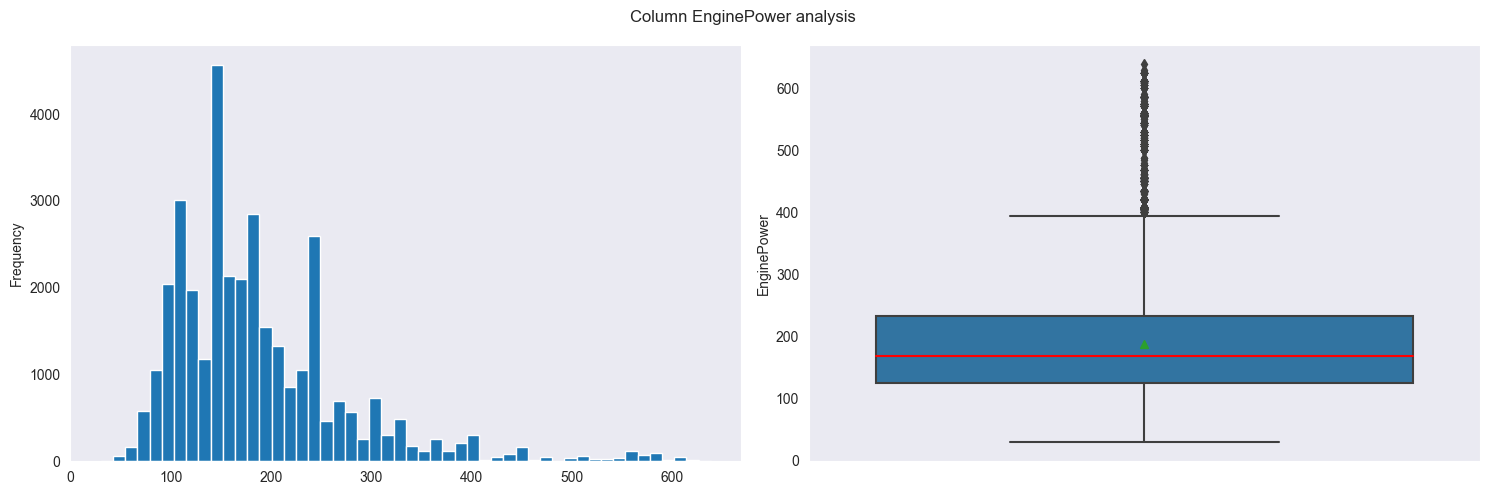

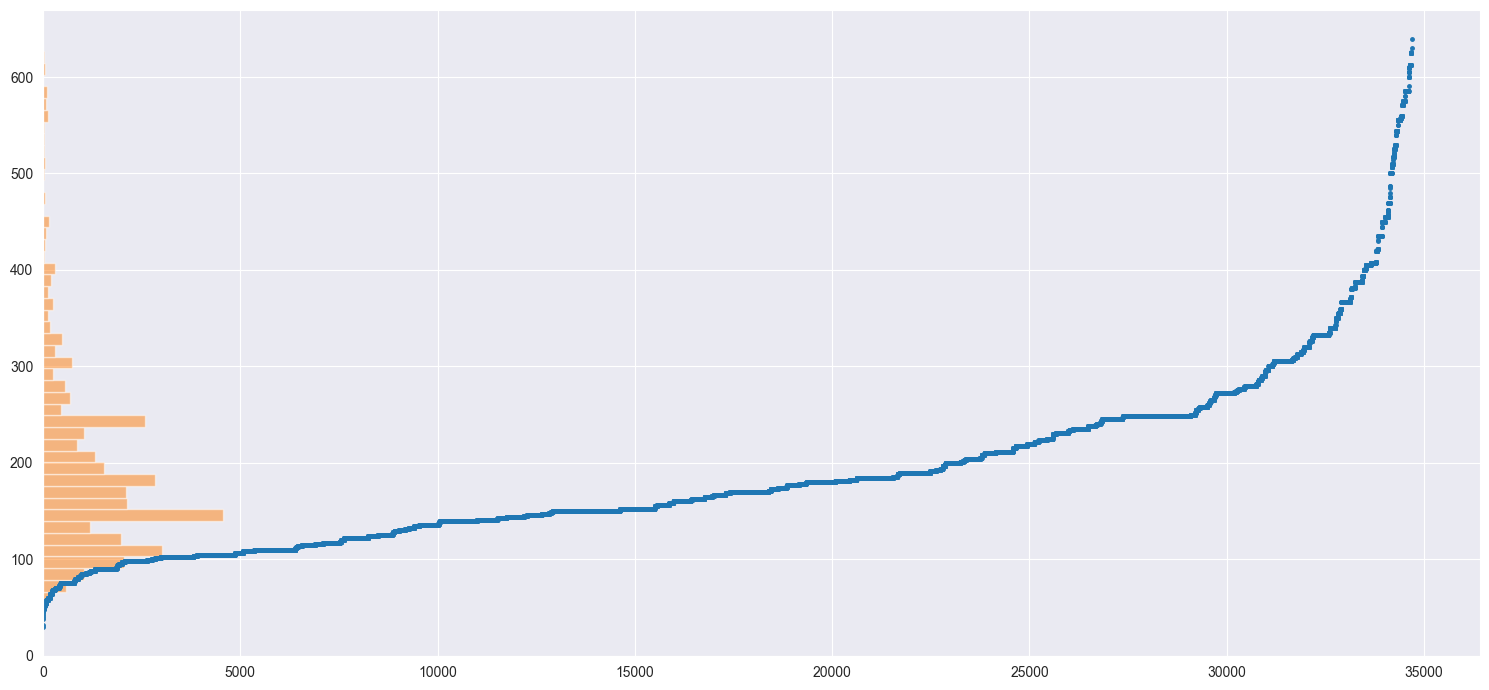

Statistics for EnginePower column:


count                     34686.0
mean                   188.194142
std                     89.087035
min                          30.0
25%                         125.0
50%                         169.0
75%                         233.0
max                         639.0
Median                      169.0
Mode/Count               249/1708
Skewness                 1.691456
IQR                         108.0
Number of outliers    1219 (3.5%)
Name: EnginePower, dtype: object

EnginePower
EnginePower          1.0

In [233]:
# let's see on test
analyze_num_col(df_test, 'EnginePower', hist_bins=50)

Conclusion:
Not so many outliers, not so far from IQR and values are real - no need to handle them.
See noticeable correlation and on graph and by corr coefficient.
Skewness significantly improved after log transform - choose to use log transformation for this column before learning.
Train and test data are similar for this feature.

'Mileage'

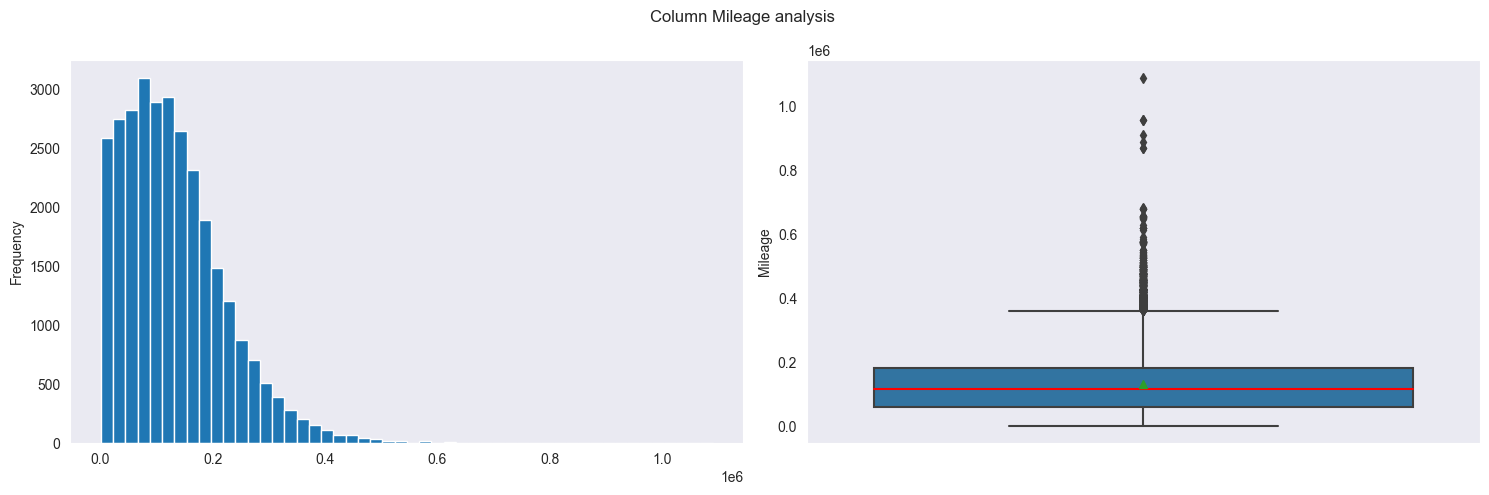

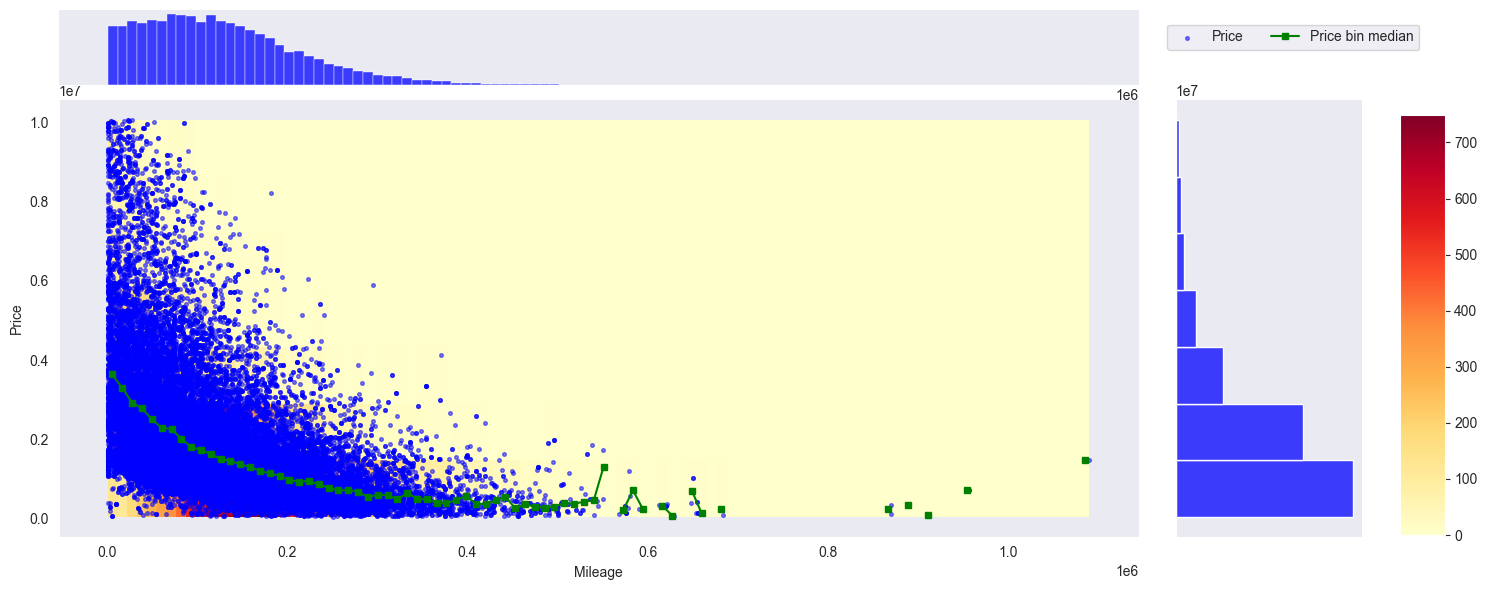

Statistics for Mileage column:


count                       30121.0
mean                  131073.071943
std                    92369.558105
min                          1000.0
25%                         61000.0
50%                        116000.0
75%                        181000.0
max                       1090000.0
Median                     116000.0
Mode/Count               1000.0/348
Skewness                   1.198888
IQR                        120000.0
Number of outliers       643 (2.1%)
Name: Mileage, dtype: object


Column Mileage log transform analysis:


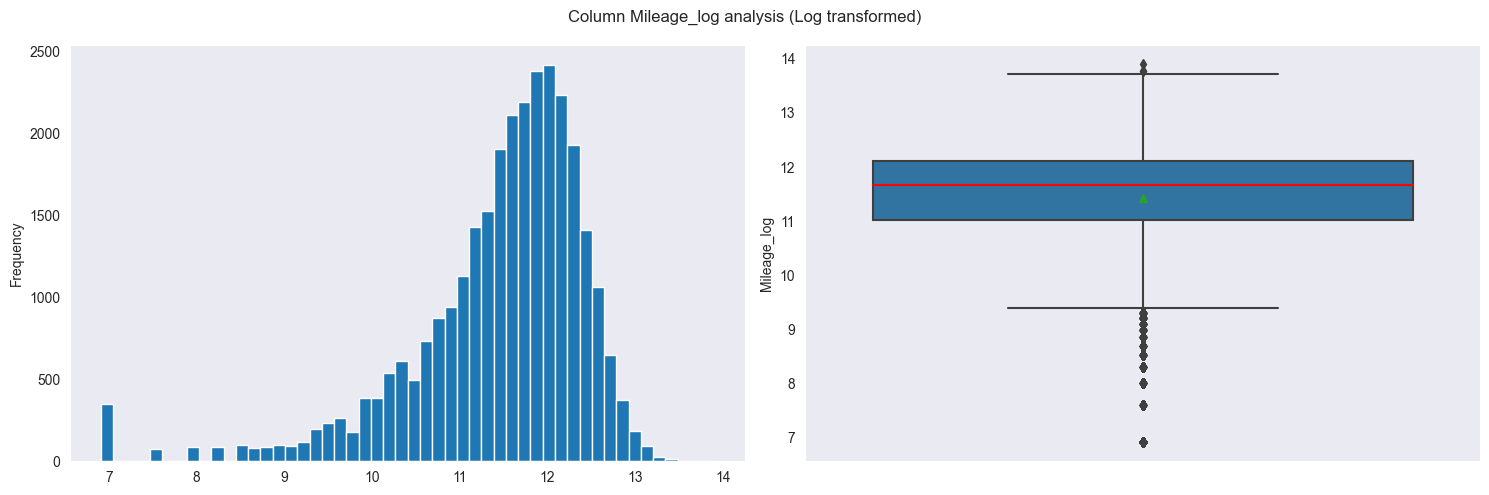

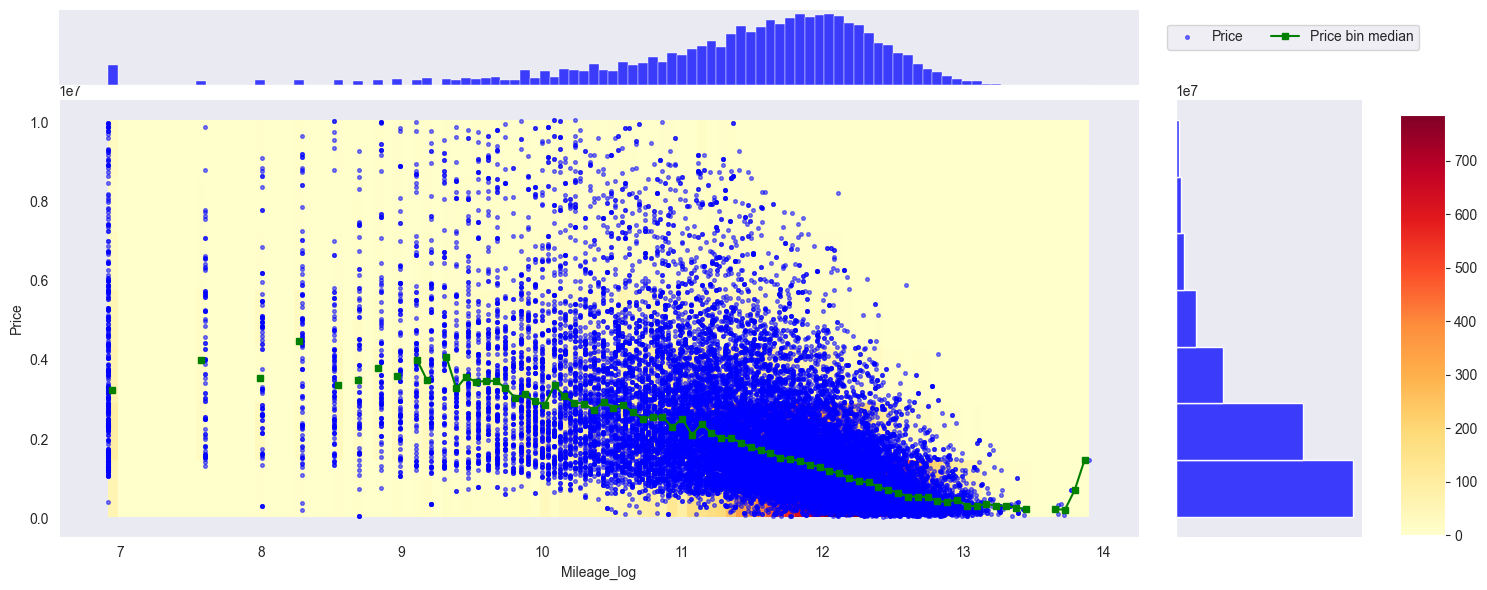

Statistics for Mileage_log column:


count                              30121.0
mean                             11.435741
std                               1.025735
min                               6.908755
25%                              11.018646
50%                              11.661354
75%                              12.106258
max                              13.901689
Median                           11.661354
Mode/Count            6.90875477931522/348
Skewness                         -1.672266
IQR                               1.087612
Number of outliers             1287 (4.3%)
Name: Mileage_log, dtype: object

Mileage  Mileage_log     Price
Mileage      1.000000     0.819067 -0.516959
Mileage_log  0.819067     1.000000 -0.535830
Price       -0.516959    -0.535830  1.000000

In [234]:
analyze_num_col(df_train[df_train['Price'] < df_train['Price'].quantile(0.99)],
                'Mileage', 'Price', hist_bins=50, need_log=True, hist2d_y_bins=7)

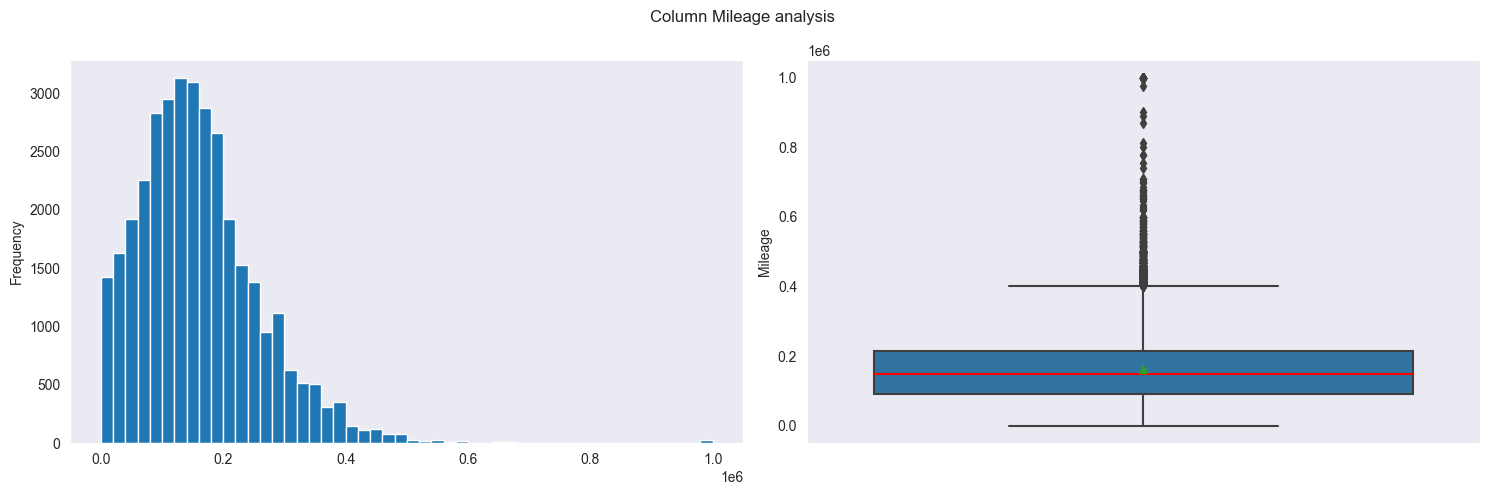

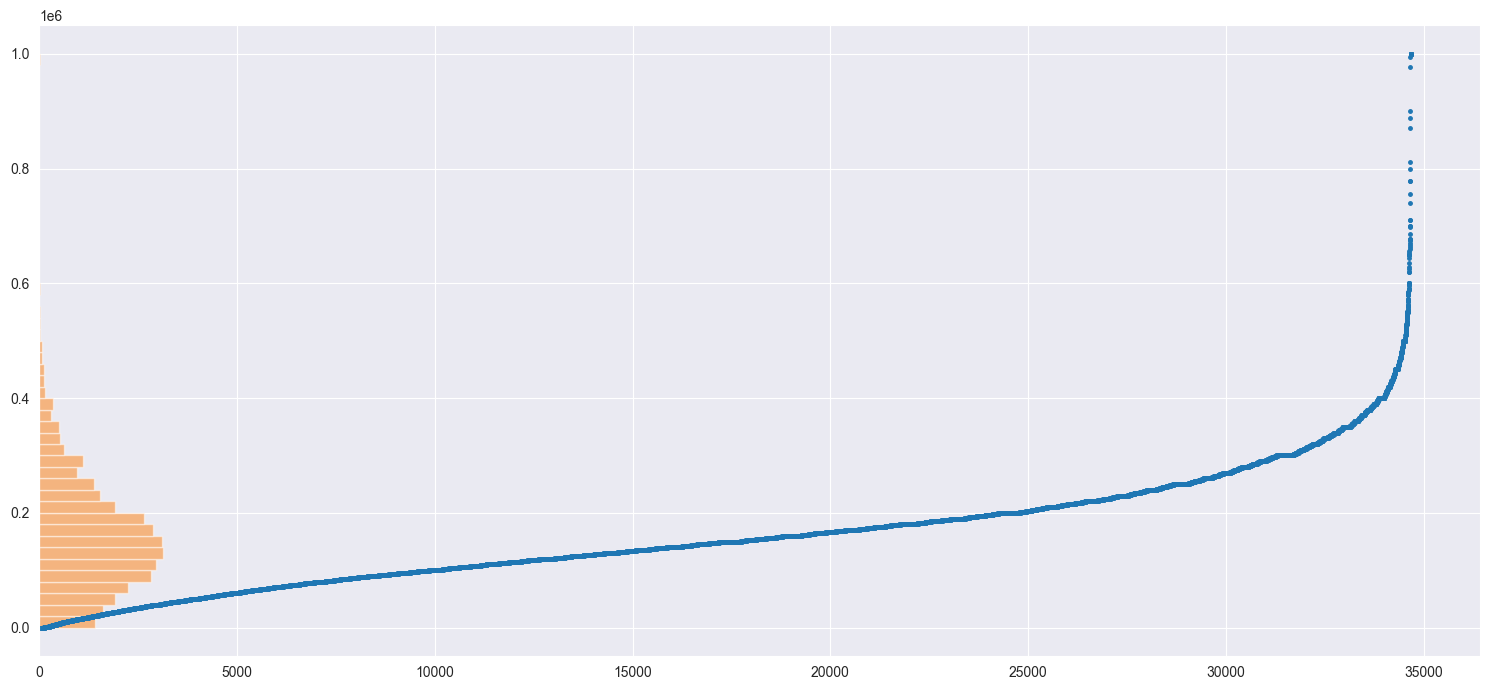

Statistics for Mileage column:


count                       34686.0
mean                  162009.767889
std                   100676.559489
min                             1.0
25%                         91153.5
50%                        149779.5
75%                        215000.0
max                       1000000.0
Median                     149779.5
Mode/Count               200000/436
Skewness                   1.270463
IQR                        123846.5
Number of outliers       692 (2.0%)
Name: Mileage, dtype: object

Mileage
Mileage      1.0

In [235]:
# let's see on test
analyze_num_col(df_test, 'Mileage', hist_bins=50)

Conclusion:
Not so many outliers and values are real - no need to handle them.
Distribition is skewed a little (test even less) and log transform not helped much - choose not to use log transformation. But it vakes sense to have a glance on the distribution of mileage per year later.
Price (expectedly) gradually decrease with mileage growing and without any noticeable exceptions. Good correlation with price.
Train and test data are rather similar for this feature, but have some differences in statistics (not critical).

#### 'ModelDate' and 'ProductionDate'

'ModelDate'

In [236]:
df_train['ModelDate'].value_counts(dropna=False).sort_index()

1937.0       1
1958.0       1
1968.0       2
1974.0      11
1975.0       5
1978.0       3
1979.0       2
1980.0       3
1981.0       1
1982.0      30
1983.0      46
1984.0      11
1985.0      11
1986.0      64
1987.0      44
1988.0      64
1989.0      30
1990.0      67
1991.0     145
1992.0      54
1993.0      98
1994.0     110
1995.0     294
1996.0     163
1997.0     305
1998.0     261
1999.0     260
2000.0     381
2001.0     270
2002.0     503
2003.0     307
2004.0     429
2005.0    1092
2006.0    1275
2007.0    1085
2008.0    1406
2009.0    1228
2010.0    1724
2011.0    1770
2012.0    2047
2013.0    2569
2014.0    2433
2015.0    2721
2016.0    1294
2017.0    2867
2018.0    1176
2019.0     772
2020.0     943
2021.0      49
Name: ModelDate, dtype: int64

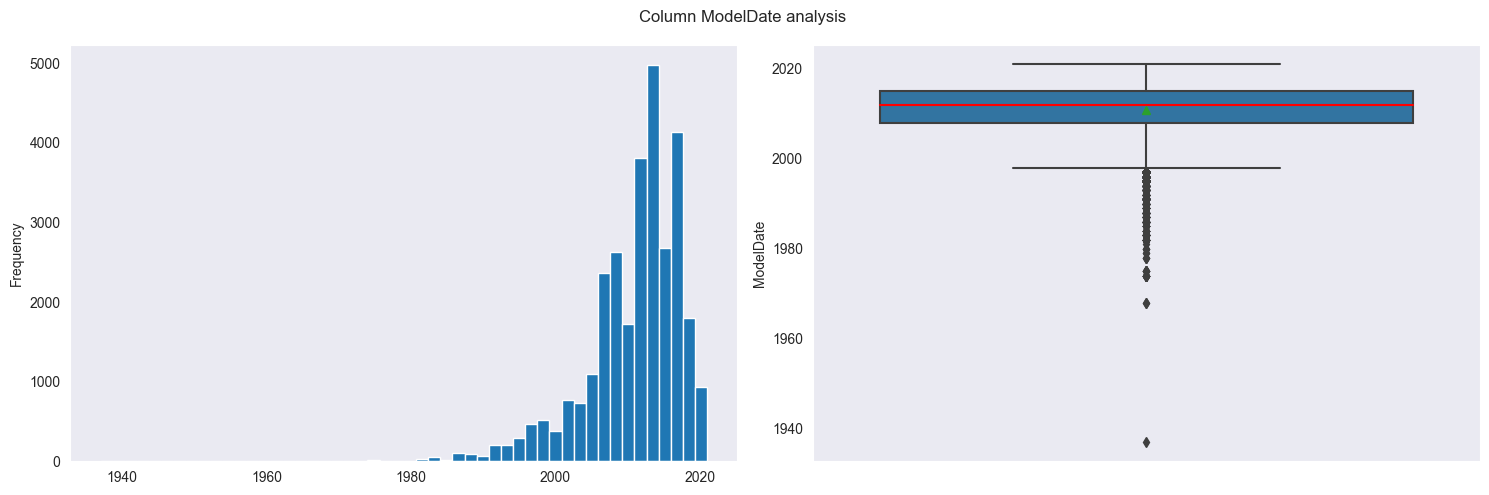

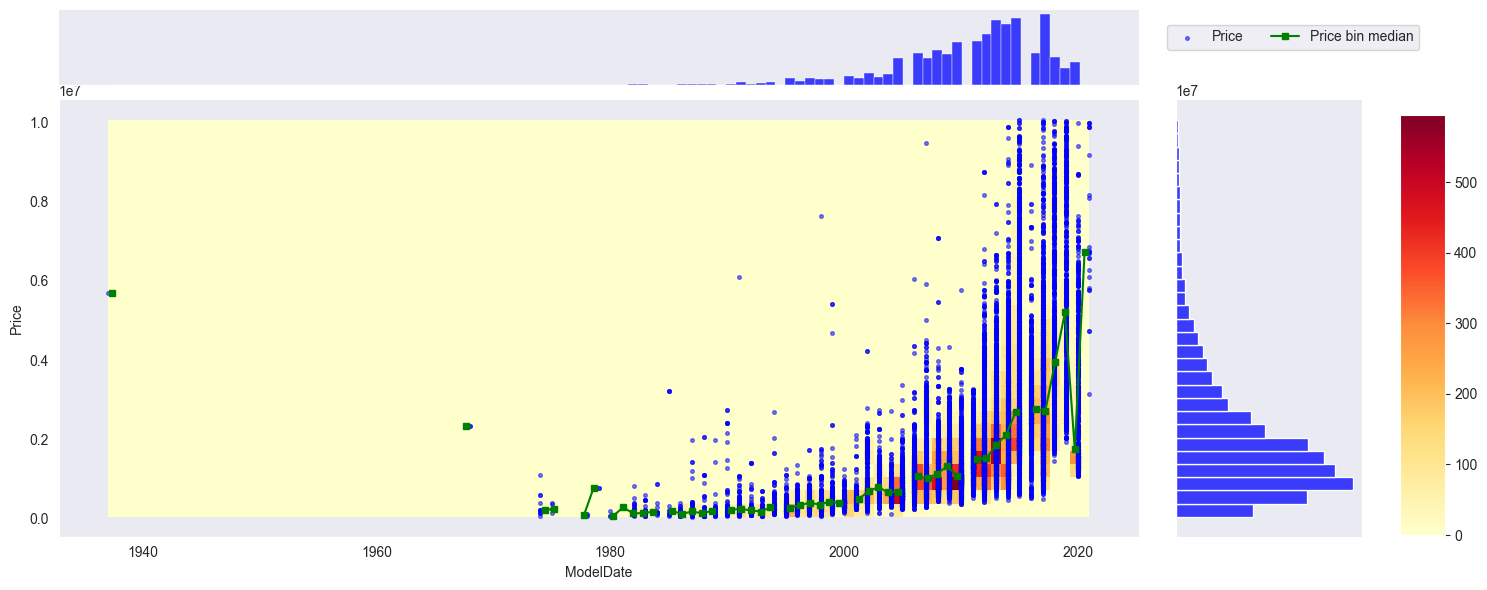

In [237]:
# there are extreme values in Price column, so use "almost all" quantile for more detailed picture
vis_analyze_num_col(df_train[df_train['Price'] < df_train['Price'].quantile(0.99)],
                    'ModelDate', 'Price', hist_bins=50, hist2d_x_bins=100, hist2d_y_bins=30)

Price                    
               median          mean count
ModelDate                                
2019.0      5485000.0  6.233459e+06   772
2020.0      1820000.0  3.205260e+06   943
2021.0     10160000.0  9.379592e+06    49

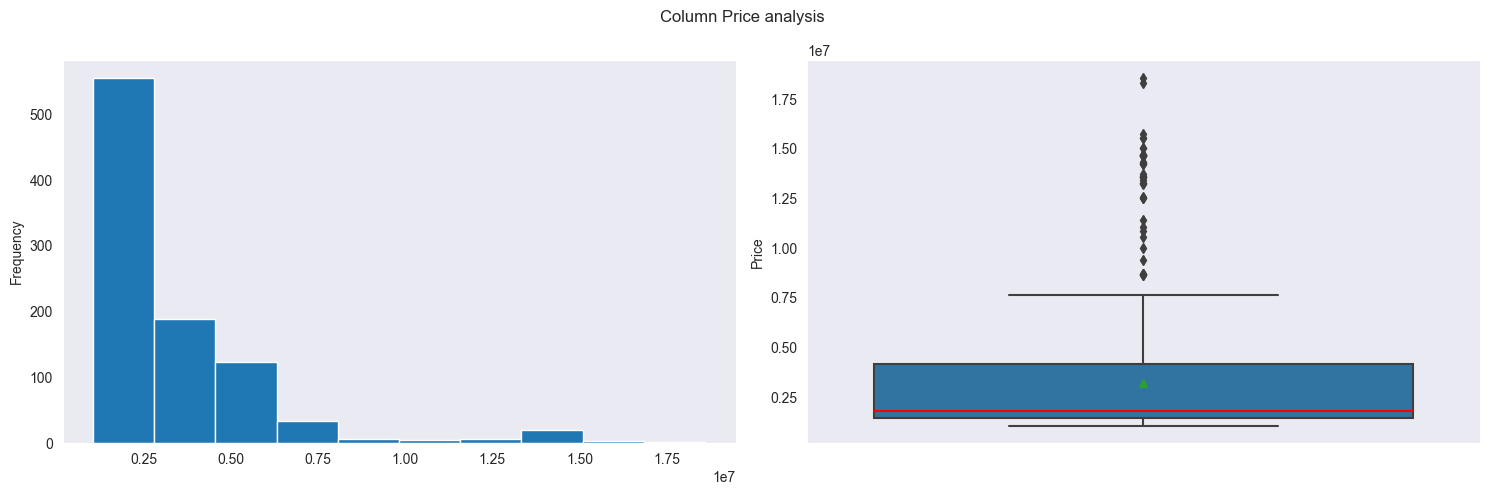

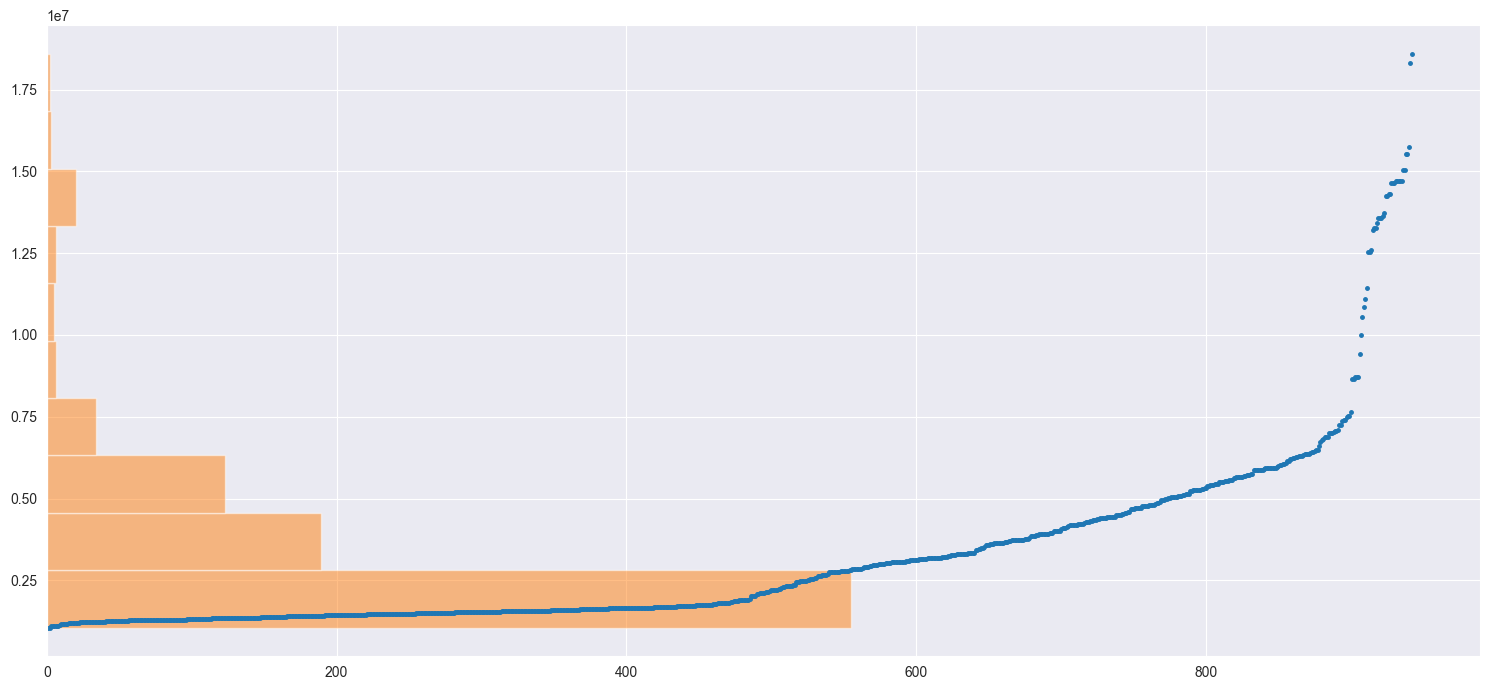

Statistics for Price column:


count                          943.0
mean                   3205259.80912
std                   2749090.703046
min                        1060000.0
25%                        1470000.0
50%                        1820000.0
75%                        4180000.0
max                       18590000.0
Median                     1820000.0
Mode/Count              1300000.0/19
Skewness                    2.552803
IQR                        2710000.0
Number of outliers         42 (4.5%)
Name: Price, dtype: object

Price
Price    1.0

In [238]:
# we see unexpectedly low average price for cars with model date 2020.. let's look more thouroughly
display(df_train[['ModelDate','Price']].groupby('ModelDate').agg({'Price':['median','mean','count']}).iloc[-3:])
analyze_num_col(df_train[df_train['ModelDate'] == 2020],'Price')

Really, many cars with relatively low price with 2020 model date.., but only one point and no clear reason - probably a noise

In [239]:
# in test
df_test['ModelDate'].value_counts(dropna=False).sort_index()

1904       1
1934       1
1936       2
1937       3
1938       7
        ... 
2016     899
2017    1134
2018     391
2019     142
2020       5
Name: ModelDate, Length: 66, dtype: int64

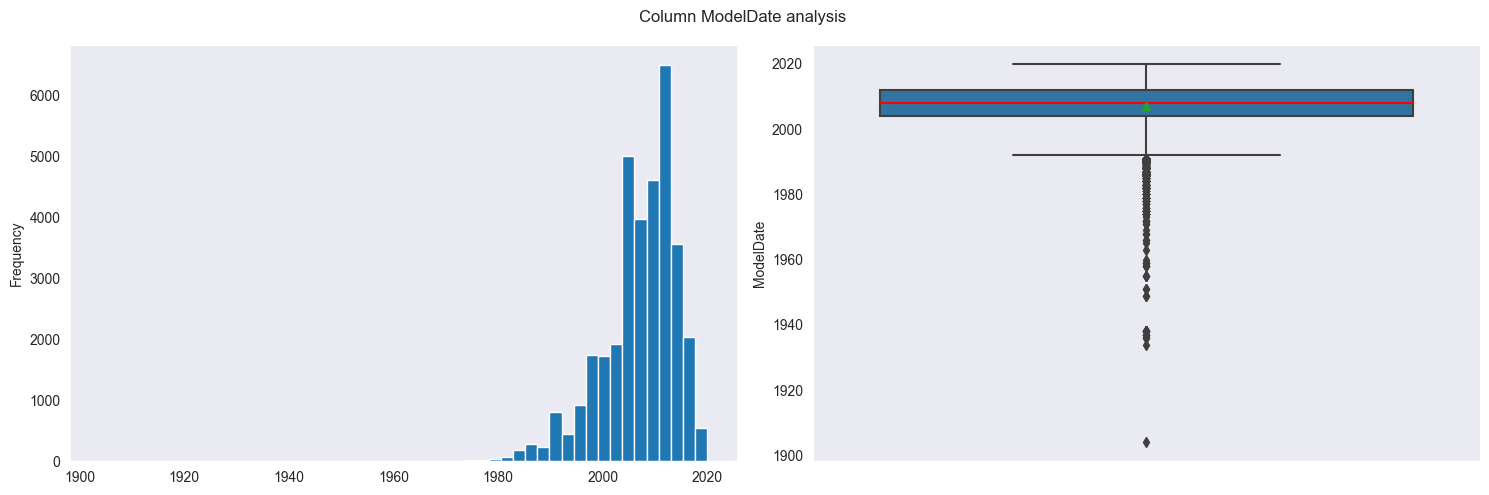

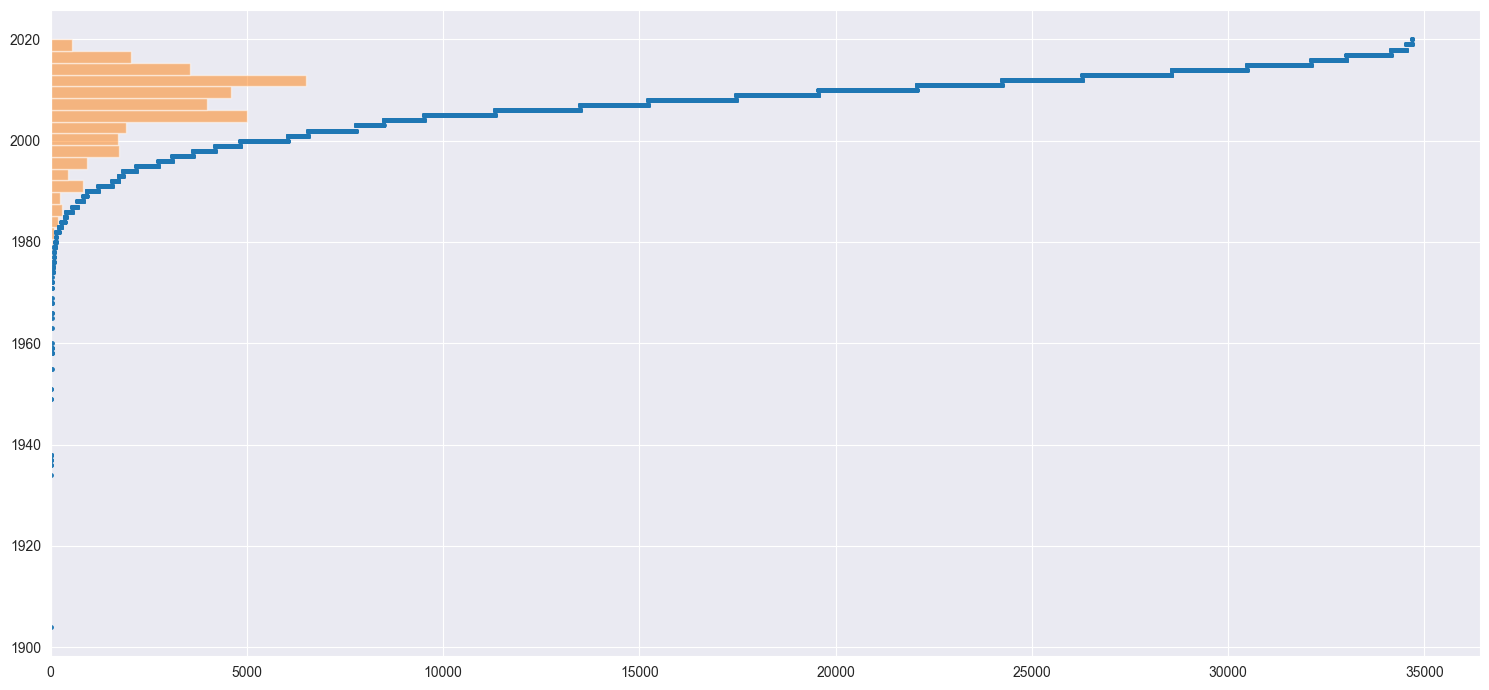

Statistics for ModelDate column:


count                     34686.0
mean                  2007.074728
std                      7.415894
min                        1904.0
25%                        2004.0
50%                        2008.0
75%                        2012.0
max                        2020.0
Median                     2008.0
Mode/Count              2010/2503
Skewness                -1.517707
IQR                           8.0
Number of outliers    1562 (4.5%)
Name: ModelDate, dtype: object

ModelDate
ModelDate        1.0

In [240]:
analyze_num_col(df_test, 'ModelDate', hist_bins=50)

Conclusion:
We have noticeable decrease ("step") in price for car model date <= 2011 - 10 year old model (psychological barrier?).
**PNF** Maybe should add new feature for 10 year and older car model, BUT it's better to judge on production date, besides as we see later this feature is highly correlated with production date and less correlated with price, so will be deleted. UPD: decided not to create this feature due to absent of any sharp drop in price for prod date and age features.
Also we can see a "rarity effect" (however for only several points)
**PNF** Maybe it's a reason to create categorical or binary feature for old cars. But again let's see on production date. UPD: decided to create based on age.
Train and test histogram are similar, but we have some (very few) points in test for very old cars that we lack in train. Just several values - don’t think that’s gonna be a problem.

'ProductionDate'

In [241]:
df_train['ProductionDate'].value_counts(dropna=False).sort_index()

1948.0       1
1959.0       1
1968.0       2
1974.0       1
1978.0       3
1981.0       5
1982.0       2
1983.0       6
1984.0      19
1985.0      22
1986.0      25
1987.0      27
1988.0      34
1989.0      41
1990.0      41
1991.0      61
1992.0      74
1993.0      96
1994.0      85
1995.0      97
1996.0     133
1997.0     194
1998.0     259
1999.0     267
2000.0     267
2001.0     284
2002.0     299
2003.0     350
2004.0     357
2005.0     436
2006.0     614
2007.0    1110
2008.0    1450
2009.0     533
2010.0    1074
2011.0    1669
2012.0    2056
2013.0    2058
2014.0    2140
2015.0    1793
2016.0    1968
2017.0    2382
2018.0    2894
2019.0    2010
2020.0    1844
2021.0    1339
2022.0       4
Name: ProductionDate, dtype: int64

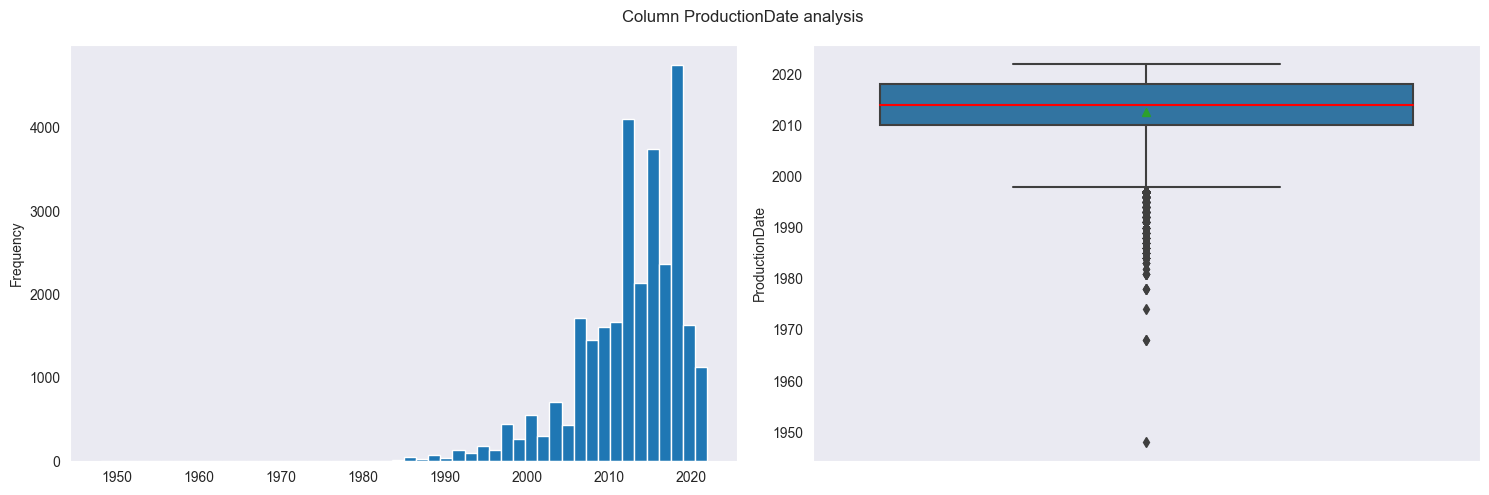

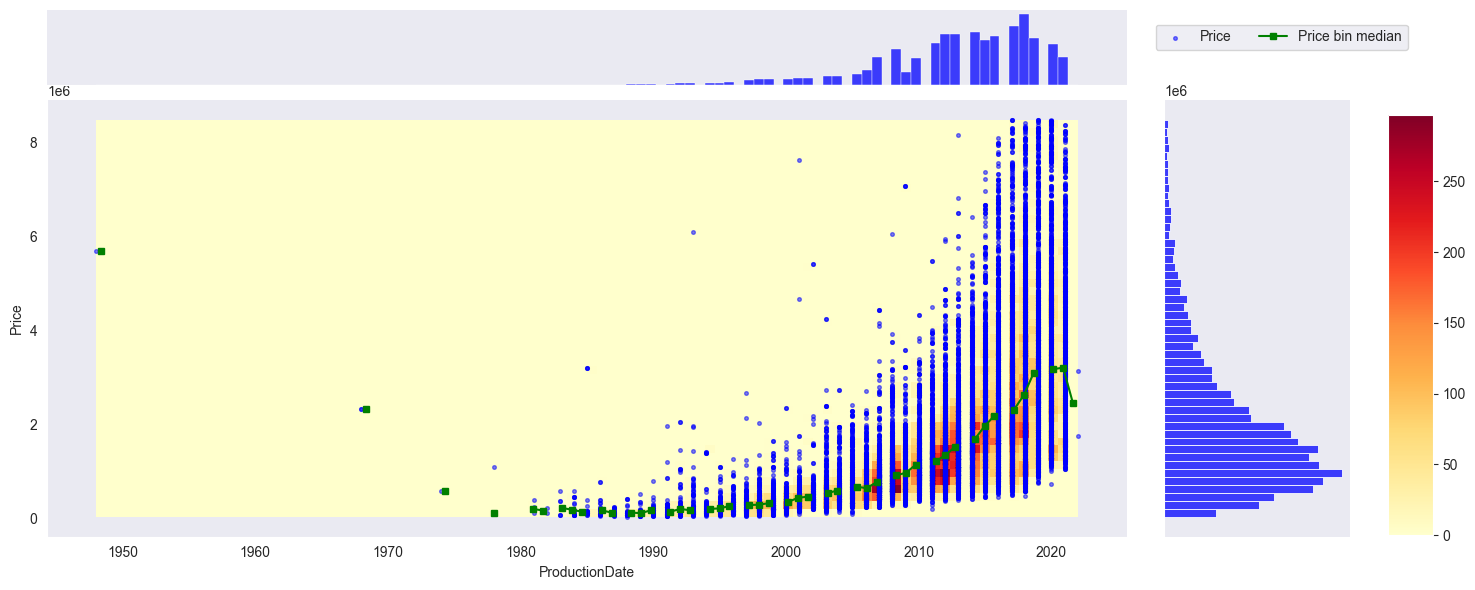

Statistics for ProductionDate column:


count                     29818.0
mean                  2012.688309
std                      6.408795
min                        1948.0
25%                        2010.0
50%                        2014.0
75%                        2018.0
max                        2022.0
Median                     2014.0
Mode/Count            2018.0/2857
Skewness                -1.349724
IQR                           8.0
Number of outliers     969 (3.2%)
Name: ProductionDate, dtype: object

ProductionDate     Price
ProductionDate        1.000000  0.598916
Price                 0.598916  1.000000

In [242]:
# there are extreme values in Price column, so use quantile for more detailed picture
analyze_num_col(df_train[df_train['Price'] < df_train['Price'].quantile(0.98)],
                'ProductionDate', 'Price', hist_bins=50, hist2d_y_bins=50)

In [243]:
df_test['ProductionDate'].value_counts(dropna=False).sort_index()

1904       1
1936       1
1937       2
1938       1
1939       1
        ... 
2016    1615
2017    1667
2018    1574
2019    1081
2020     260
Name: ProductionDate, Length: 69, dtype: int64

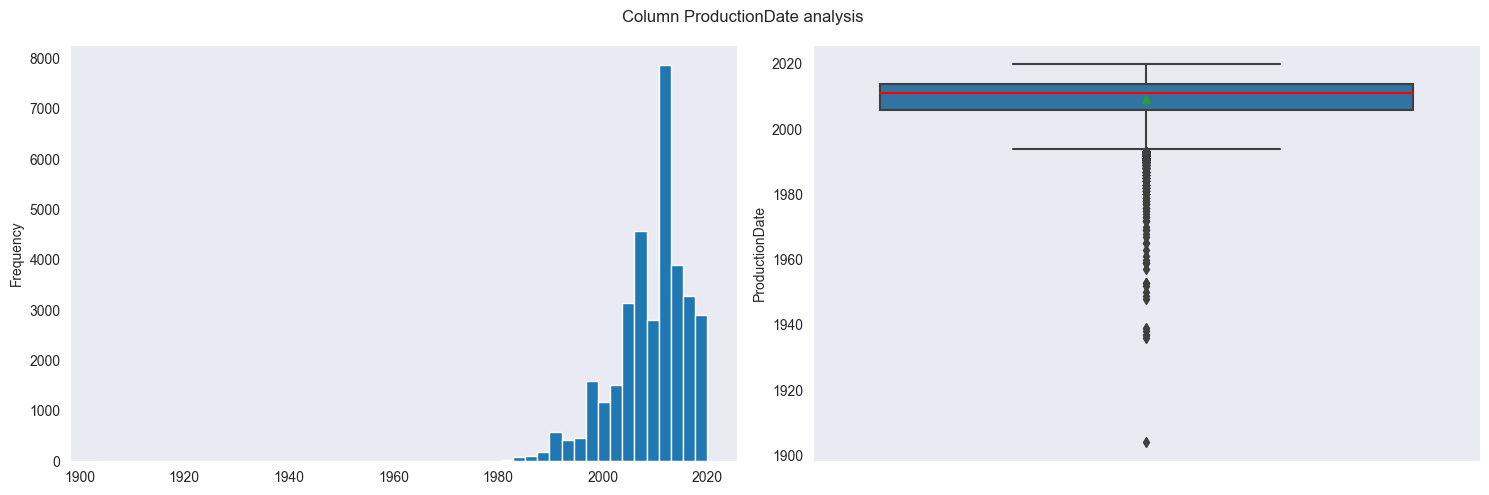

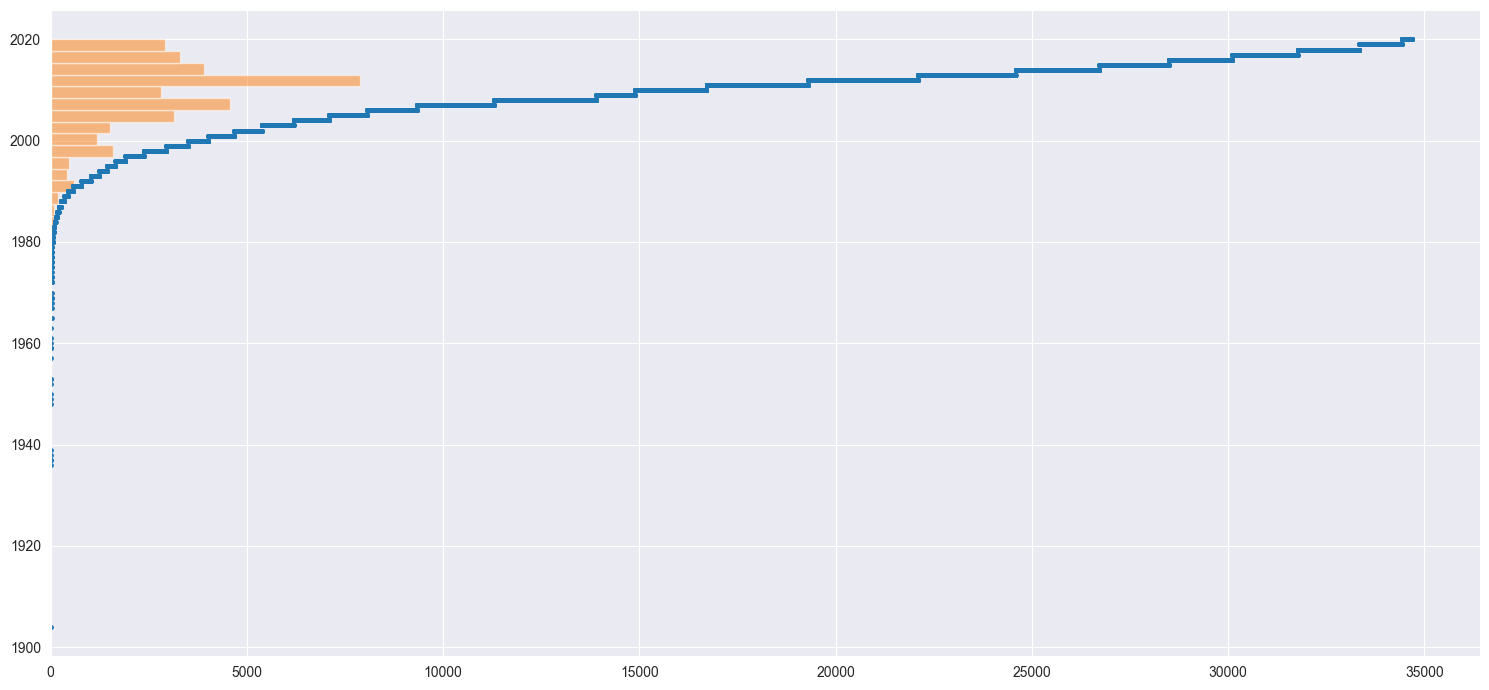

Statistics for ProductionDate column:


count                     34686.0
mean                  2009.264602
std                      7.047661
min                        1904.0
25%                        2006.0
50%                        2011.0
75%                        2014.0
max                        2020.0
Median                     2011.0
Mode/Count              2012/2798
Skewness                -1.386527
IQR                           8.0
Number of outliers    1236 (3.6%)
Name: ProductionDate, dtype: object

ProductionDate
ProductionDate             1.0

In [244]:
analyze_num_col(df_test, 'ProductionDate', hist_bins=50)

Conclusion:
Don't see any clear "steps" or drawdowns in price for production date - rather smooth dependency. As expected positively correlated with price.
Also see "rarity effect".
**PNF** So maybe create and try a new feature for really old cars (e.g. for prod date < ~1975, age > 45).
Train and test histogram are similar, also have some (very few) points in test for very old cars that we lack in train.

#### Correlation analysis

<AxesSubplot:>

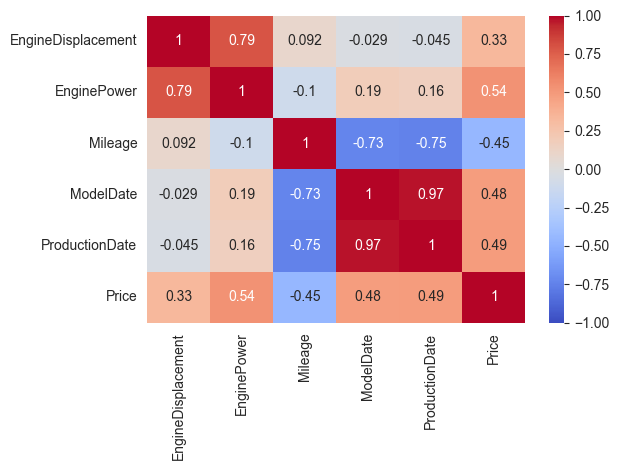

In [245]:
sb.heatmap(df_train[num_cols | {'Price'}].corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')

We see high correlation for 'EngineDisplacement' and 'EnginePower', and for 'ModelDate' and 'ProductionDate' features. Leave those which have greater correlation with target and add to deletion list others.

In [246]:
cols_to_del |= {'EngineDisplacement', 'ModelDate'}

Now let's see on mileage per year distributions for train and test:

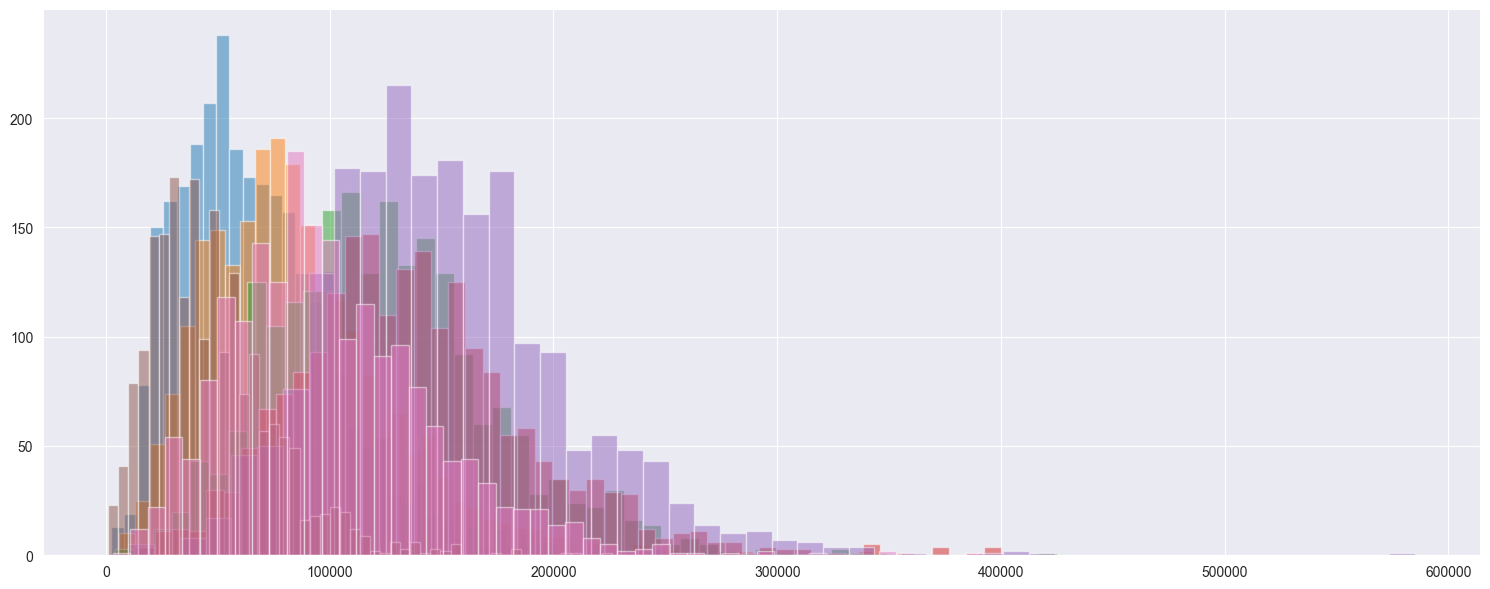

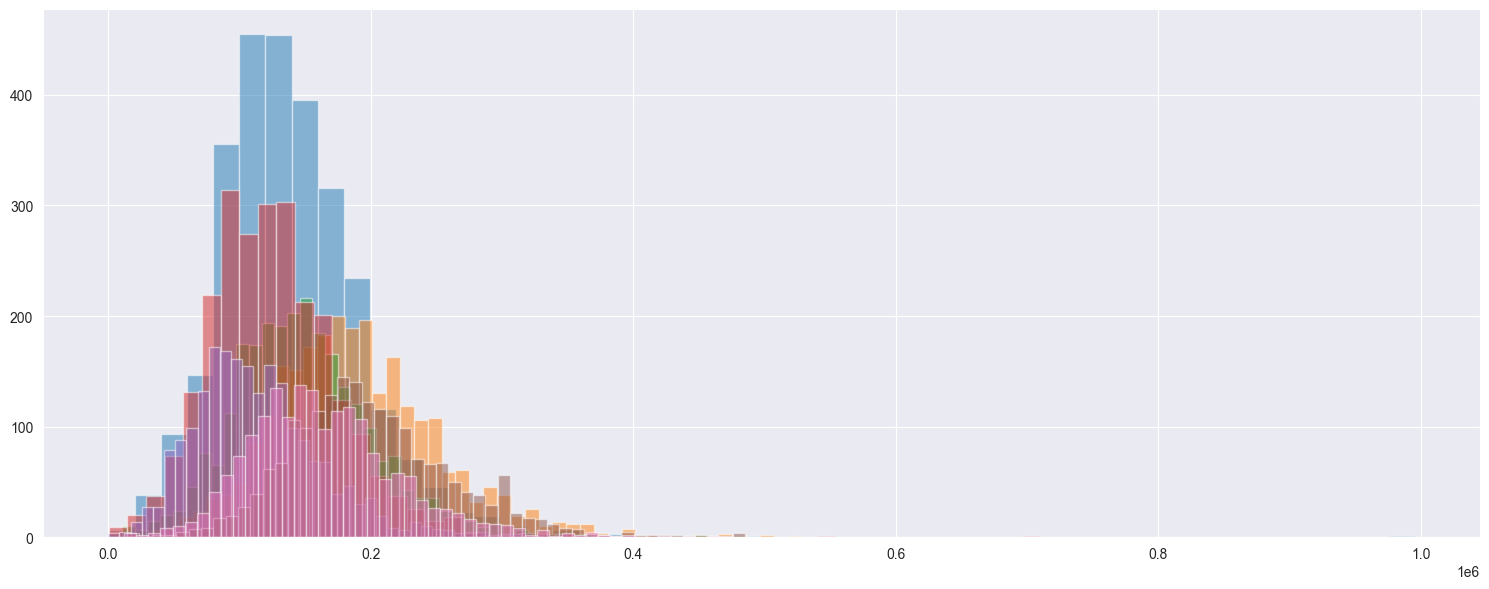

In [247]:
for df in dfs.values():
    plt.figure(figsize=(15, 6))
    for year in df['ProductionDate'].value_counts().index[:7]:
        df[df['ProductionDate'] == year]['Mileage'].hist(bins=50, alpha=0.5)

Distributions looks rather normal.
**PNF** So would be useful to create new feature for mileage per year.

### Categorical features

#### 'BodyType'

In [248]:
display(df_train['BodyType'].value_counts(dropna=False))
print('nunique =',df_train['BodyType'].nunique())
display(df_test['BodyType'].value_counts(dropna=False))
print('nunique =',df_test['BodyType'].nunique())

внедорожник 5 дв.          14238
седан                       9023
лифтбек                     2424
хэтчбек 5 дв.               1697
универсал 5 дв.              881
минивэн                      589
компактвэн                   433
купе                         428
хэтчбек 3 дв.                230
пикап двойная кабина         226
внедорожник 3 дв.             55
купе-хардтоп                  53
кабриолет                     51
микровэн                      35
фургон                        28
родстер                       24
седан-хардтоп                  4
пикап полуторная кабина        3
седан 2 дв.                    2
внедорожник открытый           1
лимузин                        1
пикап одинарная кабина         1
Name: BodyType, dtype: int64

nunique = 22


седан                      13147
внедорожник 5 дв.          12228
лифтбек                     2232
хэтчбек 5 дв.               2124
универсал 5 дв.             1276
минивэн                      995
купе                         824
компактвэн                   489
хэтчбек 3 дв.                485
пикап двойная кабина         280
купе-хардтоп                 158
внедорожник 3 дв.            115
родстер                       99
фургон                        97
кабриолет                     90
седан-хардтоп                 12
микровэн                       7
седан 2 дв.                    6
лимузин                        6
пикап одинарная кабина         5
пикап полуторная кабина        5
внедорожник открытый           3
тарга                          2
фастбек                        1
Name: BodyType, dtype: int64

nunique = 24


In [249]:
# no strange values or missings
# check values for equalty
set(df_train['BodyType'].unique()) == set(df_test['BodyType'].unique())

False

In [250]:
# in train, but not in test
set(df_train['BodyType'].unique()).difference(set(df_test['BodyType'].unique()))

set()

In [251]:
# in test, but not in train
set(df_test['BodyType'].unique()).difference(set(df_train['BodyType'].unique()))

{'тарга', 'фастбек'}

In [252]:
# so, we have 2 body types in test that are not presented in train
# however it's just 3 cars from thousands - not a big deal, but think later what to do based on further analysis

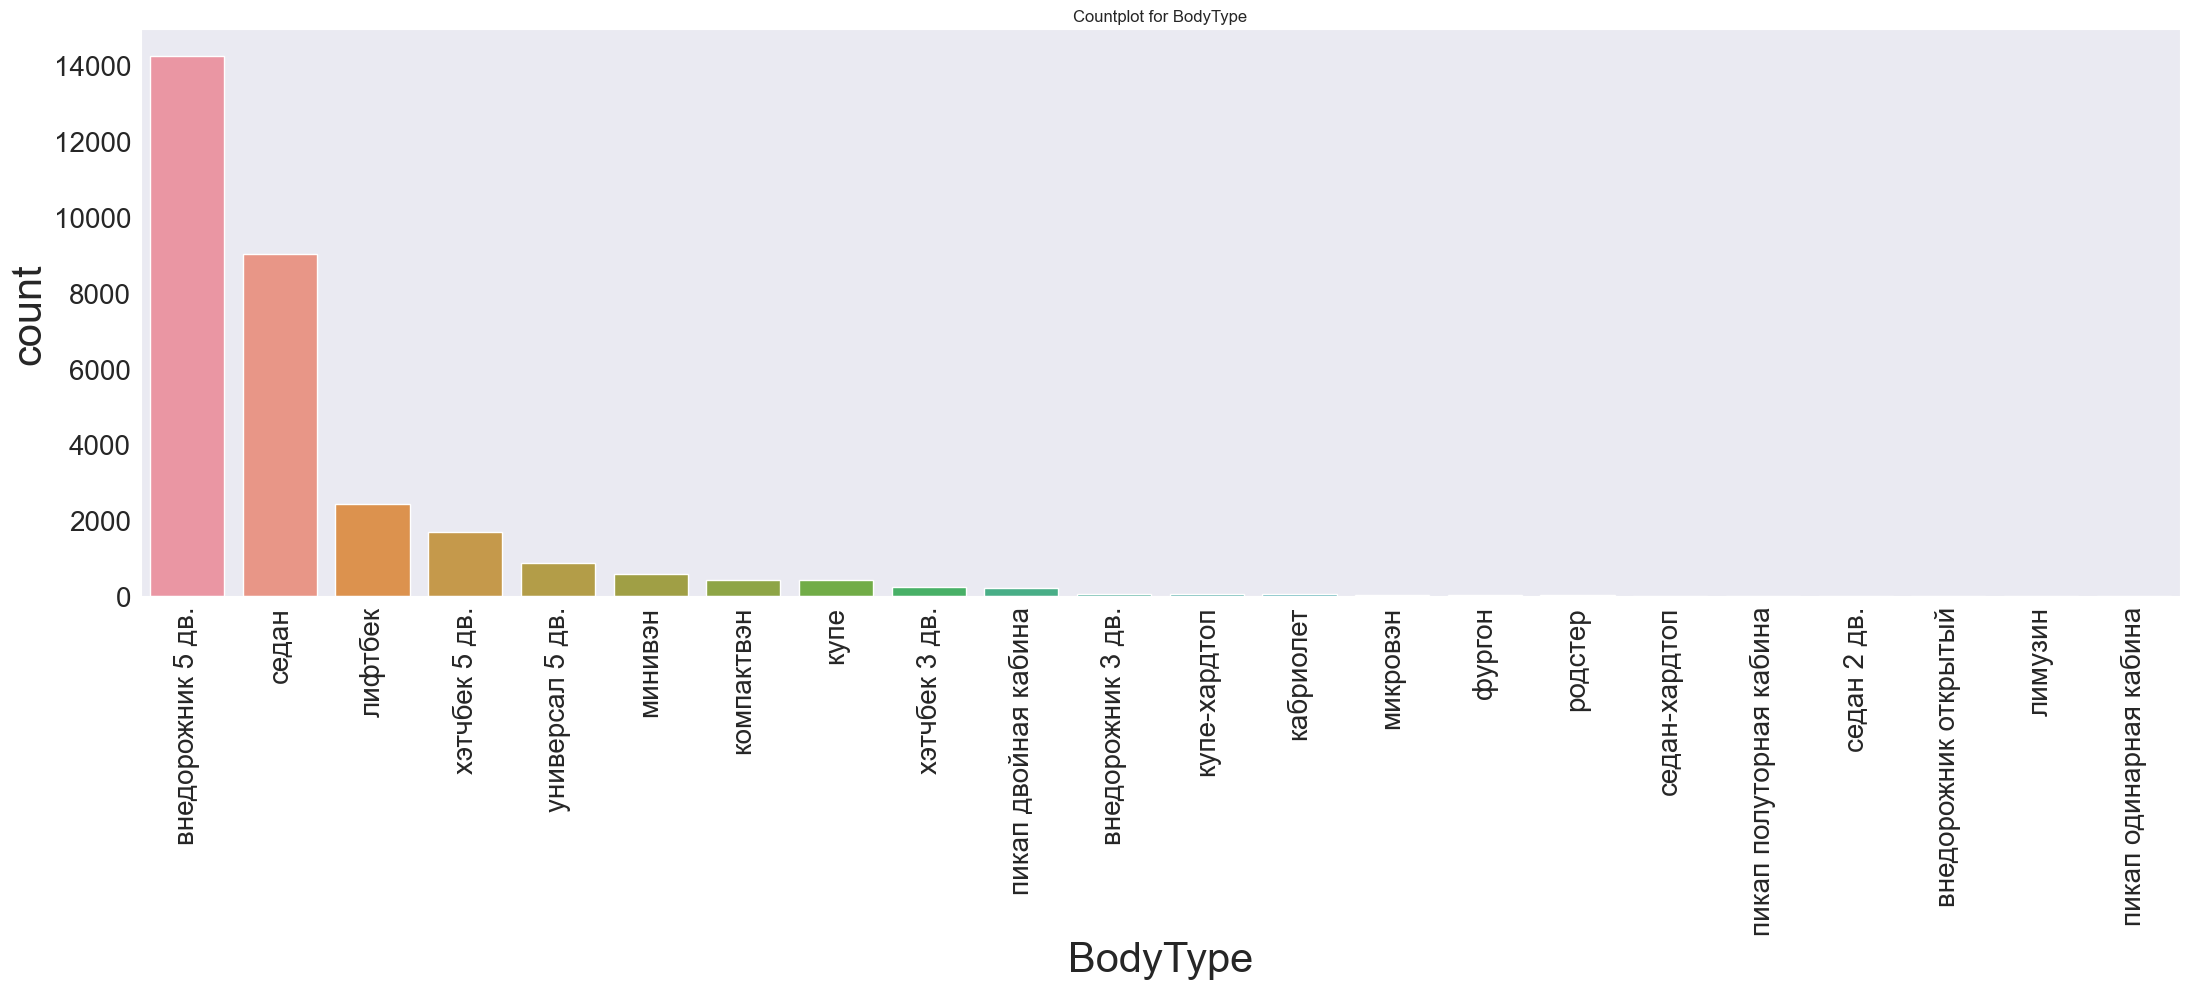

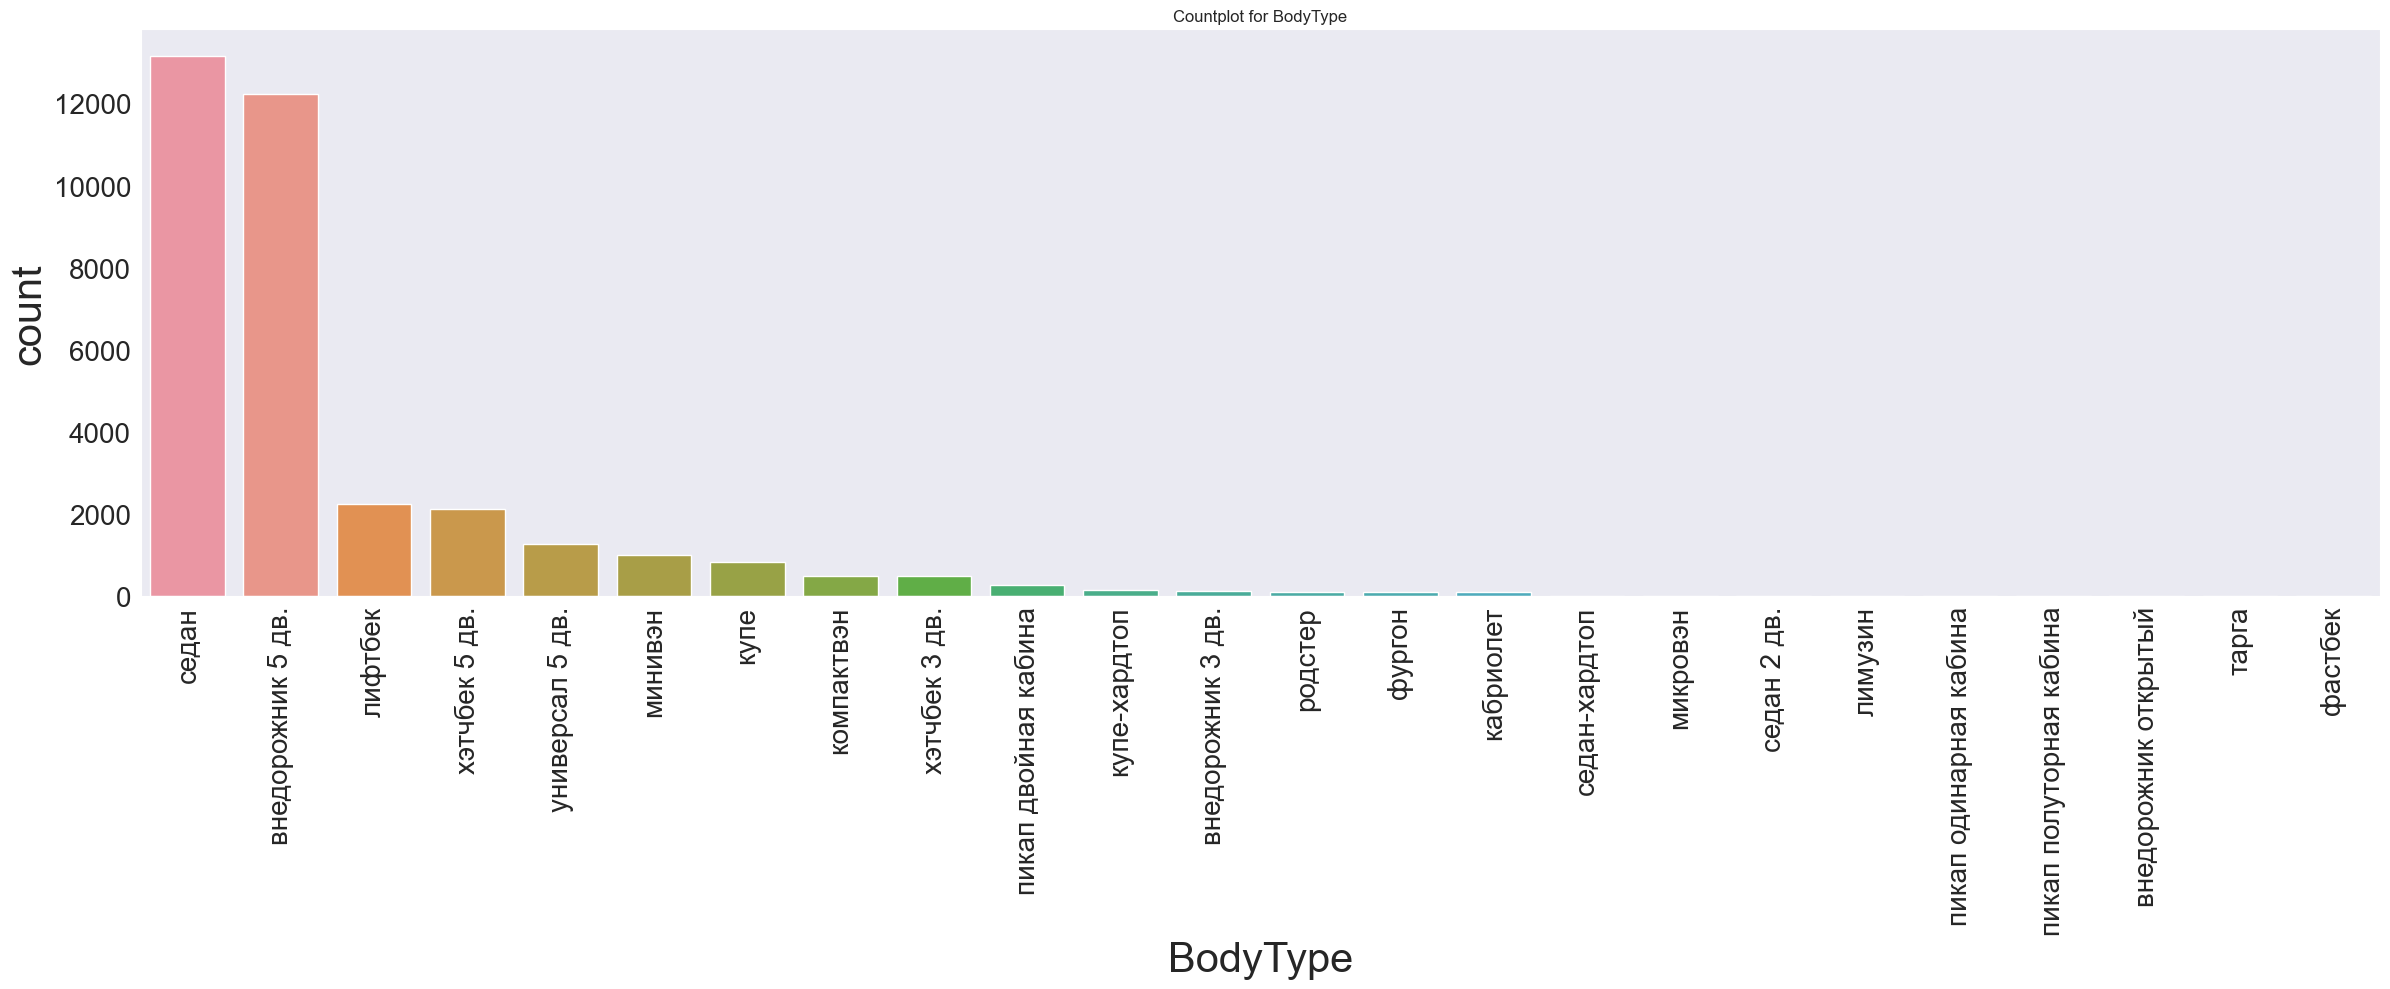

In [253]:
# analyze category balance for train and test
show_countplot(df_train, 'BodyType', ordering=True)
show_countplot(df_test, 'BodyType', ordering=True)

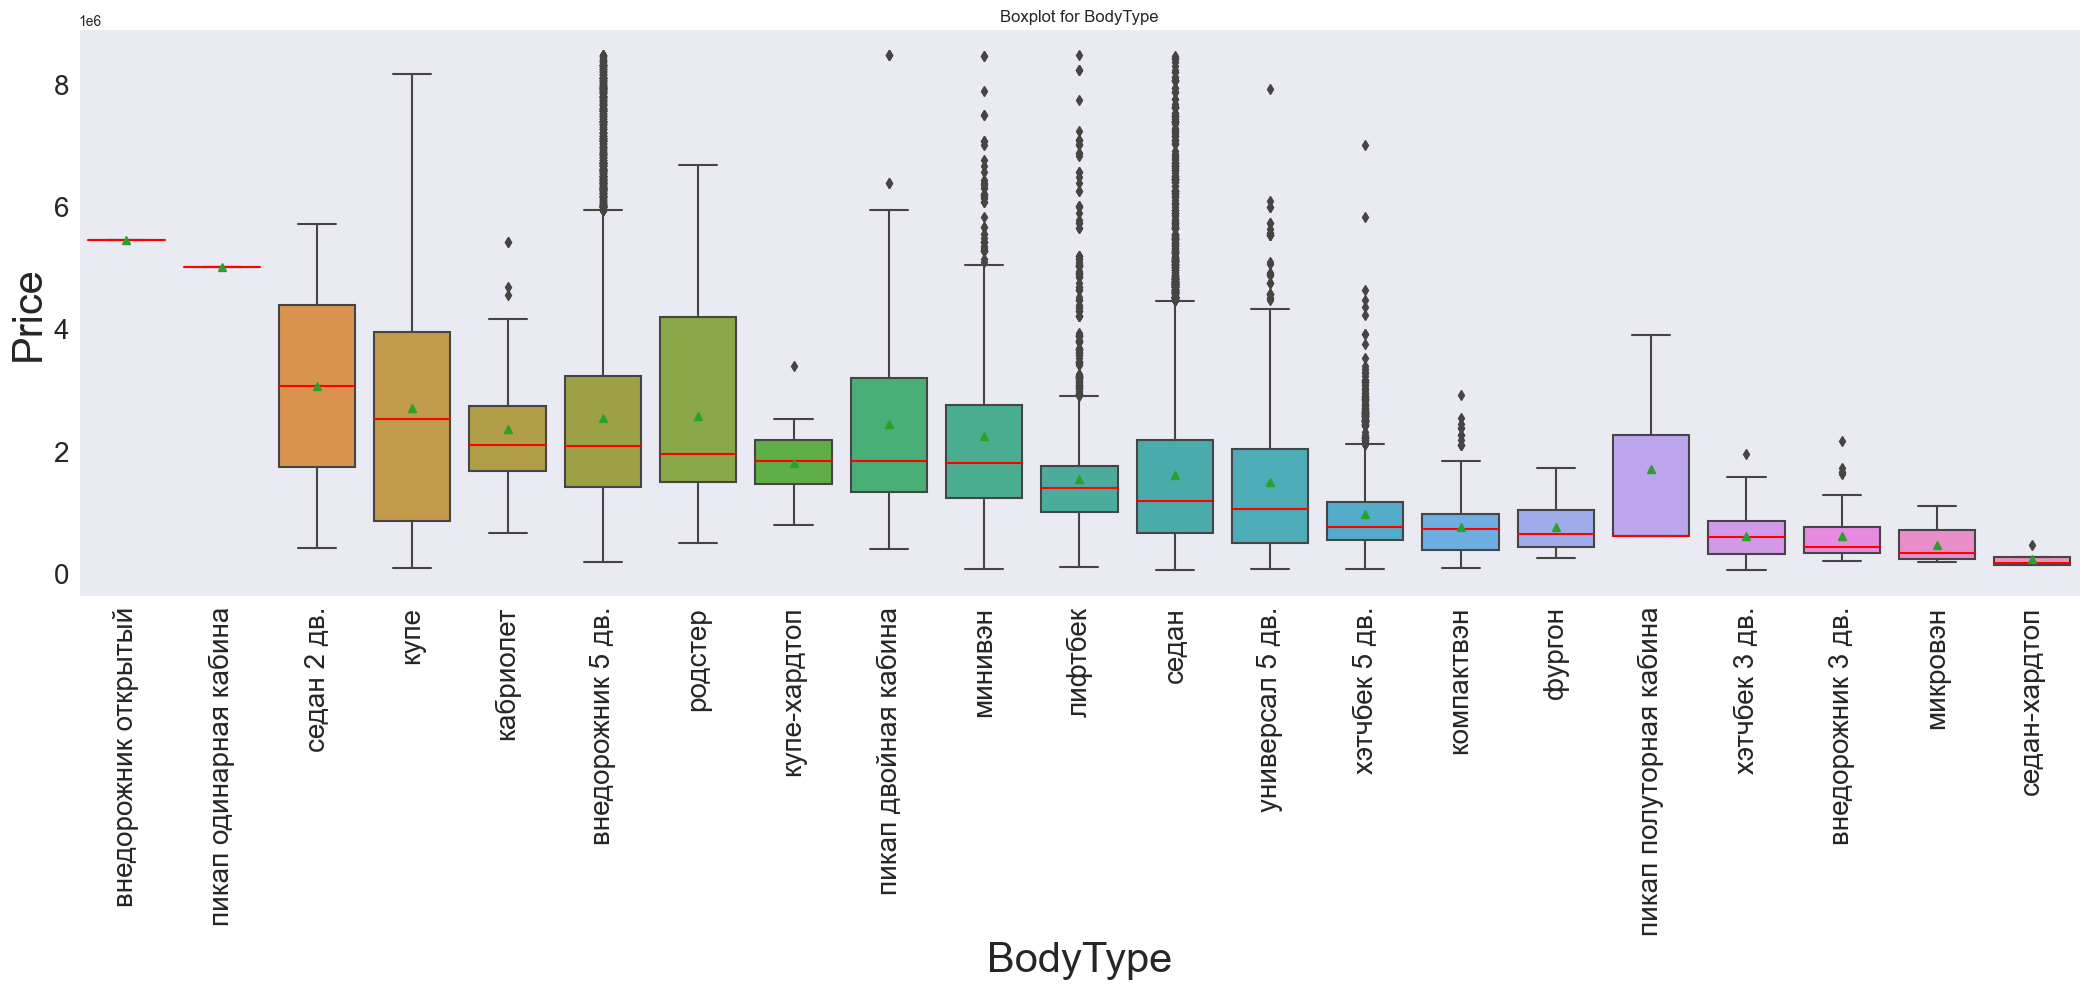

In [254]:
# and boxplots for target
# there are some extreme values in Price column, so use quantile for boxplots too
show_boxplot(df_train[df_train['Price'] < df_train['Price'].quantile(0.98)],
             'BodyType', 'Price', ordering=True)

Conclusion:
Class balance is similar for train and test - it's good. Although first 2 positions of BodyType are swapped. And these first 2 positions are highly prevailed in number, but their price boxplots do not stay apart from other classes, so no need to create a new feature for just 2 most popular body types to predict price. Also we have noticeably less price for body type 'седан-хардтоп' but there are too small count for train and test - not a very good new feature.
In general boxplots of BodyType for Price showed relatively high variability - could be useful for future model.
We lack 2 body types in train compared to test ('тарга' and 'фастбек'). But it's only 3 cars among thousands.
**TODO at Preparation Stage (TODO PS)** So we should ignore them in one-hot encoding at data preparation stage for this feature.

#### 'Brand'

In [255]:
display(df_train['Brand'].value_counts(dropna=False))
display(df_test['Brand'].value_counts(dropna=False))

HONDA         3254
LEXUS         2904
AUDI          2707
NISSAN        2707
TOYOTA        2703
SKODA         2701
VOLKSWAGEN    2677
BMW           2554
MITSUBISHI    2476
MERCEDES      2239
VOLVO         2164
INFINITI      1341
Name: Brand, dtype: int64

BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
INFINITI       871
LEXUS          834
Name: Brand, dtype: int64

In [256]:
# check if train and test values are equal
set(df_train['Brand'].unique()) == set(df_test['Brand'].unique())

True

Ok. Train and test brands are equal (as we know from parsing too).

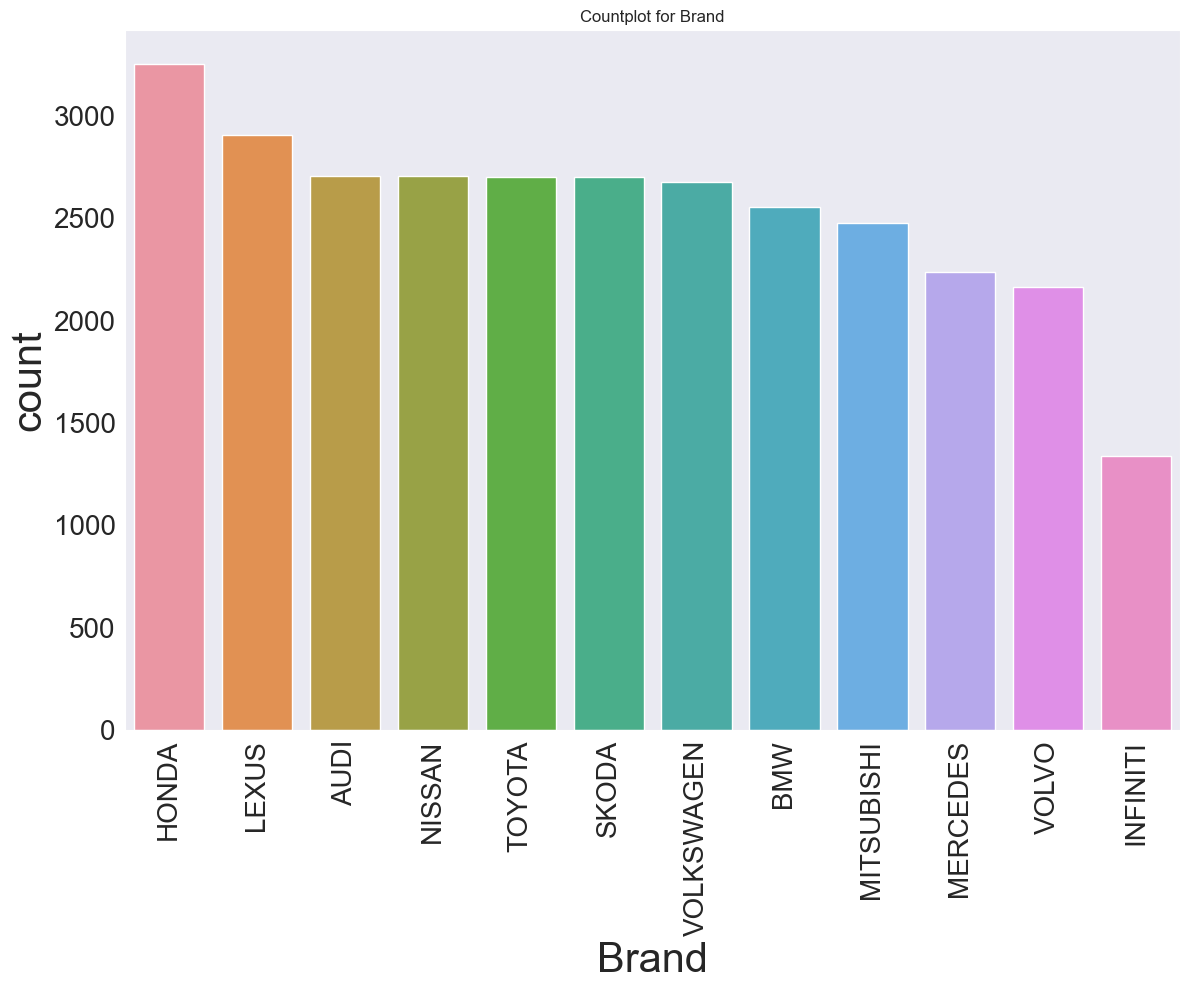

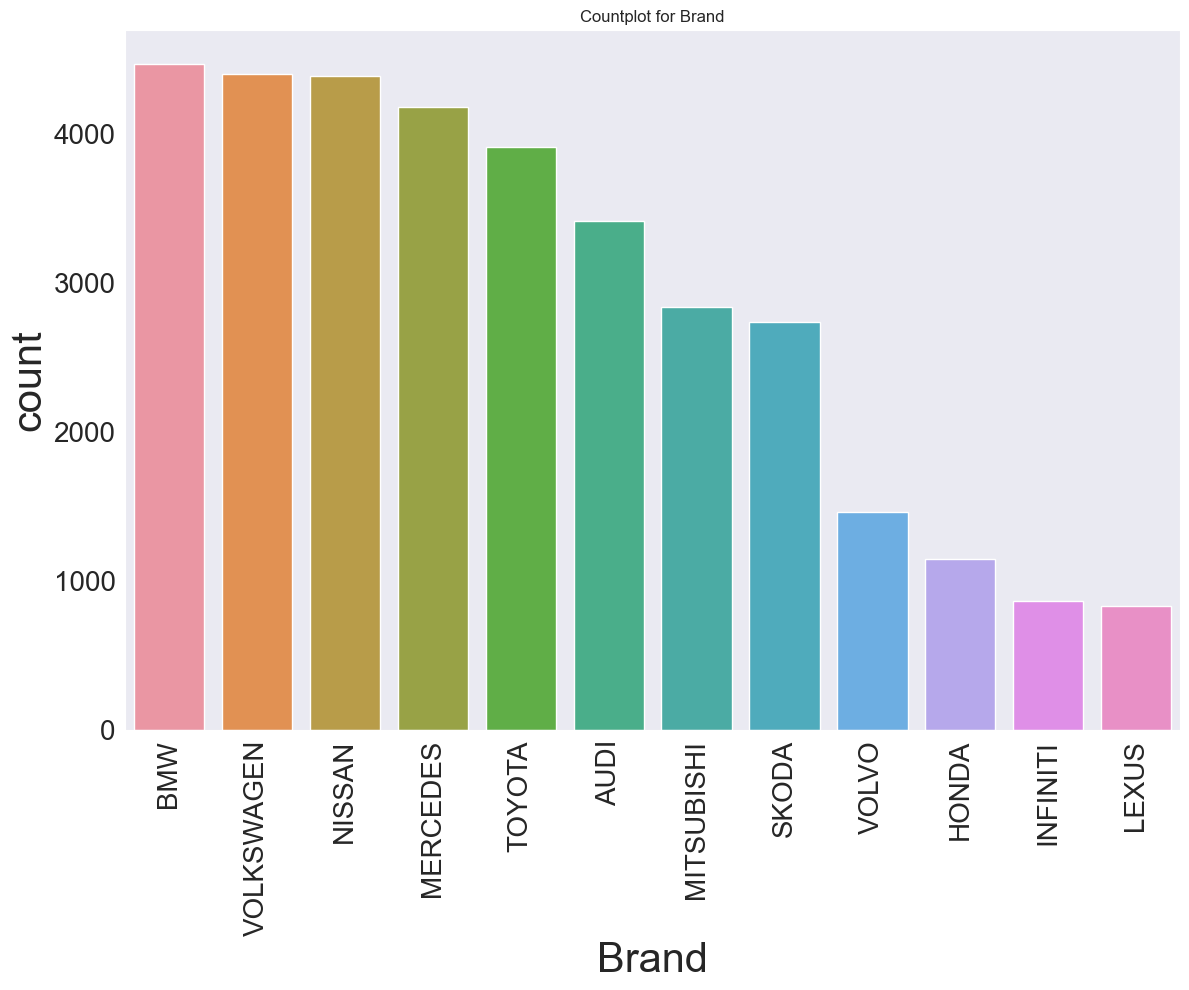

In [257]:
# analyze category balance for train and test
show_countplot(df_train, 'Brand', ordering=True)
show_countplot(df_test, 'Brand', ordering=True)

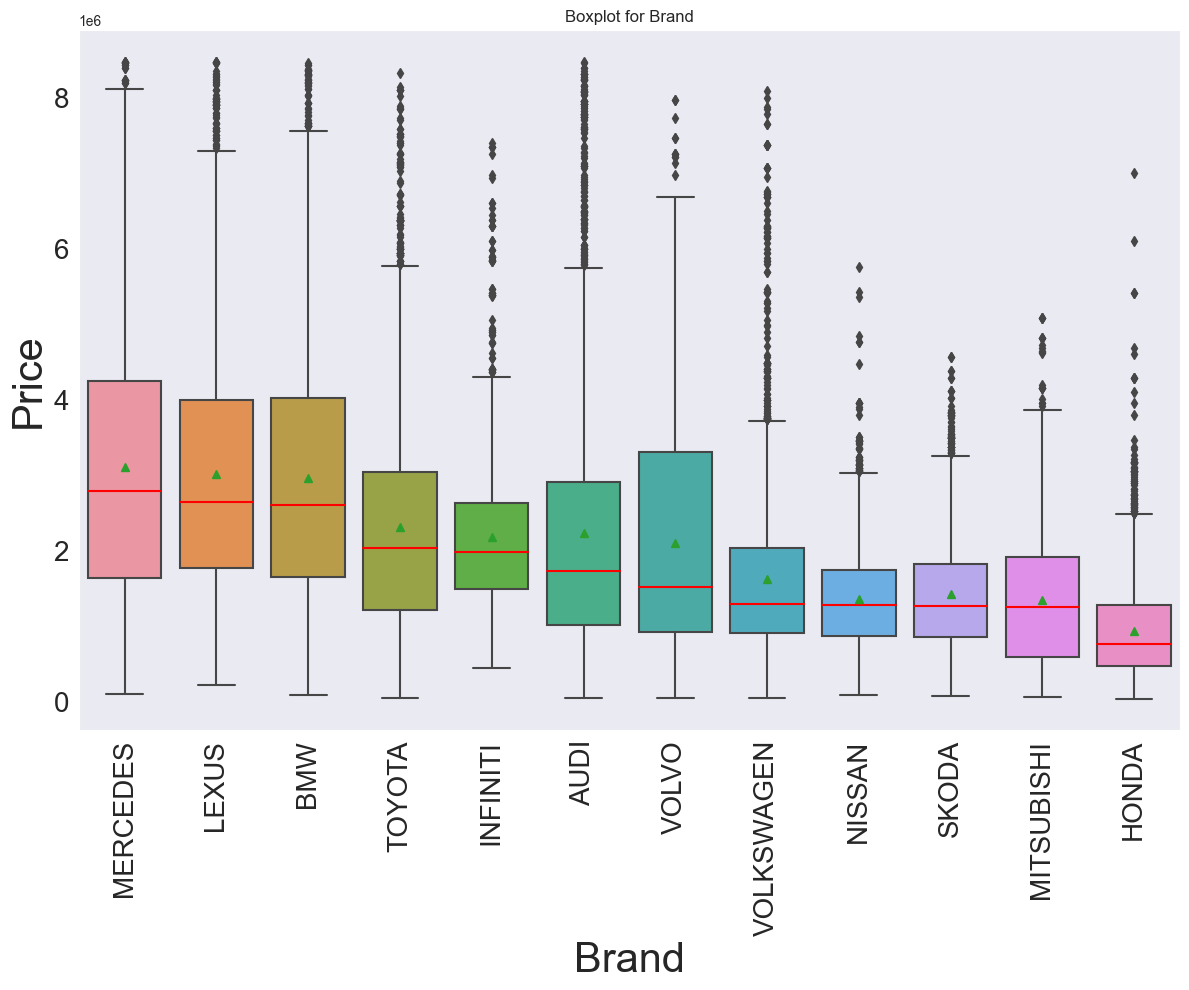

In [258]:
# and boxplots for target
# there are some extreme values in Price column, so use quantile for boxplots
show_boxplot(df_train[df_train['Price'] < df_train['Price'].quantile(0.98)], 'Brand', 'Price', ordering=True)

Conclusion:
We have comparable amount of records for different classes and for some of them train has more instances. Should be ok at training.
We can see 3 brands in top cluster by price (MERCEDES, LEXUS, BMW) and 1 in cheap cluster (HONDA)
**PNB** Maybe create features for expensive and for cheap brands.
Generally boxplots for Price showed good variability - also good for training.

In [259]:
expensive_brands = ['MERCEDES', 'LEXUS', 'BMW']
cheap_brands = ['HONDA']

#### 'Color'

In [260]:
display(df_train['Color'].value_counts(dropna=False))
display(df_test['Color'].value_counts(dropna=False))


чёрный         8532
белый          7395
серый          4291
серебристый    2798
синий          2636
коричневый     1527
красный        1303
бежевый         514
зелёный         487
голубой         276
пурпурный       179
золотистый      158
фиолетовый      120
оранжевый       105
жёлтый           93
розовый          13
Name: Color, dtype: int64

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: Color, dtype: int64

In [261]:
# check if train and test values are equal
set(df_train['Color'].unique()) == set(df_test['Color'].unique())

True

Ok. We have same colors for train and test.

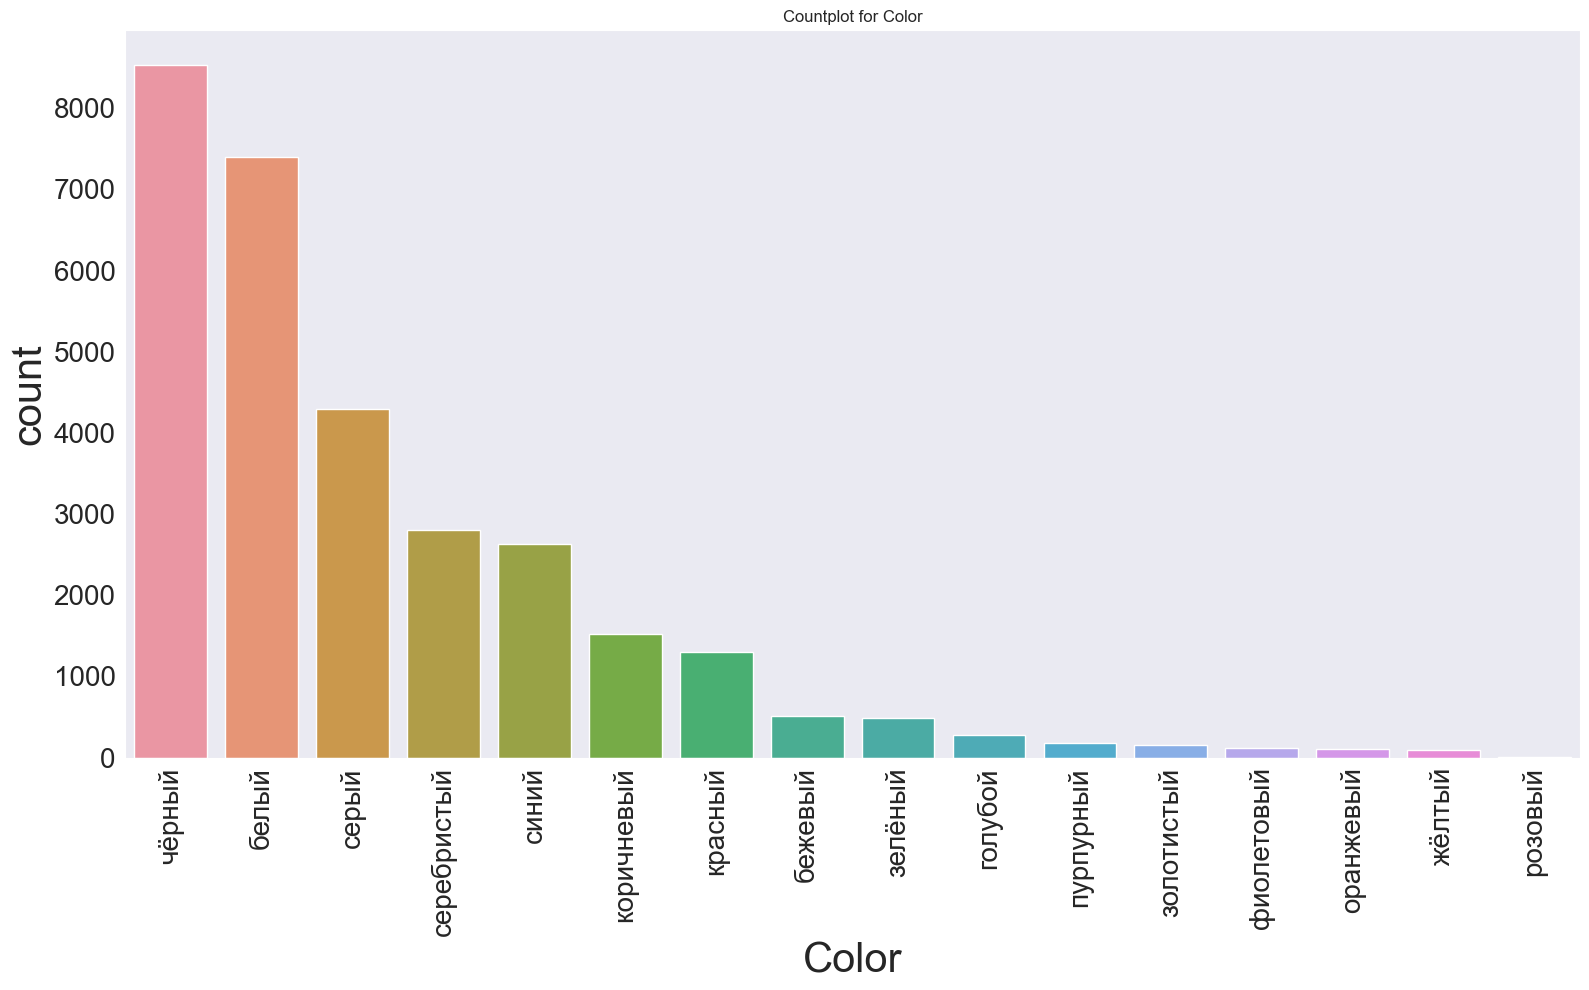

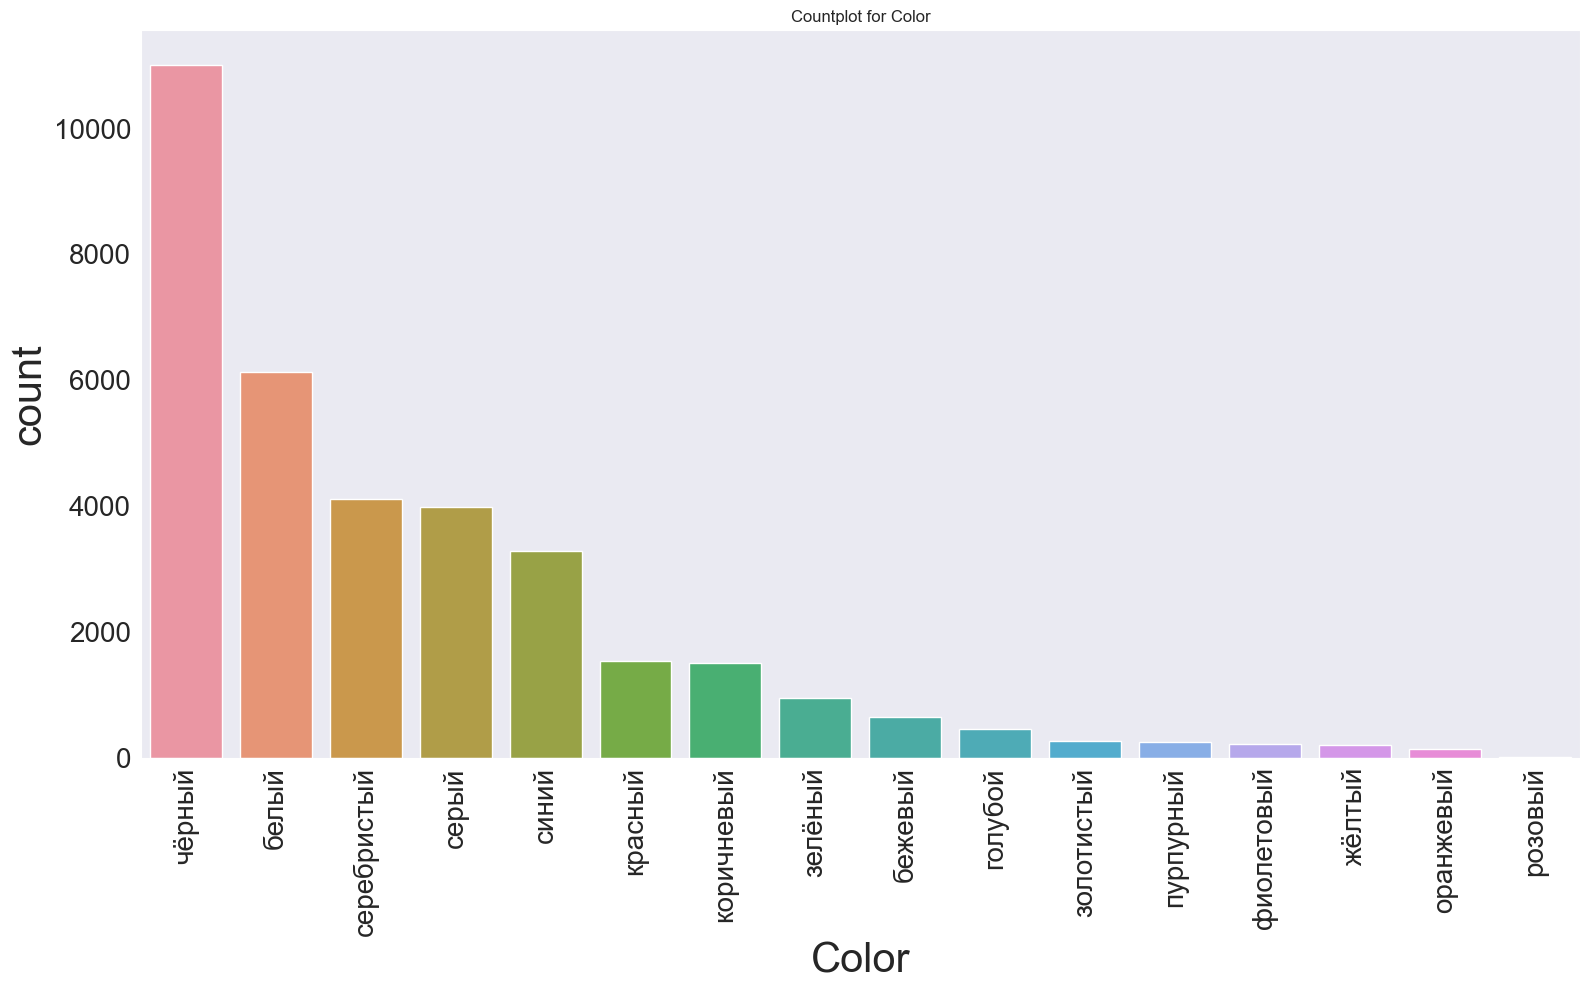

In [262]:
# analyze category balance for train and test
show_countplot(df_train, 'Color', ordering=True)
show_countplot(df_test, 'Color', ordering=True)

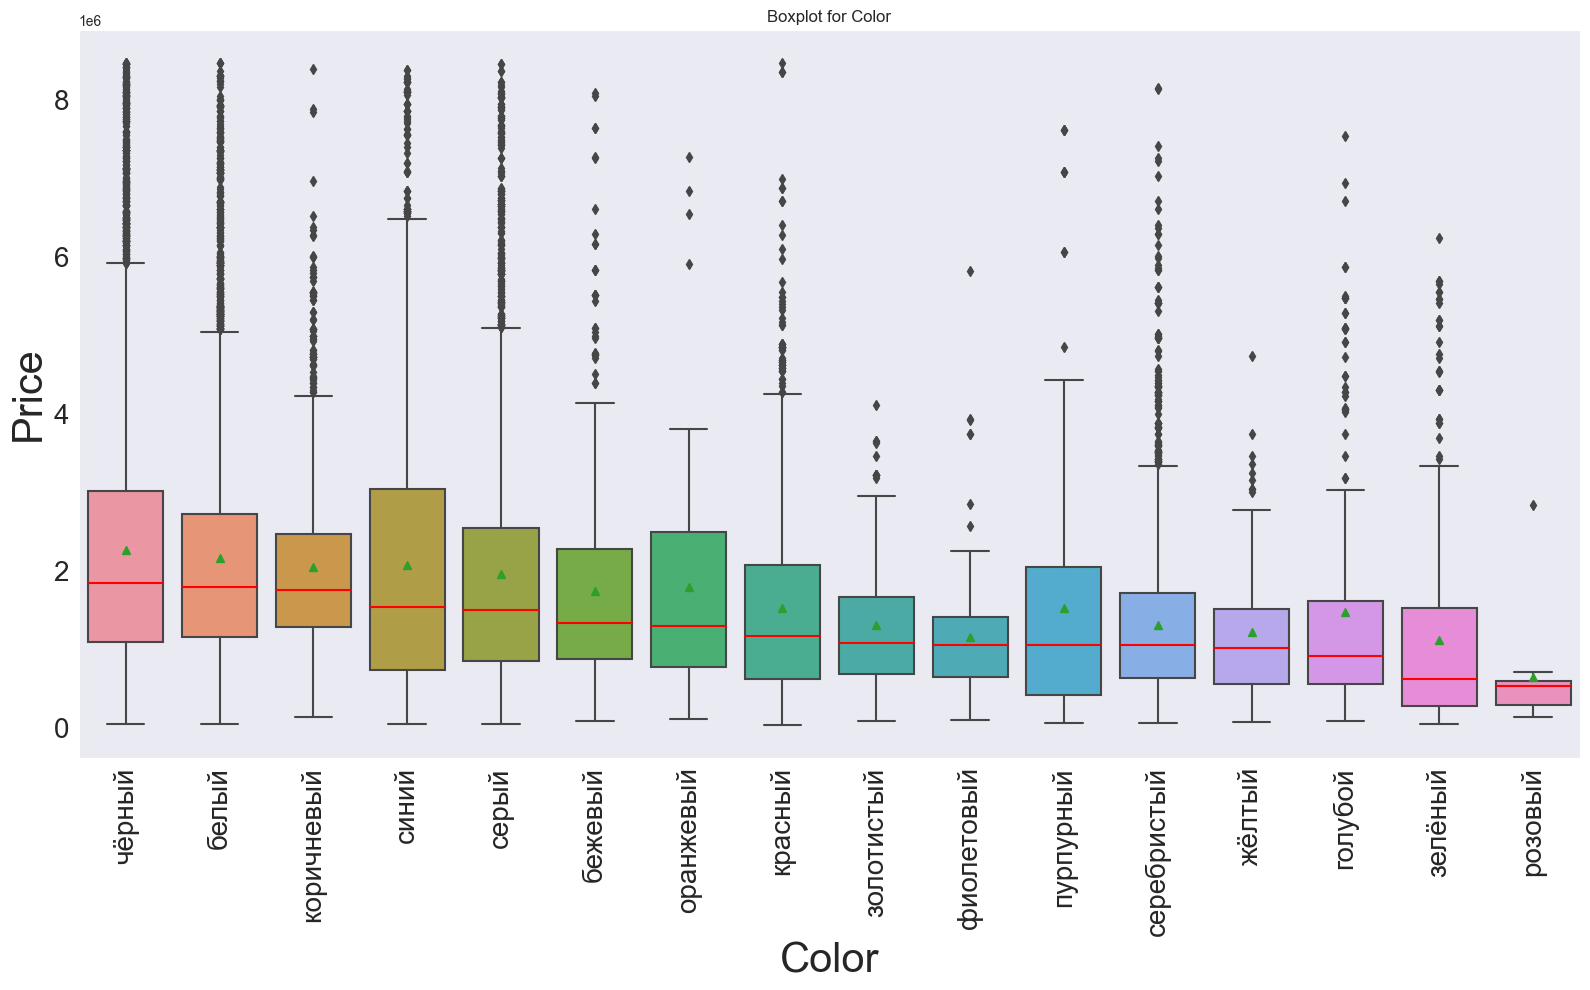

In [263]:
# and boxplots for target
# there are some extreme values in Price column, so use quantile for boxplots
show_boxplot(df_train[df_train['Price'] < df_train['Price'].quantile(0.98)], 'Color', 'Price', ordering=True)

Conclusion:
Color have very similar count distribution for train and test.
We have 2 much more popular colors - black and white, and their median prices are in top 3 high price "cluster" for color.
Also we have 3 rare and noticeably less expansive colors - green and pink.
**PNF**  Create new feature for 3 top (expensive) colors and 2 cheap colors.
Variability in price is rather good - left this feature to train on.

In [264]:
expensive_colors = ['чёрный','белый','коричневый']
cheap_colors = ['зелёный','розовый']

#### 'FuelType'

In [265]:
display(df_train['FuelType'].value_counts(dropna=False))
display(df_test['FuelType'].value_counts(dropna=False))

Бензин          21296
Дизель           7431
Гибрид           1271
оборудование      232
электро           119
Газ                65
гибрид             13
Name: FuelType, dtype: int64

бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: FuelType, dtype: int64

In [266]:
# correct names to be as test
df_train['FuelType'] = df_train['FuelType'].apply(str.lower)
df_train['FuelType'].unique()

array(['бензин', 'дизель', 'газ', 'оборудование', 'гибрид', 'электро'],
      dtype=object)

In [267]:
# We see that train has one more class than test
set(df_train['FuelType'].unique()).difference(set(df_test['FuelType'].unique()))

{'оборудование'}

In [268]:
# don't need it for training -> delete

In [269]:
df_train.drop(df_train[df_train['FuelType'] == 'оборудование'].index, inplace=True)
df_train['FuelType'].unique()

array(['бензин', 'дизель', 'газ', 'гибрид', 'электро'], dtype=object)

In [270]:
# check if train and test values are equal now
set(df_train['FuelType'].unique()) == set(df_test['FuelType'].unique())

True

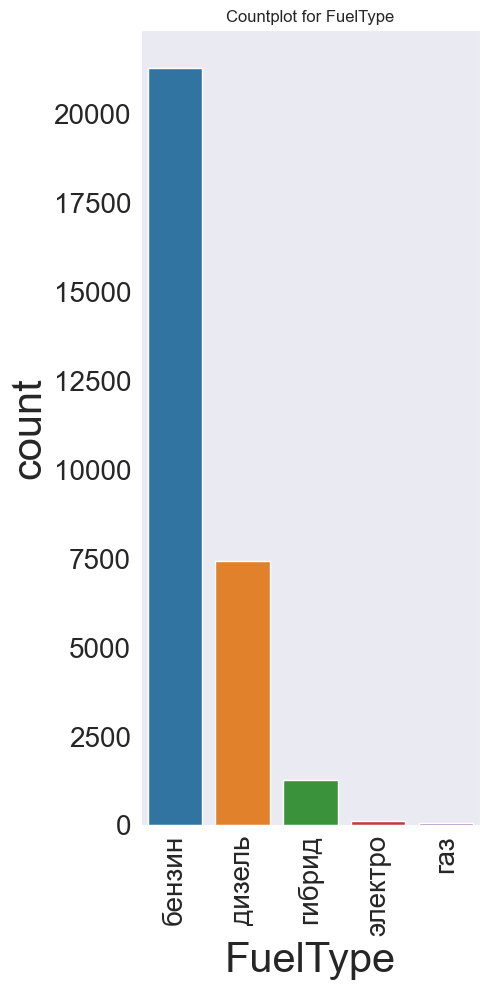

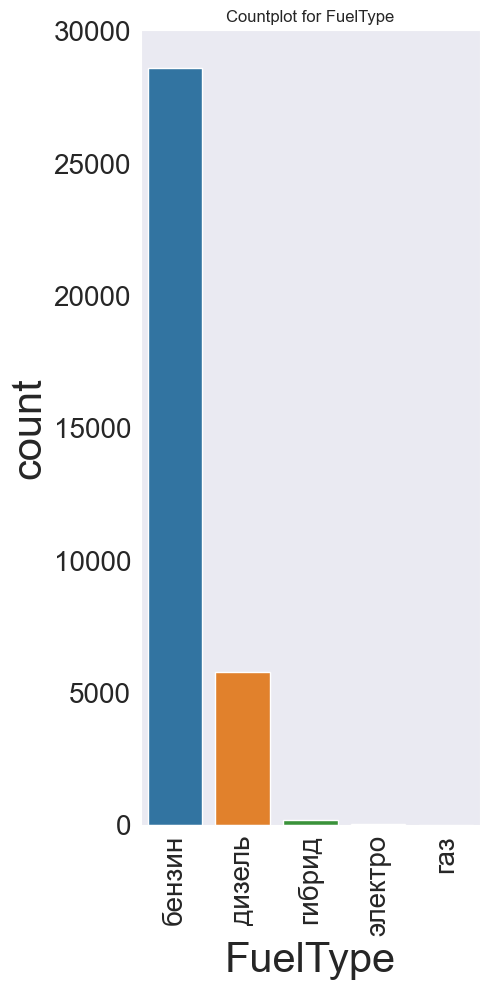

In [271]:
# analyze category balance for train and test
show_countplot(df_train, 'FuelType', ordering=True)
show_countplot(df_test, 'FuelType', ordering=True)

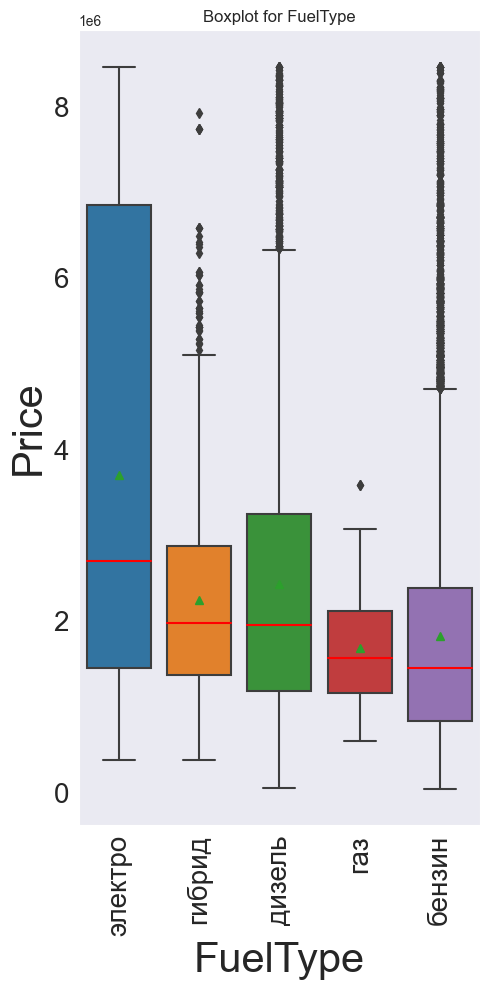

In [272]:
# and boxplots for target
# there are some extreme values in Price column, so use quantile for boxplots
show_boxplot(df_train[df_train['Price'] < df_train['Price'].quantile(0.98)], 'FuelType', 'Price', ordering=True)

Conclusion:
FuelType feature have very similar count distribution for train and test.
Electro cars is the most expensive, but there are too little of them yet.
Variability in price is rather good.

#### 'ModelName'

In [273]:
display(df_train['ModelName'].value_counts(dropna=False))
display(df_test['ModelName'].value_counts(dropna=False))

OCTAVIA       1049
RX             996
POLO           885
OUTLANDER      857
QASHQAI        788
              ... 
SAFARI           1
NADIA            1
DAYZ             1
JUKE_NISMO       1
S3               1
Name: ModelName, Length: 467, dtype: int64

OCTAVIA     1418
5ER         1026
LANCER       855
E_KLASSE     809
PASSAT       782
            ... 
MR_S           1
VELLFIRE       1
VERSO_S        1
Z3M            1
PLATZ          1
Name: ModelName, Length: 544, dtype: int64

<AxesSubplot:>

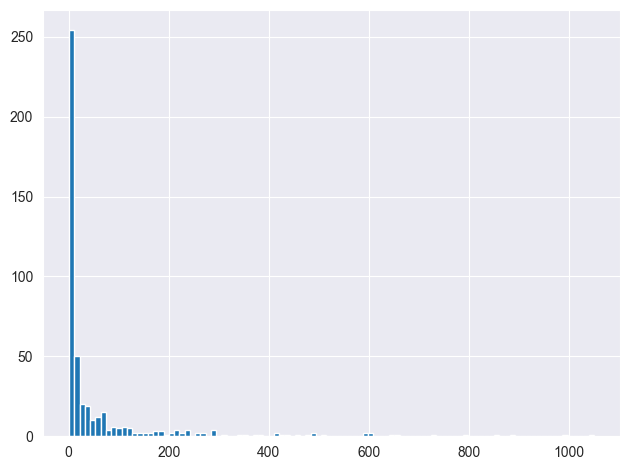

In [274]:
df_train['ModelName'].value_counts().hist(bins=100)

In [275]:
# too high cardinality and many unique/low values
# let's see at least on top part
top_part = 0.7
model_cumsum_train = df_train['ModelName'].value_counts(normalize=True).cumsum()
models_top_train = df_train['ModelName'].value_counts()[model_cumsum_train < top_part]
display(models_top_train)

model_cumsum_test = df_test['ModelName'].value_counts(normalize=True).cumsum()
models_top_test = df_test['ModelName'].value_counts()[model_cumsum_test < top_part]
display(models_top_test)

OCTAVIA               1049
RX                     996
POLO                   885
OUTLANDER              857
QASHQAI                788
RAPID                  731
TIGUAN                 658
CAMRY                  650
CR_V                   603
ACCORD                 603
X_TRAIL                598
CIVIC                  588
XC90                   513
RAV_4                  491
5ER                    491
A4                     473
A6                     456
LX                     431
XC60                   430
3ER                    418
LANCER                 410
E_KLASSE               383
ES                     376
LAND_CRUISER_PRADO     347
NX                     340
Q7                     308
Q5                     290
X5                     289
KODIAQ                 288
LAND_CRUISER           286
ASX                    267
FX                     263
COROLLA                258
PASSAT                 256
S60                    242
PAJERO                 233
X3                     233
C

OCTAVIA               1418
5ER                   1026
LANCER                 855
E_KLASSE               809
PASSAT                 782
A6                     757
3ER                    752
POLO                   724
CAMRY                  709
X5                     675
X_TRAIL                654
A4                     626
QASHQAI                609
S_KLASSE               549
OUTLANDER              544
LAND_CRUISER           514
ALMERA                 502
TIGUAN                 491
TOUAREG                469
COROLLA                456
RAV_4                  447
C_KLASSE               428
GOLF                   424
LAND_CRUISER_PRADO     387
TEANA                  374
RAPID                  370
7ER                    343
M_KLASSE               343
XC90                   340
JETTA                  324
X6                     317
CIVIC                  316
PAJERO                 306
Q7                     302
FX                     297
X3                     283
JUKE                   268
A

In [276]:
# so now we have not so many models in selected top part of all presented cars in train and test, let's analyze them
print(f'model_top_train total = {len(models_top_train)}')
print(f'model_top_test total = {len(models_top_test)}')

# compare train and test values
models_top_diff = set(models_top_train.index).symmetric_difference(set(models_top_test.index))
print(models_top_diff)
print(f'model_top_diff  len = {len(models_top_diff)}')

models_top_common = set(models_top_train.index).intersection(set(models_top_test.index))
print(models_top_common)
print(f'model_top_common  len = {len(models_top_common)}')

model_top_train total = 53
model_top_test total = 57
{'A8', 'SUPERB', 'LX', 'PRIMERA', 'NX', 'ES', 'TRANSPORTER', 'ASX', 'QX70', 'GS', '80', 'Q3', 'ALMERA', '1ER', 'S80', 'GOLF', 'M_KLASSE', '7ER', 'GL_KLASSE', 'A5', 'MURANO', 'KODIAQ', 'FIT', 'TEANA'}
model_top_diff  len = 24
{'X5', 'X_TRAIL', 'PASSAT', 'X6', 'CR_V', 'POLO', 'Q5', 'S60', 'ACCORD', 'S_KLASSE', 'QASHQAI', 'FX', 'CIVIC', 'XC60', 'RX', 'CAMRY', 'LAND_CRUISER', 'Q7', 'COROLLA', 'LAND_CRUISER_PRADO', 'C_KLASSE', 'E_KLASSE', 'RAPID', '3ER', 'PAJERO_SPORT', 'FABIA', 'JUKE', 'TIGUAN', 'A4', 'RAV_4', 'A3', 'XC90', 'X3', 'OCTAVIA', 'PAJERO', 'LANCER', 'TOUAREG', 'JETTA', 'X1', '5ER', 'YETI', 'A6', 'OUTLANDER'}
model_top_common  len = 43


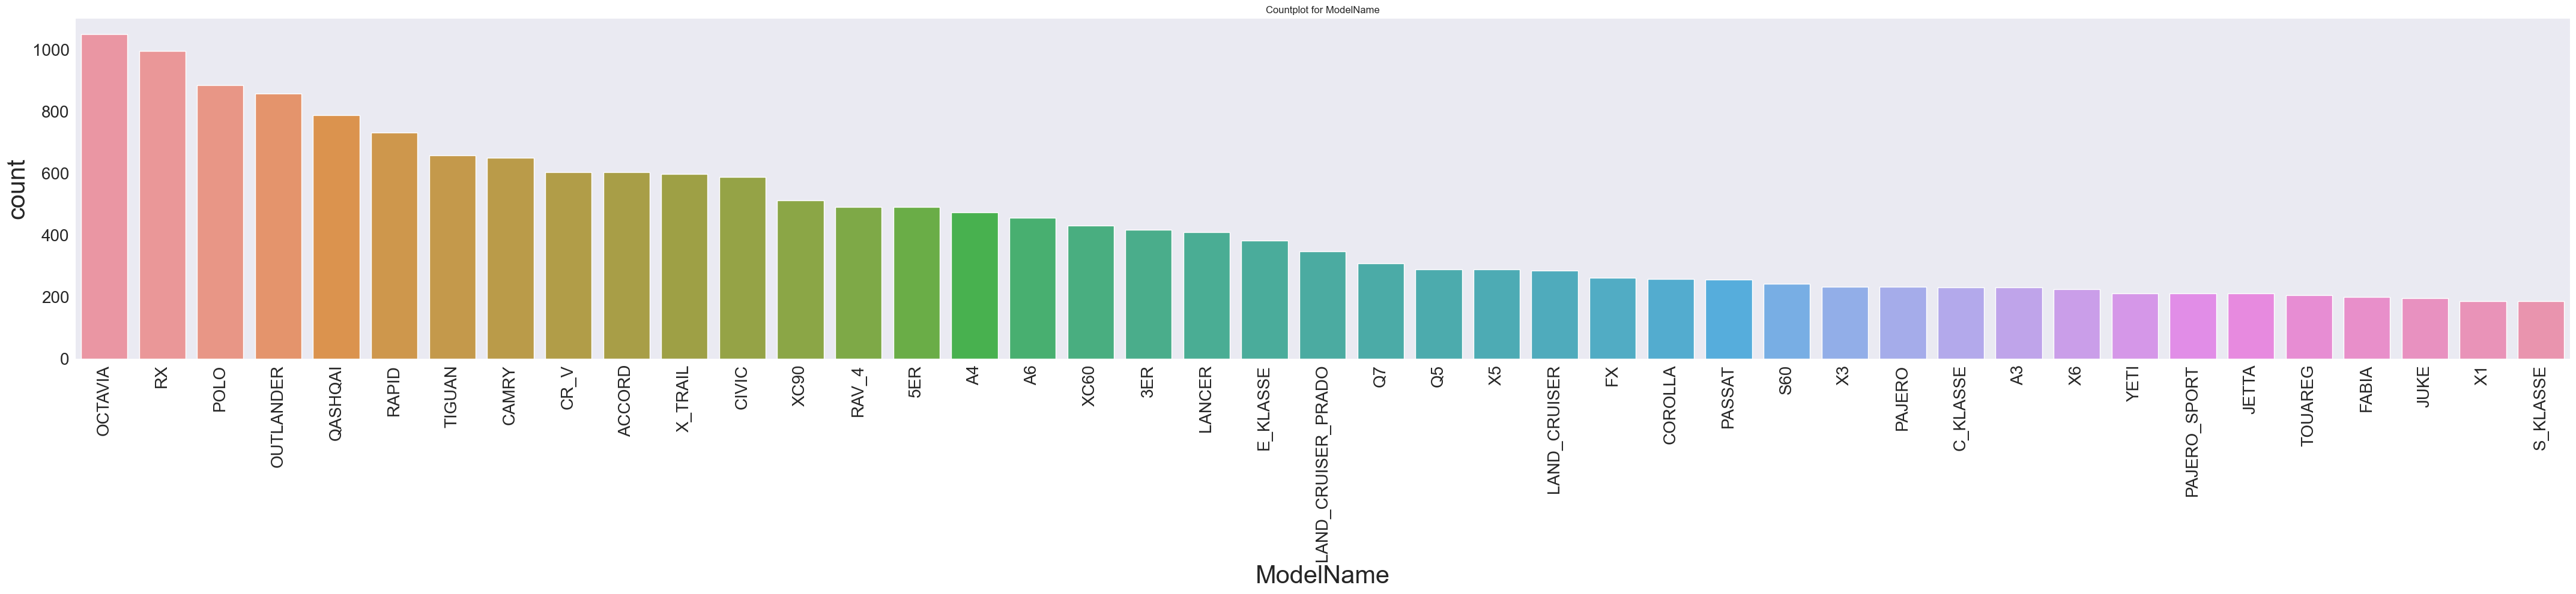

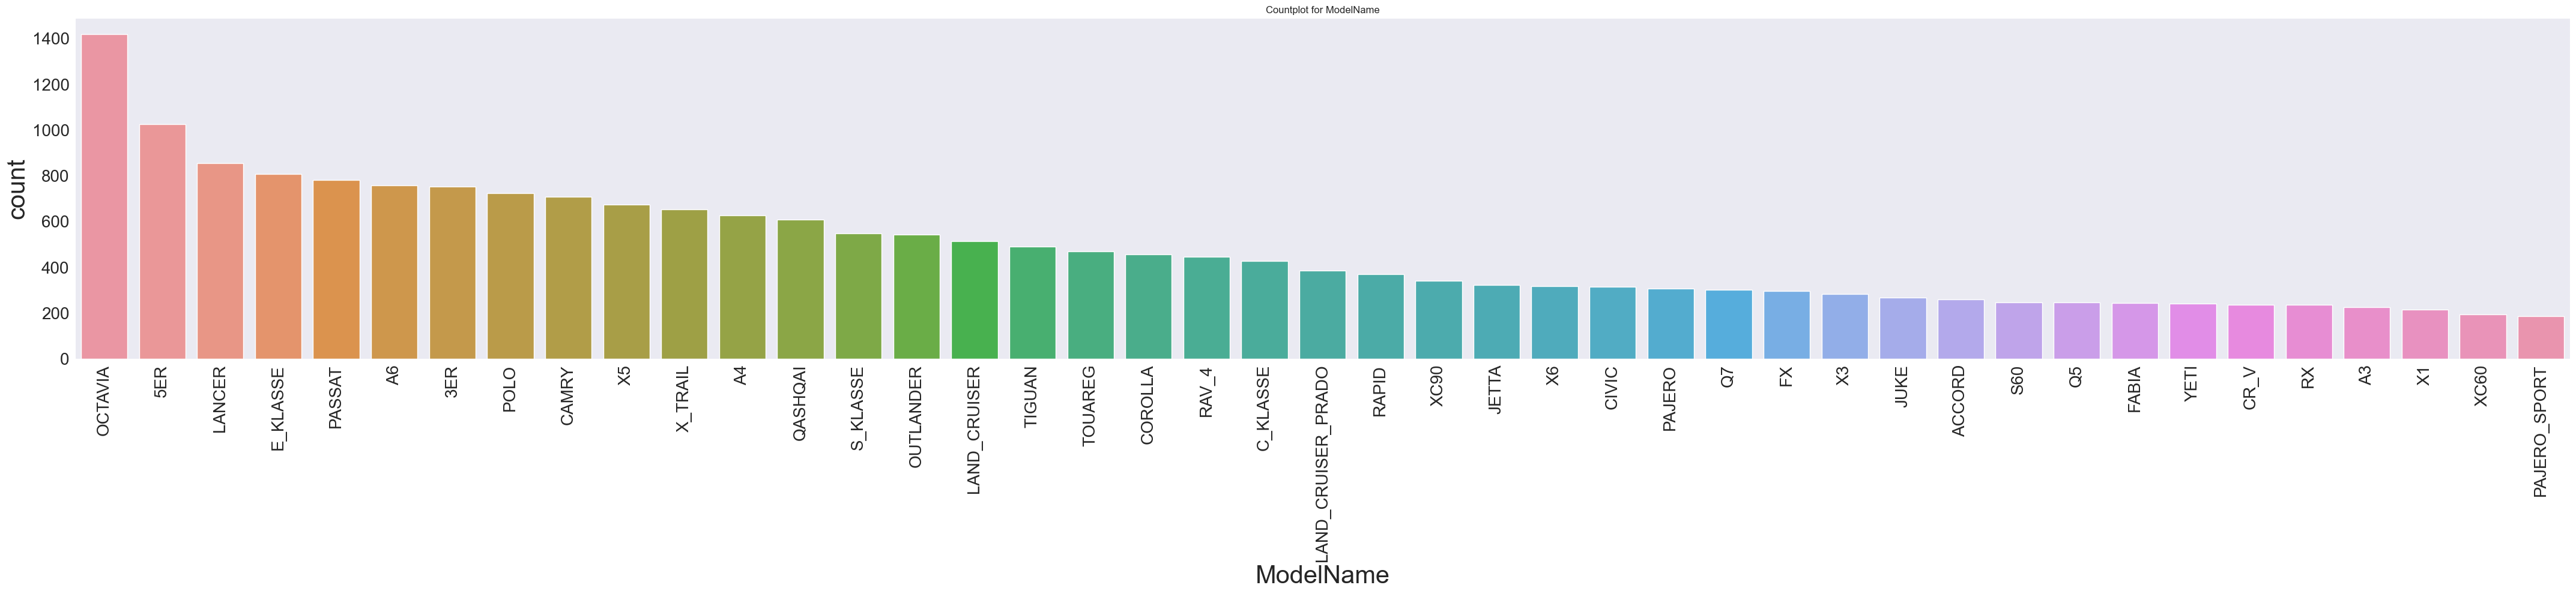

In [277]:
# analyze category balance for train and test (for common models in top part)
show_countplot(df_train[df_train['ModelName'].isin(models_top_common)], 'ModelName', ordering=True)
show_countplot(df_test[df_test['ModelName'].isin(models_top_common)], 'ModelName', ordering=True)

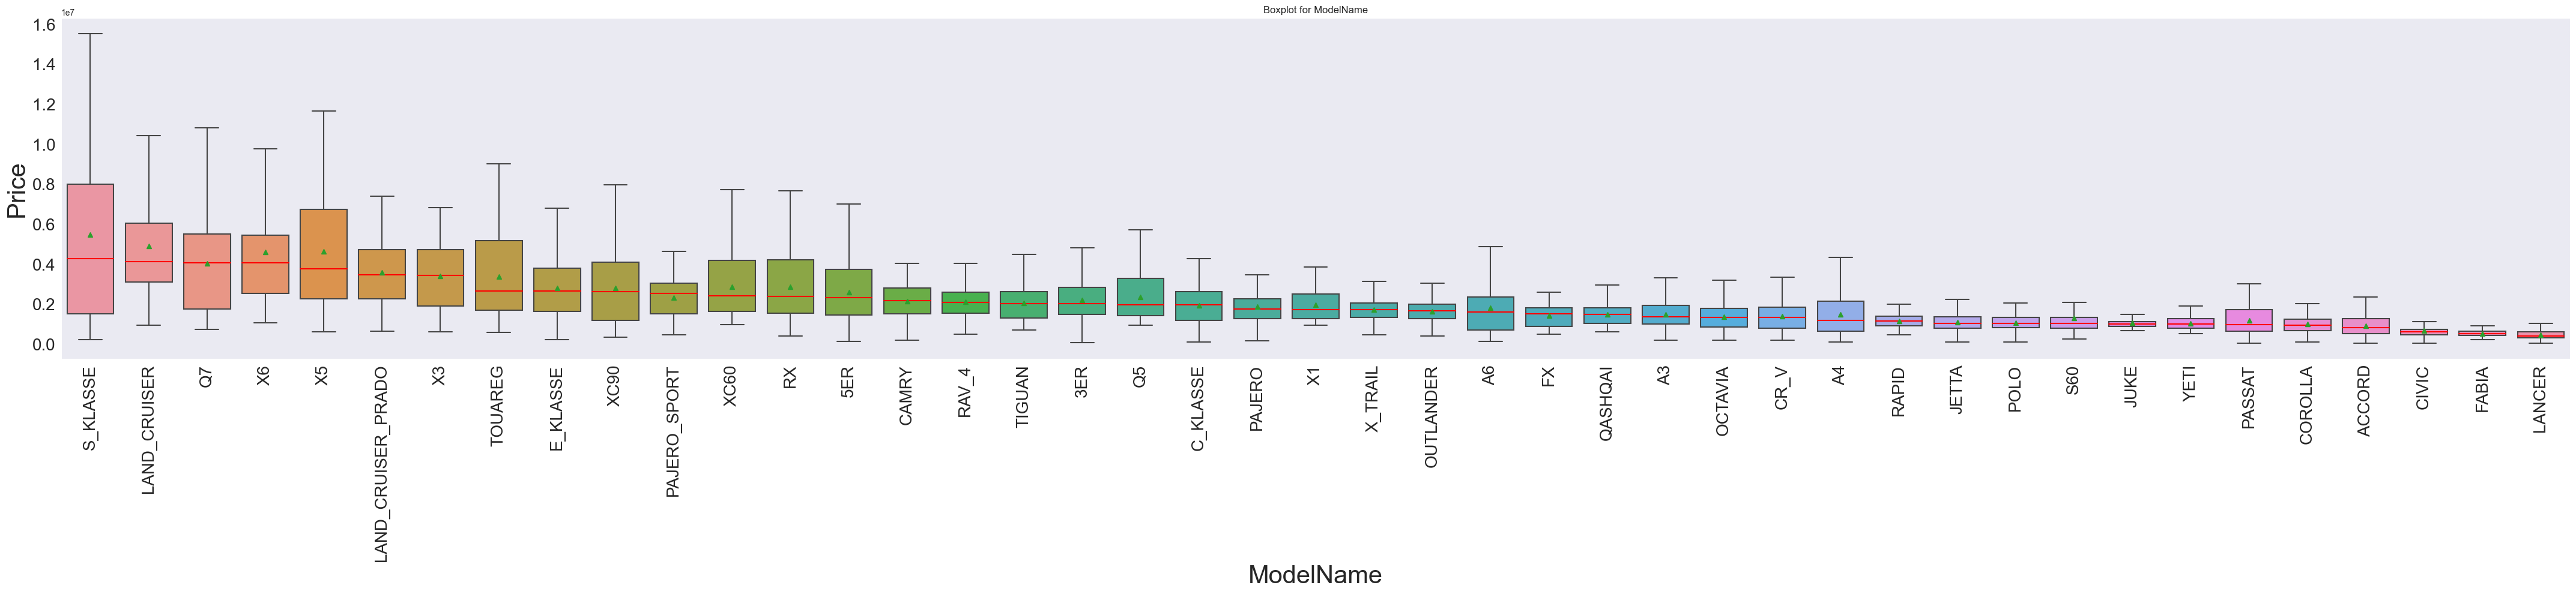

In [278]:
# and boxplots for price for the most popular cars
# there are some extreme values in Price column, so don't show outliers for this plot
show_boxplot(df_train[df_train['ModelName'].isin(models_top_common)],
            'ModelName', 'Price', ordering=True, showfliers=False)

In [279]:
# also let's see on top price part of all common models to define maybe some "clusters" of expensive models
# all common models
models_common = set(df_train['ModelName'].unique()).intersection(set(df_test['ModelName'].unique()))
print(f'Train models: {len(df_train["ModelName"].unique())}, test models: {len(df_test["ModelName"].unique())}, models in common: {len(models_common)}')

models_only_in_train = set(df_train['ModelName'].unique()) - models_common
print('Number of models only in train:')
print(df_train[df_train['ModelName'].isin(models_only_in_train)].shape[0])

models_only_in_test  = set(df_test['ModelName'].unique()) - models_common
print('Number of models only in test:')
print(df_test[df_test['ModelName'].isin(models_only_in_test)].shape[0])

Train models: 467, test models: 544, models in common: 416
Number of models only in train:
220
Number of models only in test:
469


In [280]:
# we have not so many - 220 records for models that are not in test - delete them
print(df_train.shape)
df_train.drop(labels=df_train[df_train['ModelName'].isin(models_only_in_train)].index, inplace=True)
df_train.reset_index(drop=True, inplace=True)
print(df_train.shape)

(30195, 21)
(29975, 21)


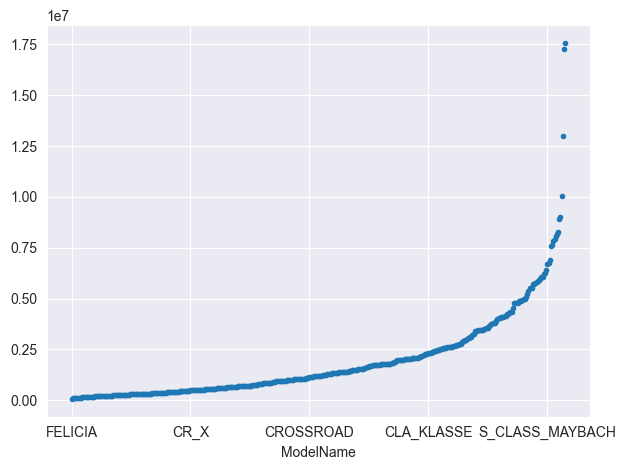

In [281]:
# plot all common models median price
model_price_medians = df_train[['ModelName', 'Price']][df_train['ModelName'].isin(models_common)].groupby(['ModelName']).median()
model_price_medians['Price'].sort_values().plot(style='.')
plt.grid(True)
plt.show()

In [282]:
# I would say that for these common models there is like a "cluster" of expensive models with prices > 7.5 M,
# so based on plots above let's define expensive models (from common models set)
# as a model with price > 7.5M and NOT too old to become valuable not because of model but because of rarity
expensive_models = list(model_price_medians[model_price_medians['Price'] > 7.5*10**6].index.unique())
print(expensive_models)
print(len(expensive_models))
df_train[df_train['ModelName'].isin(expensive_models)].shape

['8ER', 'AMG_GT', 'E_TRON', 'GLC_KLASSE_AMG', 'G_KLASSE_AMG', 'I8', 'M5', 'Q8', 'R8', 'RS6', 'S8', 'W128', 'X7']
13


(251, 21)

In [283]:
# so we have 251 really expensive models

In [284]:
# # so based on plots above let's define expensive models (from common models set)
# # as a model with price > 7.5M and NOT too old to become valuable not because of model but because of rarity
# expensive_models = df_train[df_train['ModelName'].isin(model_top_common)
#                             & (df_train['Price'] > 5*10**6)
#                             & (df_train['ProductionDate'] > RARITY_YEAR)]['ModelName']
# expensive_models.value_counts()

Conclusion:
The distribution of cars model is very diverse (~ 500 different models). Meanwhile the most of dataset (70%) can be presented with only ~50 models and we've got a glance on their price distribution.
Train and test set are rather similar (same most popular model too) and models in test are well presented in train - it's good. Models that are only in train were deleted as not useful to predict.
It was interesting to compare price dependency for most popular and most expensive car models. Expectedly most popular models are not very expensive.
On price median plot for all car models we defined a cluster for most expensive car models (13 models and 251 records). And no distinctive cluster for cheap models.
**PNF** Create a new feature for expensive models.

Besides it would be useful to define most expensive model for particular brand and for same mileage intervals and create more new features, but let's stop on this for now.

#### 'NumberOfDoors'

In [285]:
df_train['NumberOfDoors'] = df_train['NumberOfDoors'].apply(int)

In [286]:
display(df_train['NumberOfDoors'].value_counts(dropna=False))
display(df_test['NumberOfDoors'].value_counts(dropna=False))

5    19750
4     9389
2      548
3      288
Name: NumberOfDoors, dtype: int64

5    18703
4    14126
2     1206
3      650
0        1
Name: NumberOfDoors, dtype: int64

In [287]:
# only one difference for only one car (the oldest cabriolet 1904 :) )

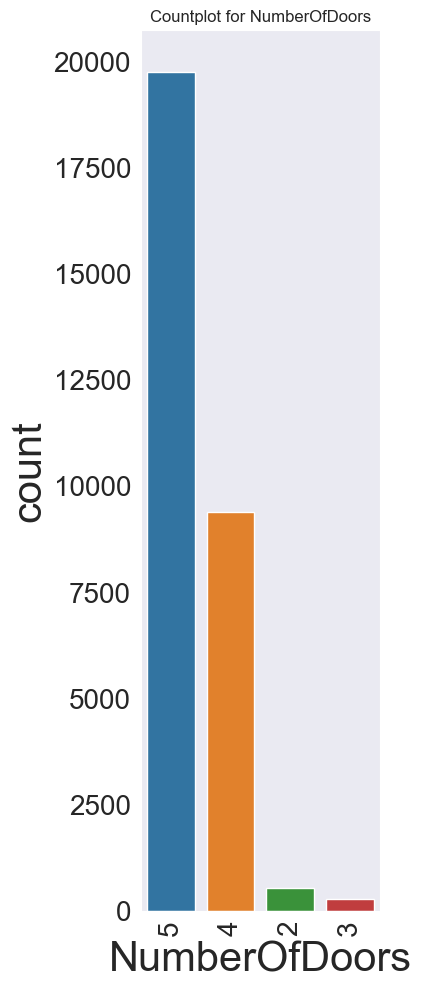

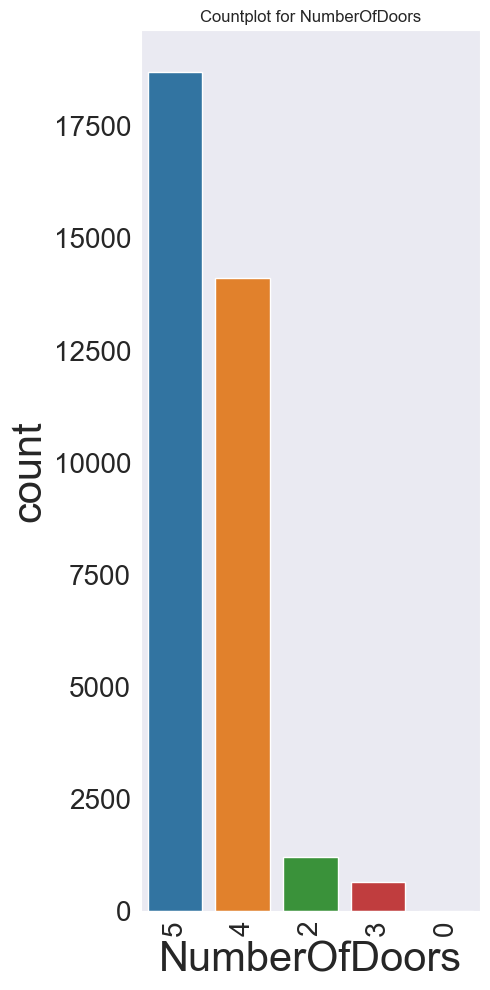

In [288]:
# analyze category balance for train and test
show_countplot(df_train, 'NumberOfDoors', ordering=True)
show_countplot(df_test, 'NumberOfDoors', ordering=True)

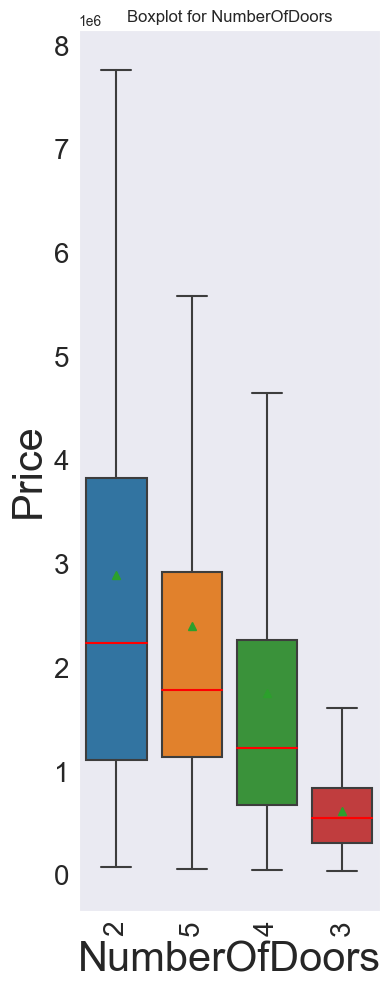

In [289]:
# and boxplots for target
# there are some extreme values in Price column, so don't show outliers for this plot
show_boxplot(df_train, 'NumberOfDoors', 'Price', ordering=True, showfliers=False)

Conclusion:
Feature have very similar values balance for train and test.
Noticeable difference in price values for every category - should be good for model.
Test in contrast to train have a car with 0 number of doors, but it is a single car - not a problem for training.
**TODO PS** So we can ignore this category in one-hot encoding for test set at data preparation stage (not include this binary feature column and all other one-hot features will be zero for this car).


#### 'VehicleTransmission'

In [290]:
display(df_train['VehicleTransmission'].value_counts(dropna=False))
display(df_test['VehicleTransmission'].value_counts(dropna=False))

автоматическая      14794
механическая         7531
вариатор             4206
роботизированная     3444
Name: VehicleTransmission, dtype: int64

автоматическая      19596
механическая         7209
вариатор             3999
роботизированная     3882
Name: VehicleTransmission, dtype: int64

In [291]:
# check if train and test values are equal
set(df_train['VehicleTransmission'].unique()) == set(df_test['VehicleTransmission'].unique())

True

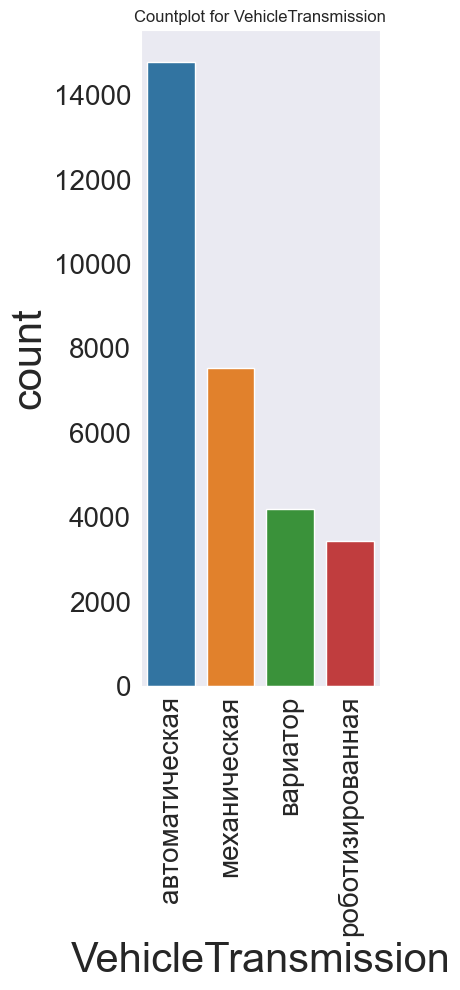

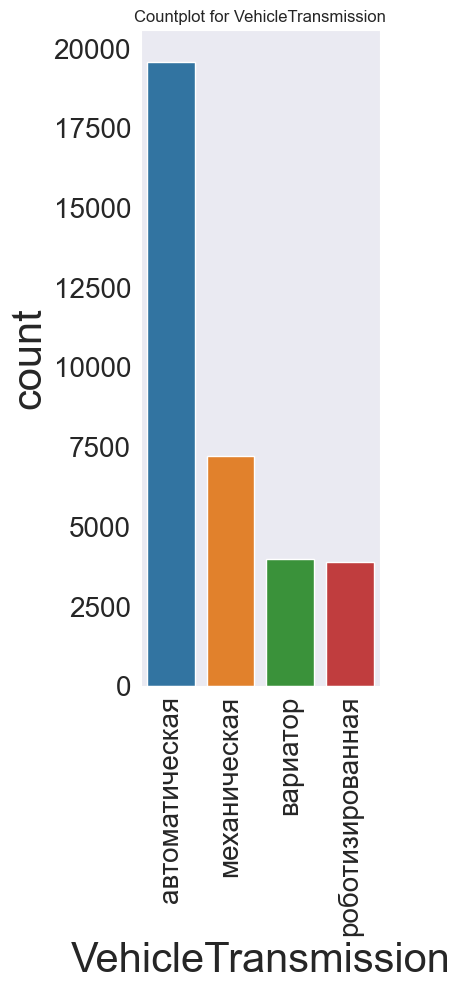

In [292]:
# analyze category balance for train and test
show_countplot(df_train, 'VehicleTransmission', ordering=True)
show_countplot(df_test, 'VehicleTransmission', ordering=True)

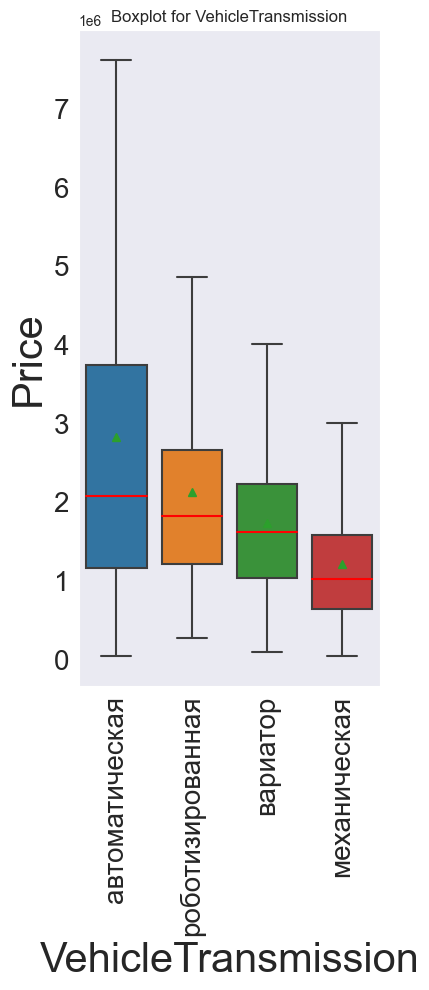

In [293]:
# and boxplots for target
# there are some extreme values in Price column, so don't show outliers for this plot
show_boxplot(df_train, 'VehicleTransmission', 'Price', ordering=True, showfliers=False)

Conclusion:
Feature have very similar values balance for train and test.
Noticeable difference in price values for every category - should be good for model.

#### 'Owners'

In [294]:
display(df_train['Owners'].value_counts(dropna=False))
display(df_test['Owners'].value_counts(dropna=False))

1 владелец     11725
3 или более    10981
2 владельца     7269
Name: Owners, dtype: int64

3 или более    15957
1 владелец      9459
2 владельца     9270
Name: Owners, dtype: int64

In [295]:
# check if train and test values are equal
set(df_train['Owners'].unique()).symmetric_difference(set(df_test['Owners'].unique()))

{'1 владелец', '1\xa0владелец', '2 владельца', '2\xa0владельца'}

In [296]:
# correct test column a bit for similarity with train
df_test['Owners'] = df_test['Owners'].apply(lambda text: text.replace(u'\xa0',' '))

In [297]:
# check if train and test values are equal now
set(df_train['Owners'].unique()) == set(df_test['Owners'].unique())

True

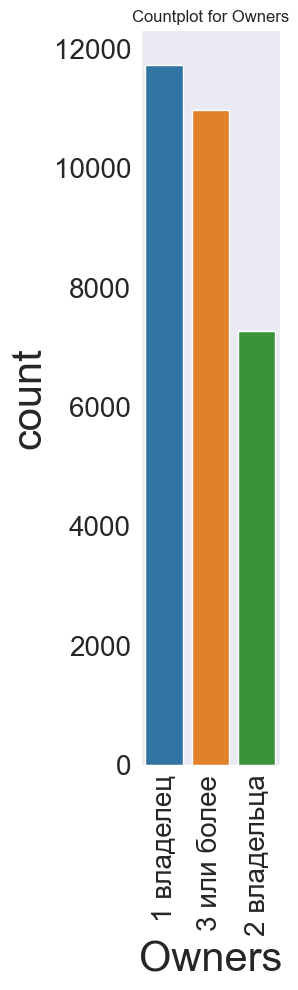

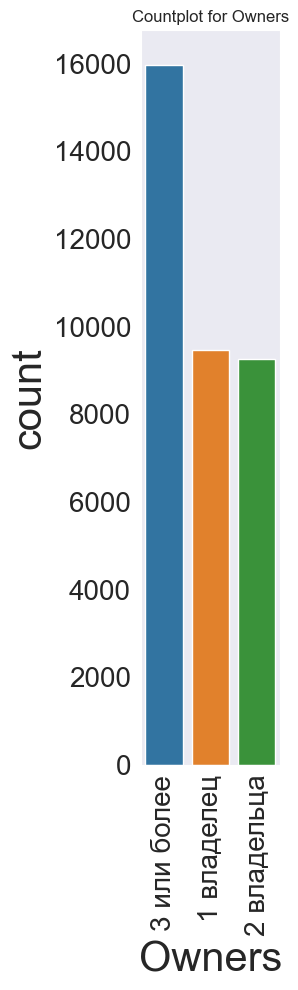

In [298]:
# analyze category balance for train and test
show_countplot(df_train, 'Owners', ordering=True)
show_countplot(df_test, 'Owners', ordering=True)

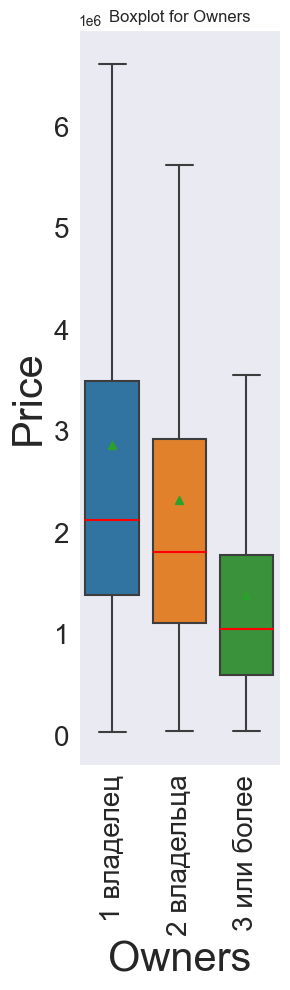

In [299]:
# and boxplots for target
# there are some extreme values in Price column, so don't show outliers for this plot
show_boxplot(df_train, 'Owners', 'Price', ordering=True, showfliers=False)

Conclusion:
Train and test sets are somewhat imbalanced, but difference is not critical.
Good price differentiation between categories and not many categories. Also we see a continuous decrease in price - maybe an argument to experiment with label encoding of this feature instead of one-hot encoding.

#### 'Drive'

In [300]:
display(df_train['Drive'].value_counts(dropna=False))
display(df_test['Drive'].value_counts(dropna=False))

полный      13923
передний    13549
задний       2503
Name: Drive, dtype: int64

передний    15565
полный      15020
задний       4101
Name: Drive, dtype: int64

In [301]:
# check if train and test values are equal
set(df_train['Drive'].unique()) == set(df_test['Drive'].unique())

True

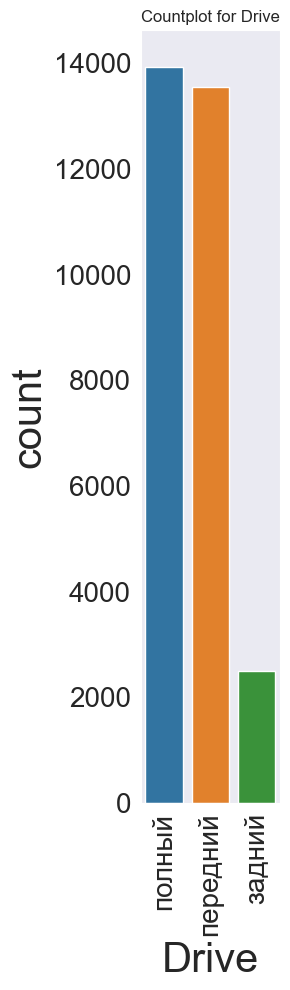

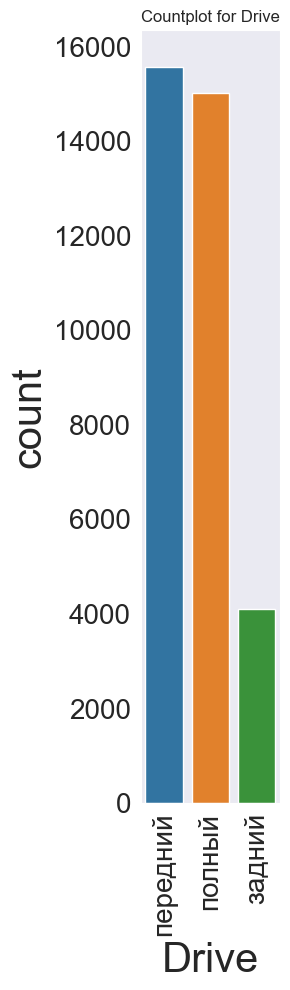

In [302]:
# analyze category balance for train and test
show_countplot(df_train, 'Drive', ordering=True)
show_countplot(df_test, 'Drive', ordering=True)

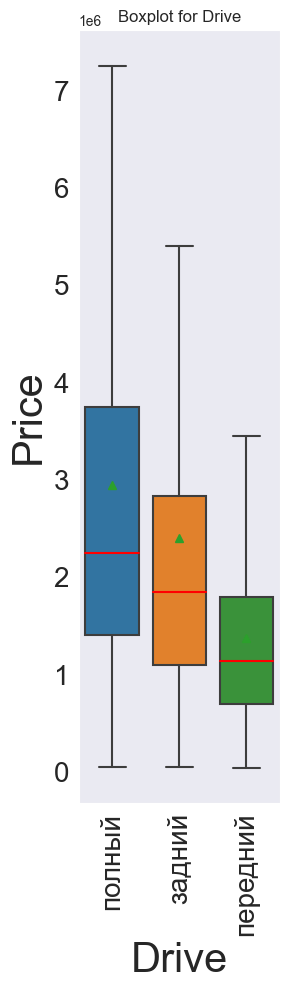

In [303]:
# and boxplots for target
# there are some extreme values in Price column, so don't show outliers
show_boxplot(df_train, 'Drive', 'Price', ordering=True, showfliers=False)

Conclusion:
Train and test balance is very similar.
Mean is noticeably greater than median for all 3 categories -> big right skewness in price for this feature.
Good price differentiation between categories and not many categories - good for one-hot encoding.
Surprisingly (for me) rear-wheel drive turned out to be more expensive.

### Binary features

#### 'Vendor'

In [304]:
display(df_train['Vendor'].value_counts(dropna=False))
display(df_test['Vendor'].value_counts(dropna=False))

NaN    29975
Name: Vendor, dtype: int64

EUROPEAN    20682
JAPANESE    14004
Name: Vendor, dtype: int64

In [305]:
# let's infer this feature for train based on information in test
brand_vendor_dict = {k:v for k,v in df_test.groupby(['Brand','Vendor']).count().index}
print(brand_vendor_dict)
df_train['Vendor'] = df_train['Brand'].map(brand_vendor_dict)
df_train['Vendor'].value_counts()

{'AUDI': 'EUROPEAN', 'BMW': 'EUROPEAN', 'HONDA': 'JAPANESE', 'INFINITI': 'JAPANESE', 'LEXUS': 'JAPANESE', 'MERCEDES': 'EUROPEAN', 'MITSUBISHI': 'JAPANESE', 'NISSAN': 'JAPANESE', 'SKODA': 'EUROPEAN', 'TOYOTA': 'JAPANESE', 'VOLKSWAGEN': 'EUROPEAN', 'VOLVO': 'EUROPEAN'}


JAPANESE    15069
EUROPEAN    14906
Name: Vendor, dtype: int64

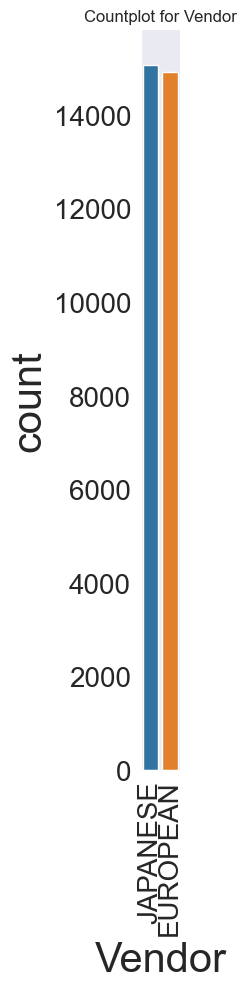

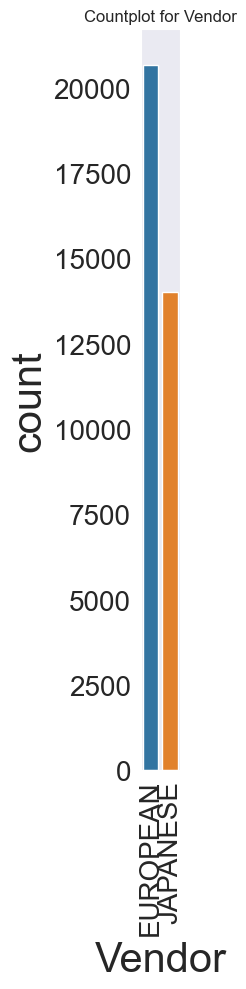

In [306]:
# analyze category balance for train and test
show_countplot(df_train, 'Vendor', ordering=True)
show_countplot(df_test, 'Vendor', ordering=True)

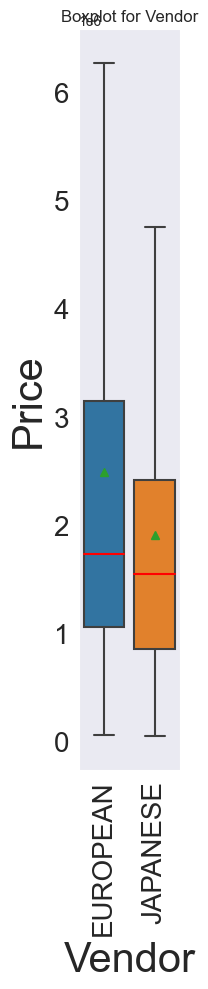

In [307]:
# and boxplots for target
# there are some extreme values in Price column, so don't show outliers
show_boxplot(df_train, 'Vendor', 'Price', ordering=True, showfliers=False)

Conclusion:
We have some unbalance in train and test, but not critical.
See some differences in boxplots. Greater IQR for European cars and Japanese cars are slightly cheaper.

#### 'PTS'

In [308]:
display(df_train['PTS'].value_counts(dropna=False))
display(df_test['PTS'].value_counts(dropna=False))

Оригинал    26348
Дубликат     3627
Name: PTS, dtype: int64

Оригинал    30098
Дубликат     4587
NaN             1
Name: PTS, dtype: int64

In [309]:
# need to fill one NaN for test. Let's see on it
df_test_orig[df_test_orig['ПТС'].isna()]['car_url']

10412    https://auto.ru/cars/used/sale/bmw/3er/3350400...
Name: car_url, dtype: object

In [310]:
# nothing special - fill it with mode - 'Оригинал'
fillna_mode(df_test, 'PTS')

In [311]:
# check if train and test values are equal
set(df_train['PTS'].unique()) == set(df_test['PTS'].unique())

True

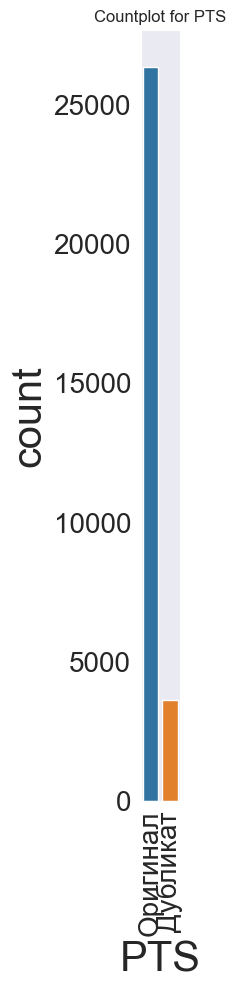

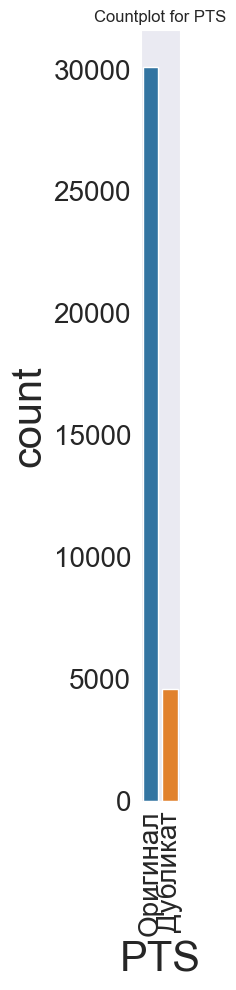

In [312]:
# analyze category balance for train and test
show_countplot(df_train, 'PTS', ordering=True)
show_countplot(df_test, 'PTS', ordering=True)

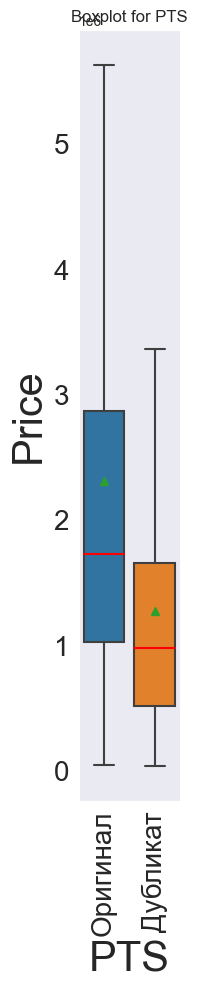

In [313]:
# and boxplots for target
# there are some extreme values in Price column, so don't show outliers
show_boxplot(df_train, 'PTS', 'Price', ordering=True, showfliers=False)

Conclusion:
Train and test balance is very similar.
Significant difference in price between values. No one want to pay for weird case of 'Дубликат'. Supposedly good feature for price prediction.

#### 'Wheel'

In [314]:
display(df_train['Wheel'].value_counts(dropna=False))
display(df_test['Wheel'].value_counts(dropna=False))

Левый     28090
Правый     1885
Name: Wheel, dtype: int64

Левый     33287
Правый     1399
Name: Wheel, dtype: int64

In [315]:
# check if train and test values are equal
set(df_train['Wheel'].unique()) == set(df_test['Wheel'].unique())

True

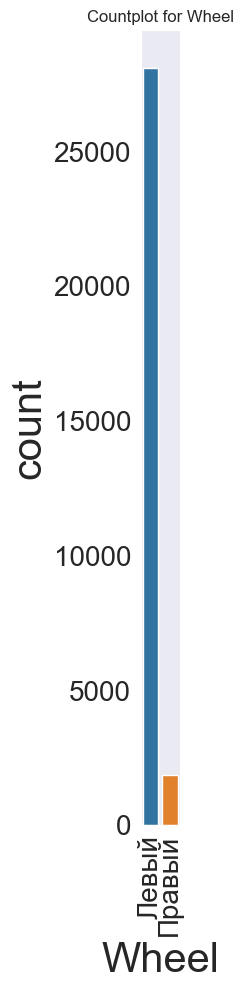

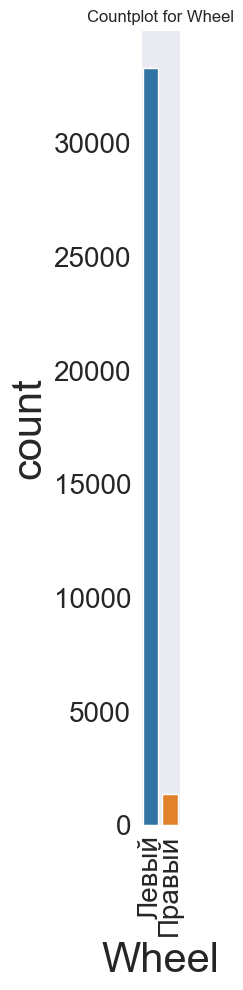

In [316]:
# analyze category balance for train and test
show_countplot(df_train, 'Wheel', ordering=True)
show_countplot(df_test, 'Wheel', ordering=True)

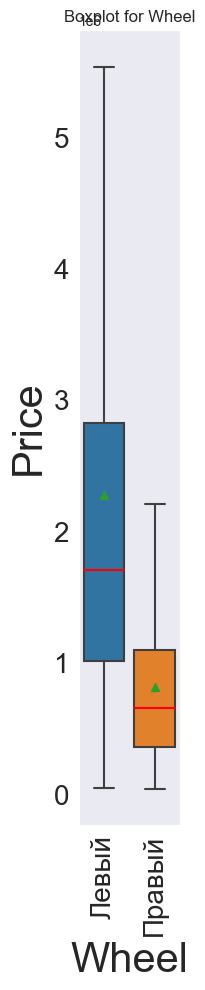

In [317]:
# and boxplots for target
# there are some extreme values in Price column, so don't show outliers
show_boxplot(df_train, 'Wheel', 'Price', ordering=True, showfliers=False)

Conclusion:
Train and test balance is similar.
Significant difference in price between values. Right-wheel cars much more cheaper and has narrower price IQR. Supposedly good feature for price prediction.

### Target feature

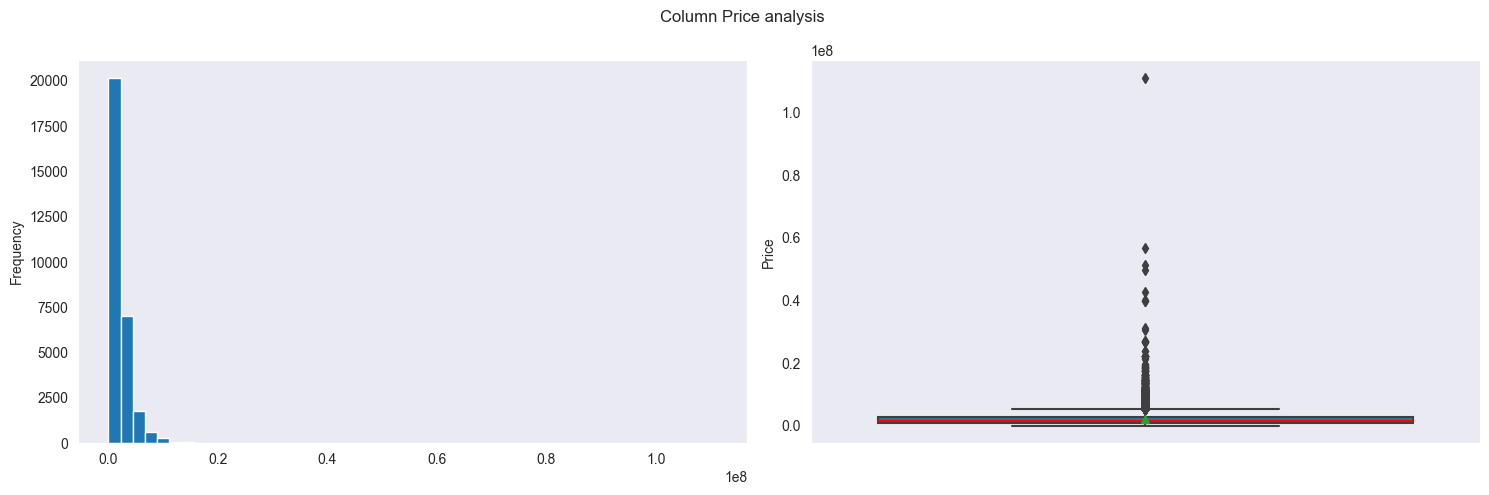

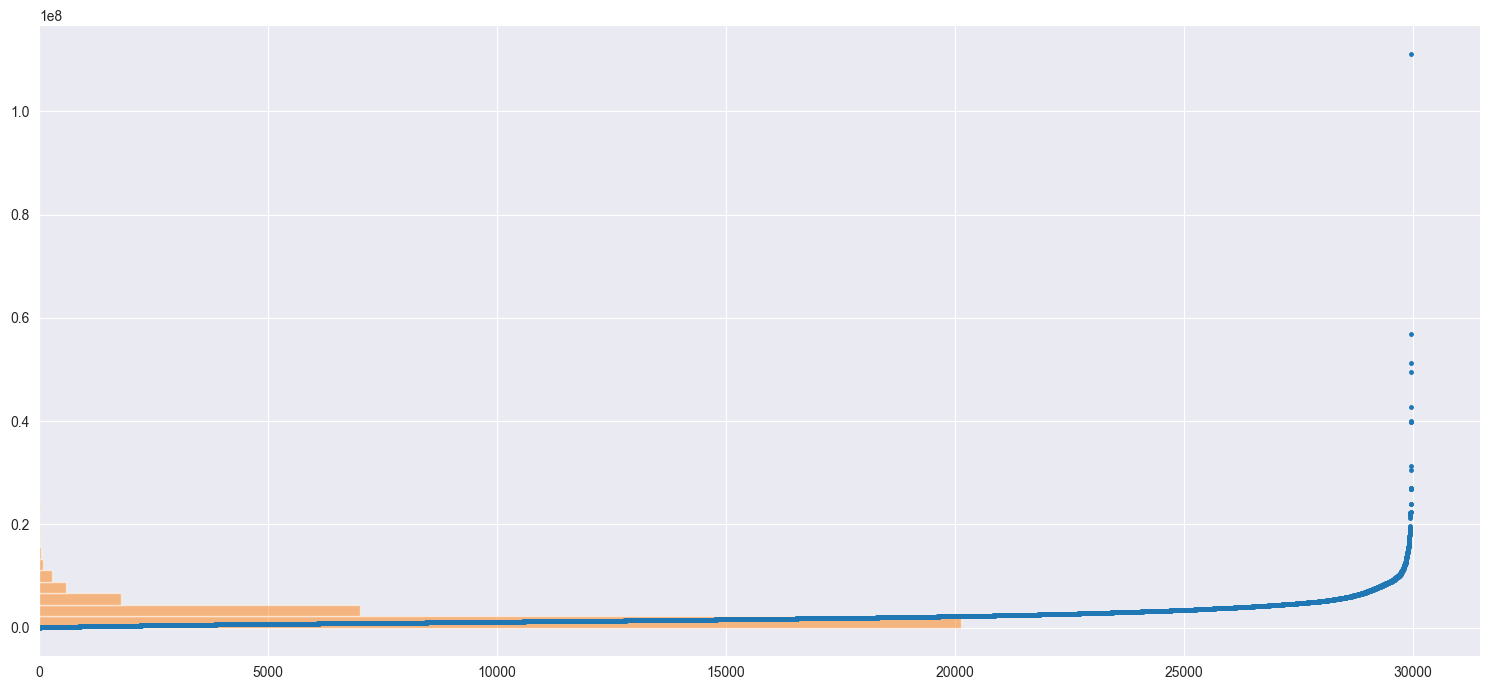

Statistics for Price column:


count                        29975.0
mean                  2190968.140117
std                   2217654.373947
min                          40000.0
25%                         950000.0
50%                        1630000.0
75%                        2700000.0
max                      111100000.0
Median                     1630000.0
Mode/Count              650000.0/152
Skewness                    8.289453
IQR                        1750000.0
Number of outliers       1811 (6.0%)
Name: Price, dtype: object


Column Price log transform analysis:


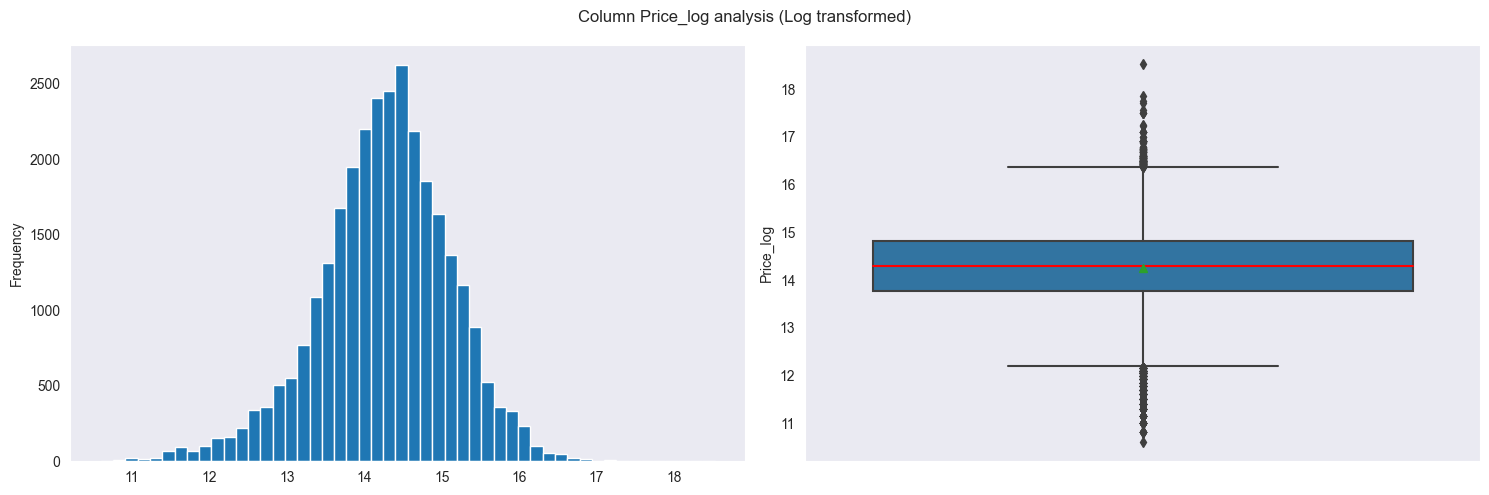

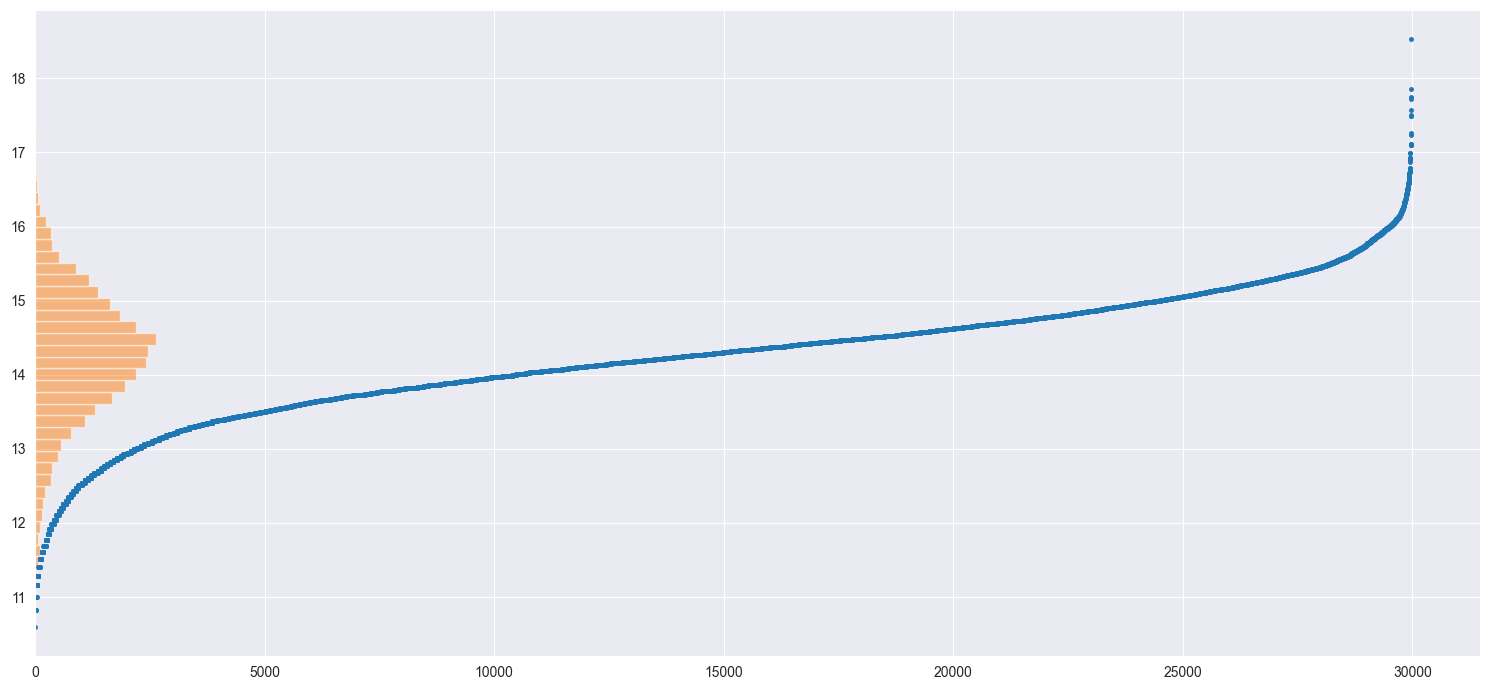

Statistics for Price_log column:


count                                29975.0
mean                               14.260297
std                                 0.852486
min                                 10.59666
25%                                13.764218
50%                                14.304091
75%                                14.808763
max                                18.525941
Median                             14.304091
Mode/Count            13.384729180332174/152
Skewness                           -0.375194
IQR                                 1.044544
Number of outliers                683 (2.3%)
Name: Price_log, dtype: object

Price  Price_log
Price      1.000000   0.775778
Price_log  0.775778   1.000000

In [318]:
analyze_num_col(df_train, 'Price', need_log=True, hist_bins=50)

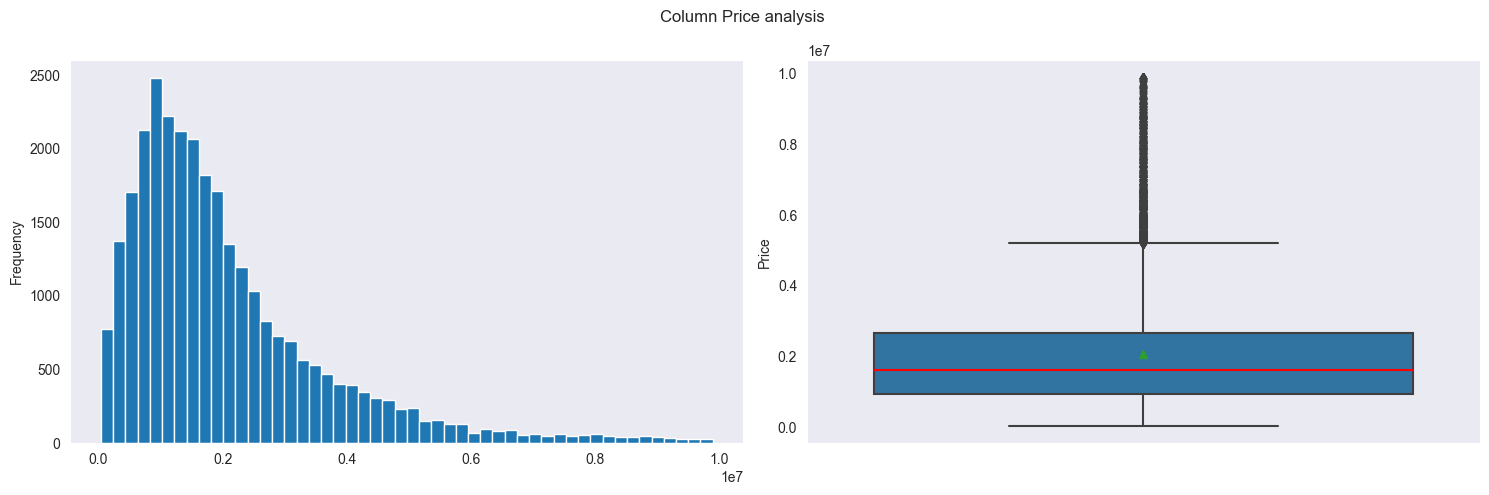

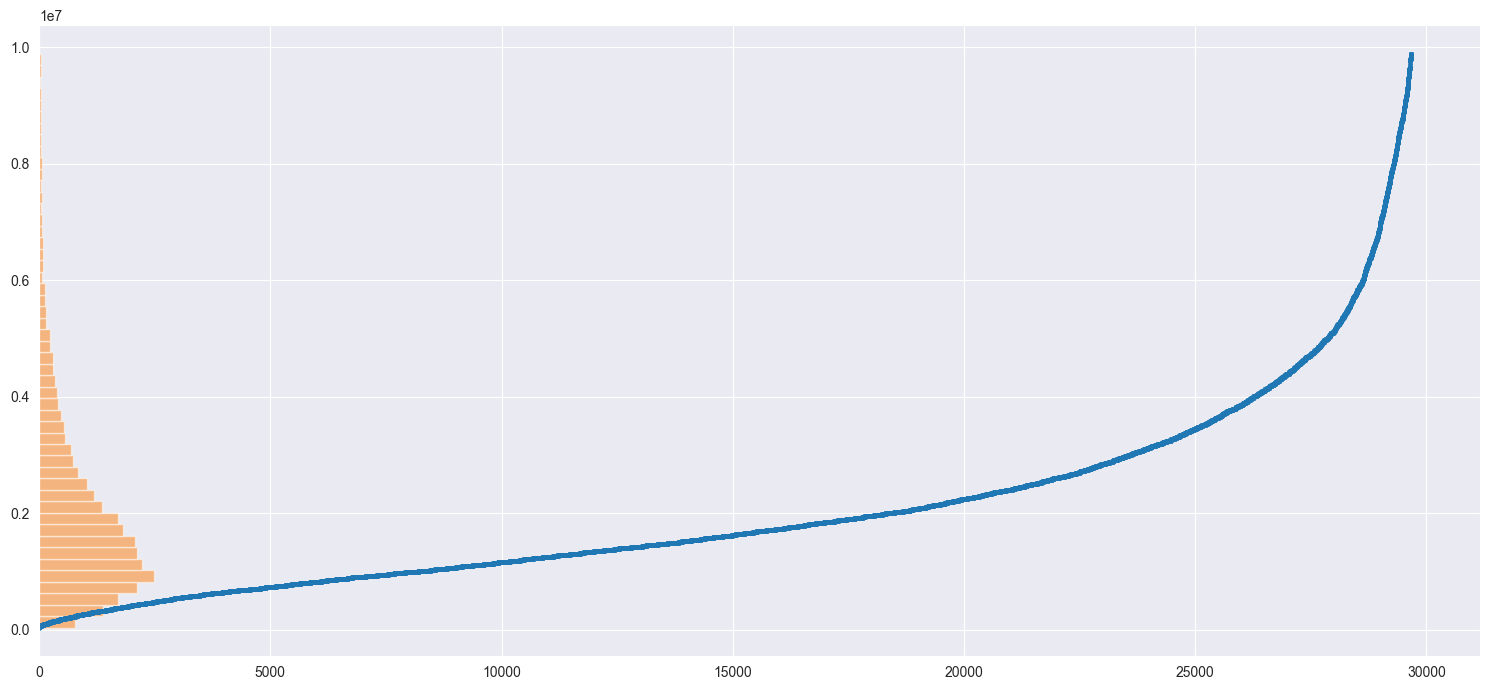

In [319]:
# Price has extreme outlier, let's see on it without them
vis_analyze_num_col(df_train[df_train['Price'] < df_train['Price'].quantile(0.99)],
                    'Price', hist_bins=50)

We also should consider a parsing time for train and test sets, because our target variable price is changing over time.

In [320]:
for df in dfs.values():
    df['ParsingUnixtime'] = pd.to_datetime(df['ParsingUnixtime'], unit='s')
    df['ParsingUnixtime'] = pd.to_datetime(df['ParsingUnixtime'].dt.floor('d'))
    display(df['ParsingUnixtime'].value_counts().sort_index())

2022-02-02    29876
2022-02-06       99
Name: ParsingUnixtime, dtype: int64

2020-10-19     6441
2020-10-20     6813
2020-10-21    15907
2020-10-24     2123
2020-10-25     2944
2020-10-26      458
Name: ParsingUnixtime, dtype: int64

Conclusion:
Target variable Price distribution is very skewed to less values and has extreme outliers and not so small of them based on IQR (6 %). We don't know if something like this exist in test - maybe their removing before training could improve future results. Makes sense to try (maybe not if log transform).
Log transform of target feature seems much more normal (form, skewness near zero), has "better" value range, less number (2.3 %) and less values of outliers. Definitely should try log transform for target. UPD: also virtually all models performed better with log transform price and eventually we use only log transform target for models.

Test parsing date is 10.2020 and train parsing date is 02.2022 - 1.33 years diff. So, we should consider price changing during this period of time.
Based on information from [this page of autostat.ru](https://www.autostat.ru/infographics/48987/) and some other statistics, let's choose as start point for our experiments with price correction coefficient range [0.6 - 0.8]. But experiments result is the only truth for such a problem. UPD: experimentally defined best value for corr coefficient = 0.57.

## New feature engineering

### Numeric

In [321]:
# let's create feature based on description column
# see on most frequent words for expensive and for cheap cars
expensive_cars = df_train[df_train['Price'] > df_train['Price'].quantile(0.9)]
cheap_cars = df_train[df_train['Price'] < df_train['Price'].quantile(0.1)]
print(expensive_cars.shape)
print(cheap_cars.shape)

(2988, 21)
(2928, 21)


In [322]:
n_1st_words = 200
expen_words_freq = expensive_cars['Description'].str.split(expand=True, n=n_1st_words).iloc[:, :n_1st_words].stack().value_counts()
expen_words_freq = expen_words_freq[expen_words_freq.index.map(lambda w: True if (len(w) > 3 and 'авто' not in w.lower()) else False)]
expen_words_freq

Система         3020
система         1860
пробегом        1766
безопасности    1610
сидений         1138
                ... 
жёсткостью.        1
электронно         1
переменной,        1
ride:              1
предоставлю        1
Length: 23690, dtype: int64

In [323]:
cheap_words_freq = cheap_cars['Description'].str.split(expand=True, n=n_1st_words).iloc[:, :n_1st_words].stack().value_counts()
cheap_words_freq = cheap_words_freq[cheap_words_freq.index.map(lambda w: True if (len(w) > 3 and 'авто' not in w.lower()) else False)]
cheap_words_freq

пробегом        536
хорошем         531
есть            515
работает        465
Машина          396
               ... 
12.5.1            1
предлагаете       1
варианты....      1
встретиться       1
нейтральной       1
Length: 24503, dtype: int64

In [324]:
test_descr_words = df_test['Description'].str.split(expand=True, n=n_1st_words).iloc[:,:n_1st_words].stack().value_counts()
test_descr_words = test_descr_words[test_descr_words.index.map(lambda w: True if (len(w)>3 and 'авто' not in w.lower()) else False)]
test_descr_words

пробегом         6988
Машина           5853
отличном         5235
есть             4667
только           4544
                 ... 
инетом,             1
плановый            1
ден"ги!!!           1
подарок(новая       1
неадекватные        1
Length: 163953, dtype: int64

Considering word frequency tables above and results of car pages analysis we will try to create feature ComplectationRank which indicates expensiveness of car complectation with function below:

In [325]:
def complectation_rank(description:str):
    descr = description.lower()
    rank = 0
    expensive_patterns = ['систем', 'датчик', 'круиз', 'многозонный', 'безопасности пассажир',
                          'безопасности боков', 'глонас', 'парктроник', 'камер', r'\bкож']

    for pattern in expensive_patterns:
        if re.search(pattern, descr):
            rank += 1
    return rank

In [326]:
# create new numerical features (for train and test)
for key, df in dfs.items():
    # add ComplectationRank via funciton above
    df['ComplectationRank'] = df['Description'].apply(complectation_rank)

    # also try words count for Description
    df['DescrWordsCount'] = df['Description'].apply(lambda s: len(s.split()))

    # age of the car
    parsing_date = 2022 if key == 'train' else 2020
    df['Age'] = parsing_date - df['ProductionDate']

    # mileage per year
    df['MileagePerYear'] = df['Mileage'] / df['Age']
    df['MileagePerYear'].replace([np.inf, -np.inf], 0, inplace=True)

    # count of years for one owner
    # well, we have not numeric value '3 и БОЛЕЕ' in Owners that makes this feature somewhat questionable
    # but let's experiment with it, perhaps we will see if there is a tendency
    df['YearsPerOwner'] = df['Age'] / df['Owners'].apply(lambda s:int(s[0]))

# add new numeric columns in separate list
new_num_cols = OSet(['ComplectationRank', 'DescrWordsCount', 'Age', 'MileagePerYear', 'YearsPerOwner'])

****************************************************************************************************
************************************     ComplectationRank     ************************************
****************************************************************************************************


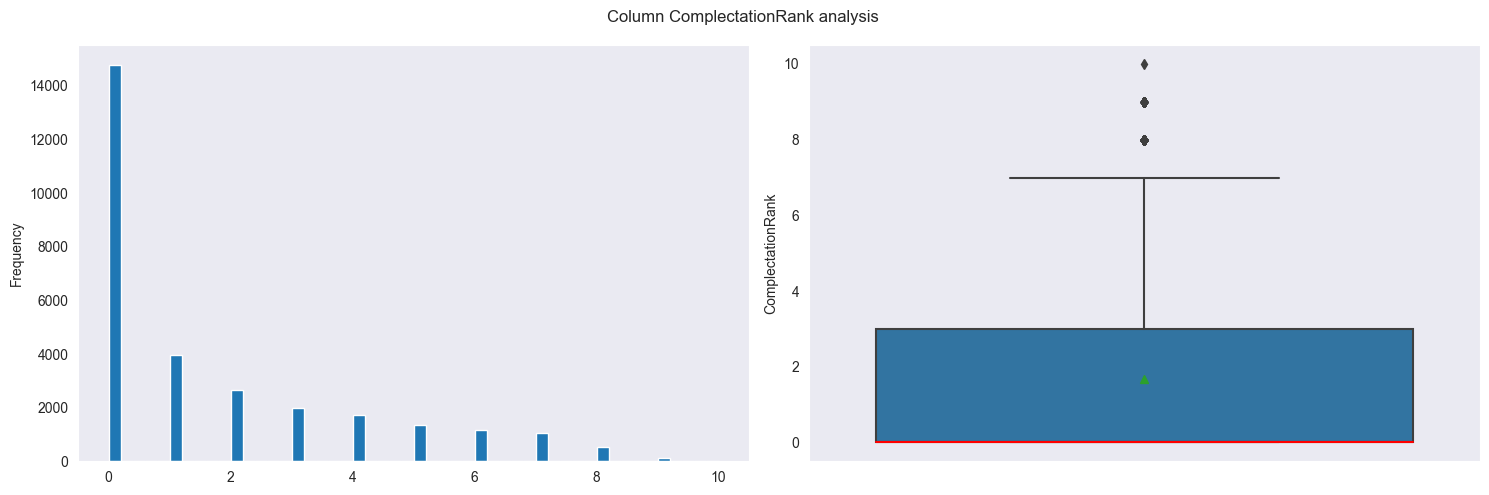

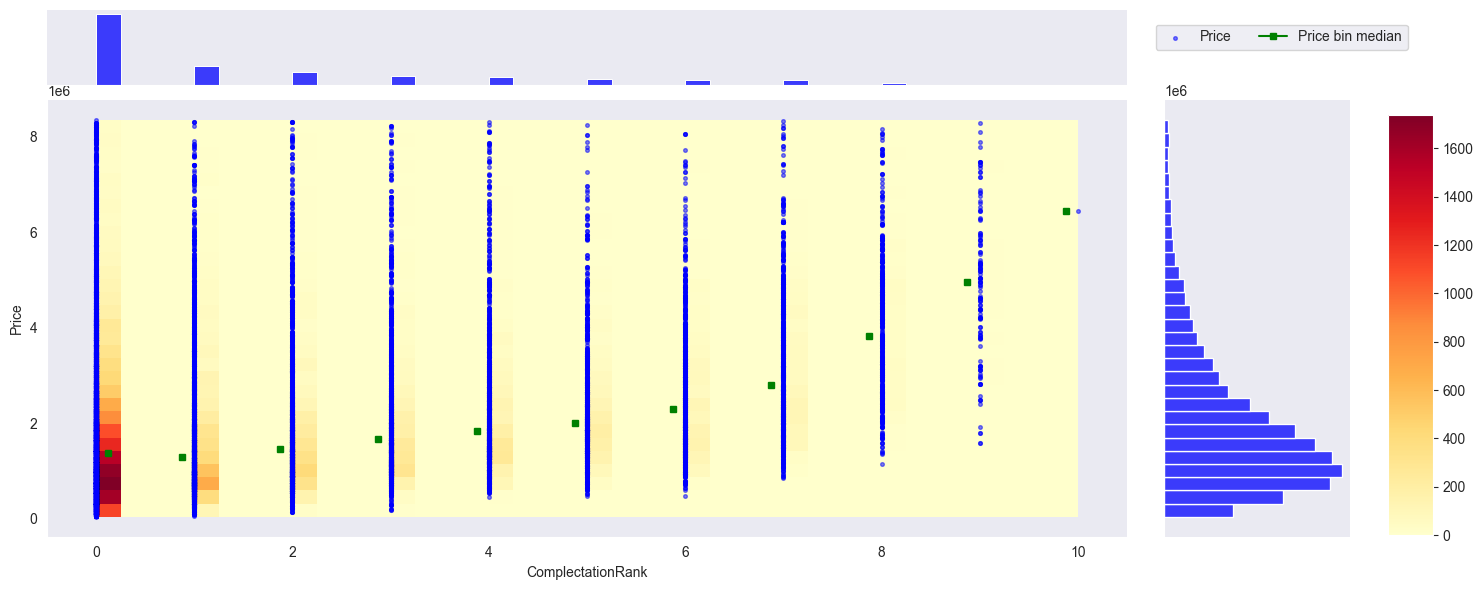

Statistics for ComplectationRank column:


count                    29374.0
mean                    1.664465
std                     2.277478
min                          0.0
25%                          0.0
50%                          0.0
75%                          3.0
max                         10.0
Median                       0.0
Mode/Count               0/14784
Skewness                1.314638
IQR                          3.0
Number of outliers    676 (2.3%)
Name: ComplectationRank, dtype: object


Column ComplectationRank log transform analysis:


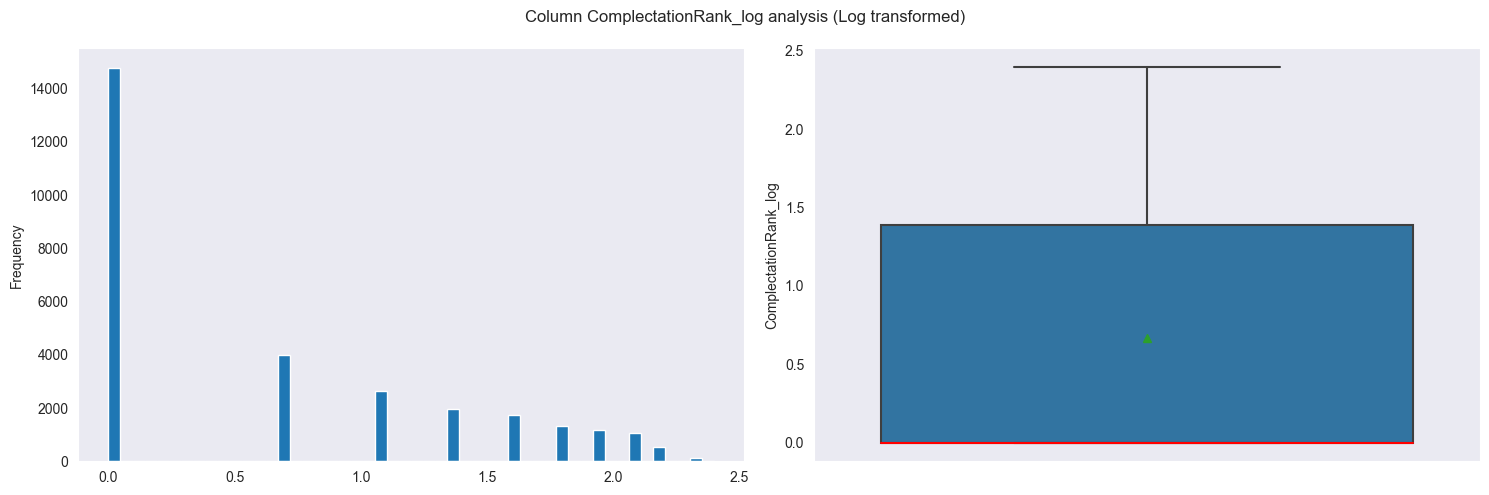

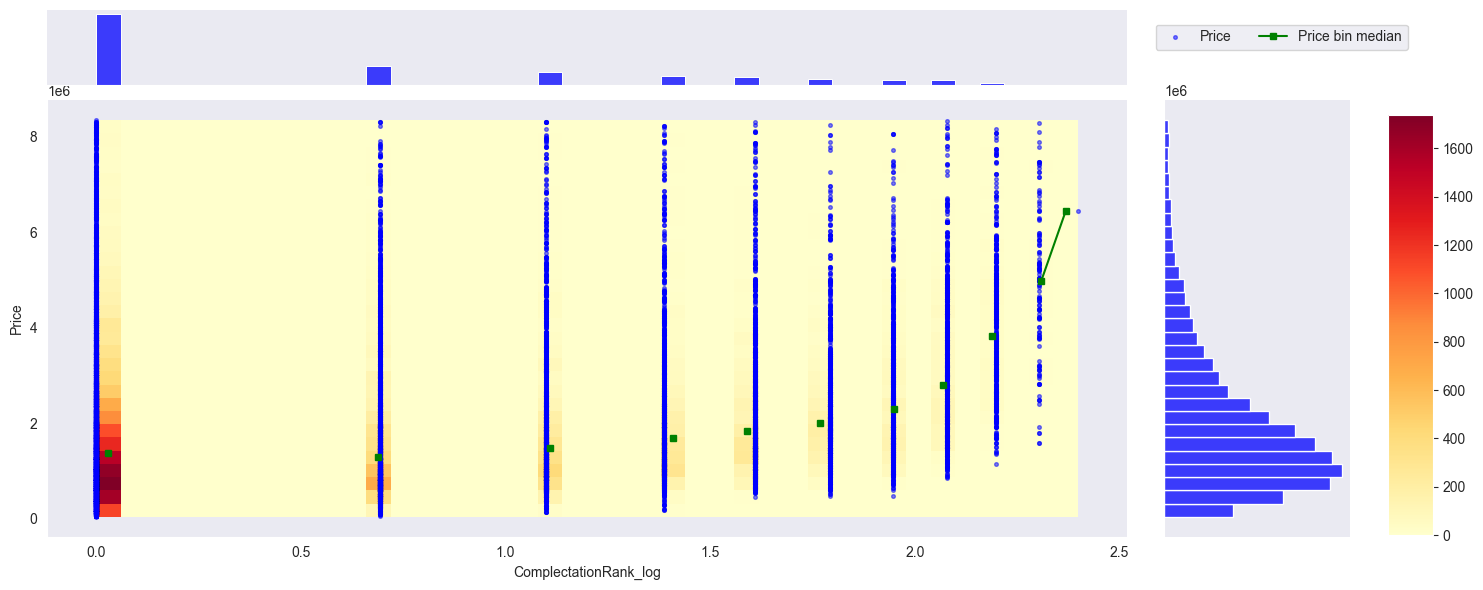

Statistics for ComplectationRank_log column:


count                   29374.0
mean                    0.66718
std                    0.760958
min                         0.0
25%                         0.0
50%                         0.0
75%                    1.386294
max                    2.397895
Median                      0.0
Mode/Count            0.0/14784
Skewness               0.610713
IQR                    1.386294
Number of outliers     0 (0.0%)
Name: ComplectationRank_log, dtype: object

ComplectationRank  ComplectationRank_log     Price
ComplectationRank               1.000000               0.960428  0.282822
ComplectationRank_log           0.960428               1.000000  0.242889
Price                           0.282822               0.242889  1.000000

****************************************************************************************************
*************************************     DescrWordsCount     *************************************
****************************************************************************************************


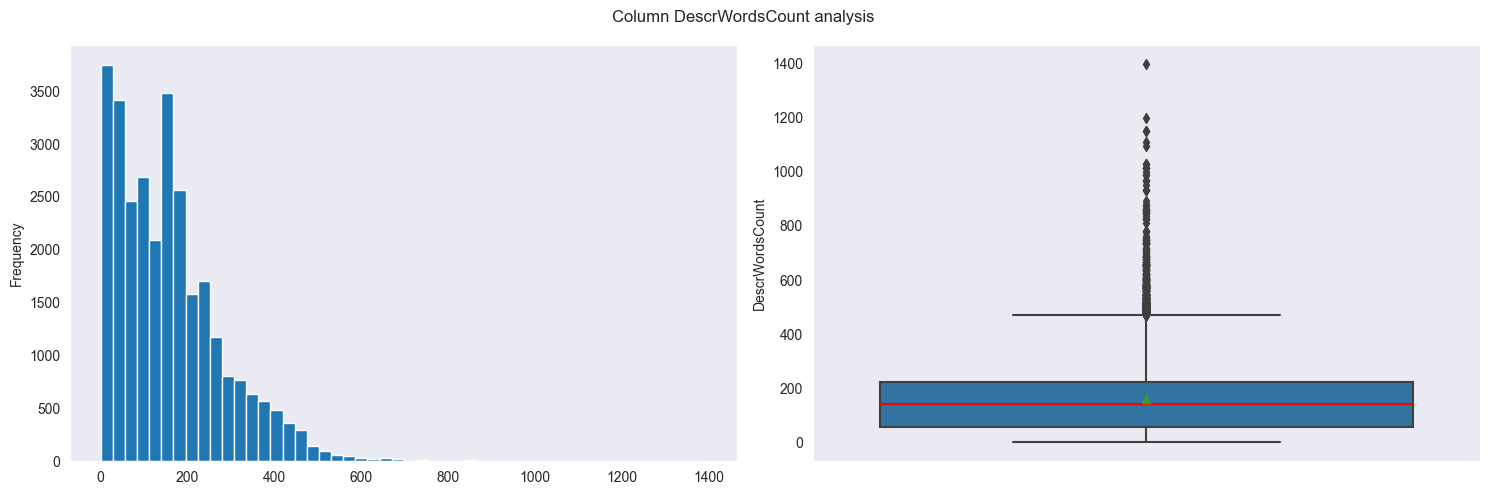

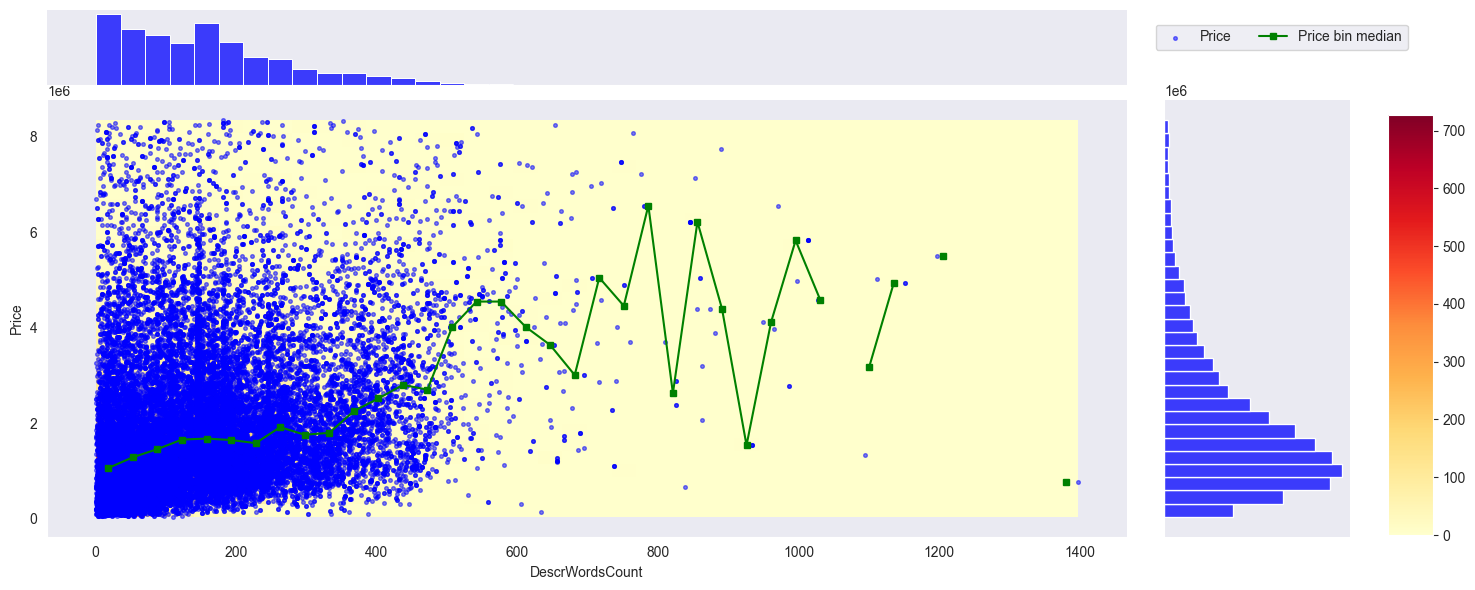

Statistics for DescrWordsCount column:


count                    29374.0
mean                  159.270886
std                   124.967397
min                          1.0
25%                         59.0
50%                        144.0
75%                        224.0
max                       1397.0
Median                     144.0
Mode/Count               144/469
Skewness                1.324871
IQR                        165.0
Number of outliers    564 (1.9%)
Name: DescrWordsCount, dtype: object


Column DescrWordsCount log transform analysis:


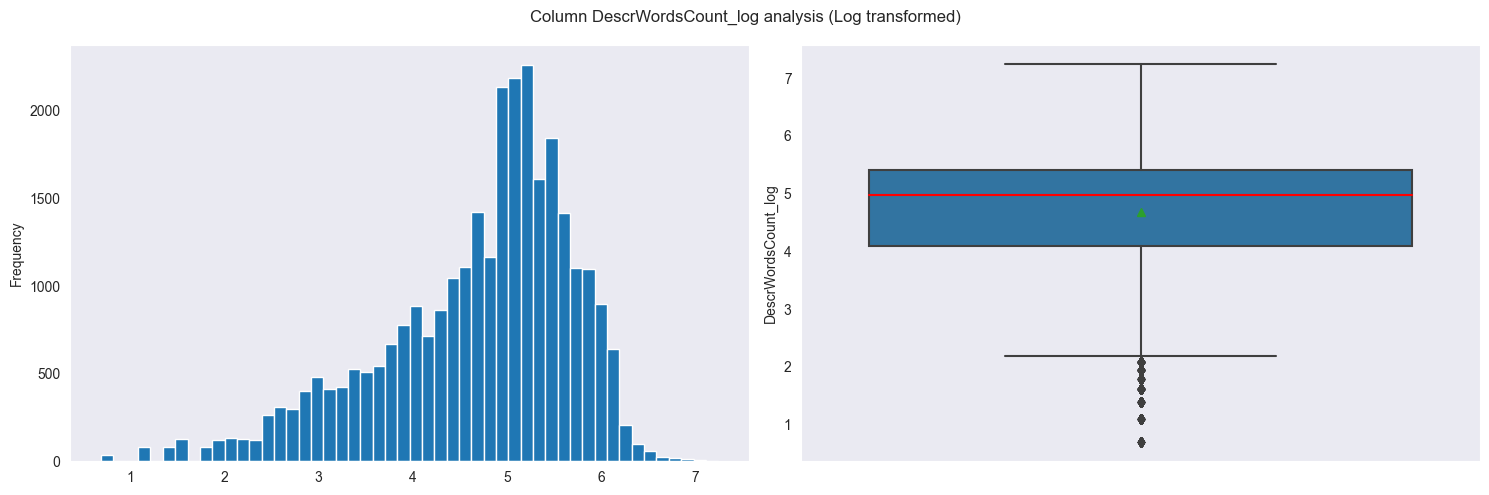

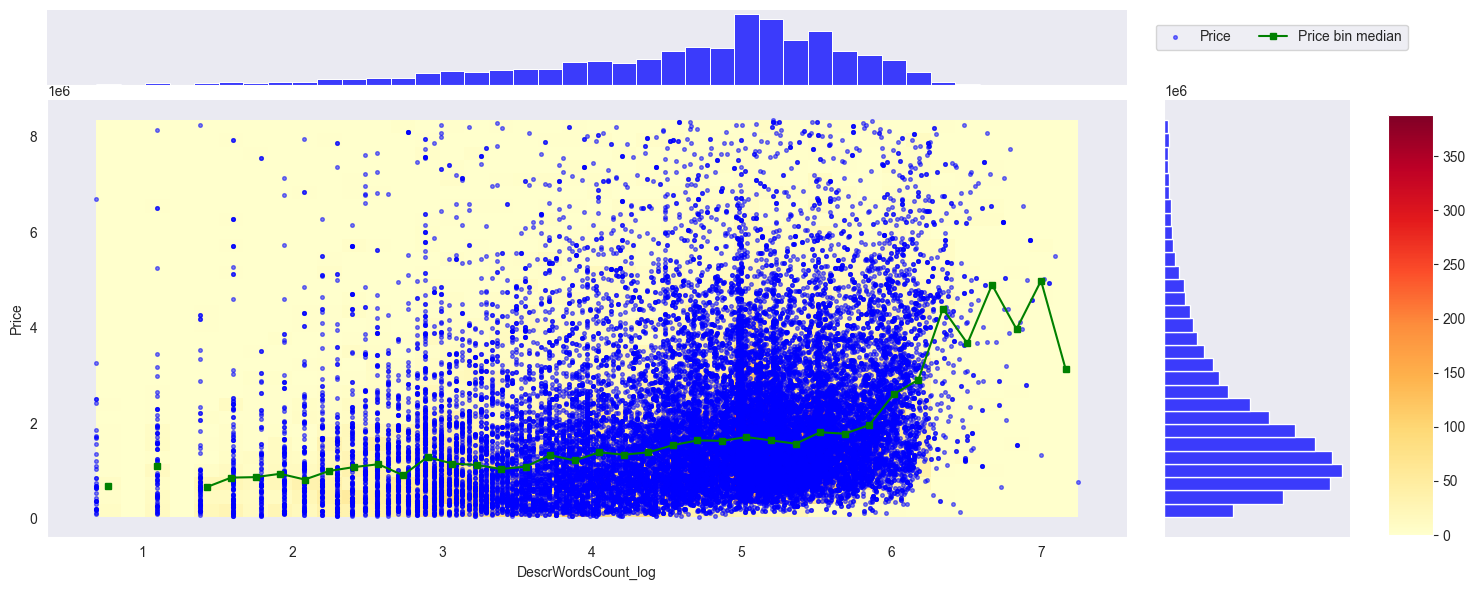

Statistics for DescrWordsCount_log column:


count                               29374.0
mean                               4.682328
std                                1.030632
min                                0.693147
25%                                4.094345
50%                                4.976734
75%                                  5.4161
max                                7.242798
Median                             4.976734
Mode/Count            4.976733742420574/469
Skewness                          -0.937779
IQR                                1.321756
Number of outliers               659 (2.2%)
Name: DescrWordsCount_log, dtype: object

DescrWordsCount  DescrWordsCount_log     Price
DescrWordsCount             1.000000             0.854157  0.255011
DescrWordsCount_log         0.854157             1.000000  0.222356
Price                       0.255011             0.222356  1.000000

****************************************************************************************************
*******************************************     Age     *******************************************
****************************************************************************************************


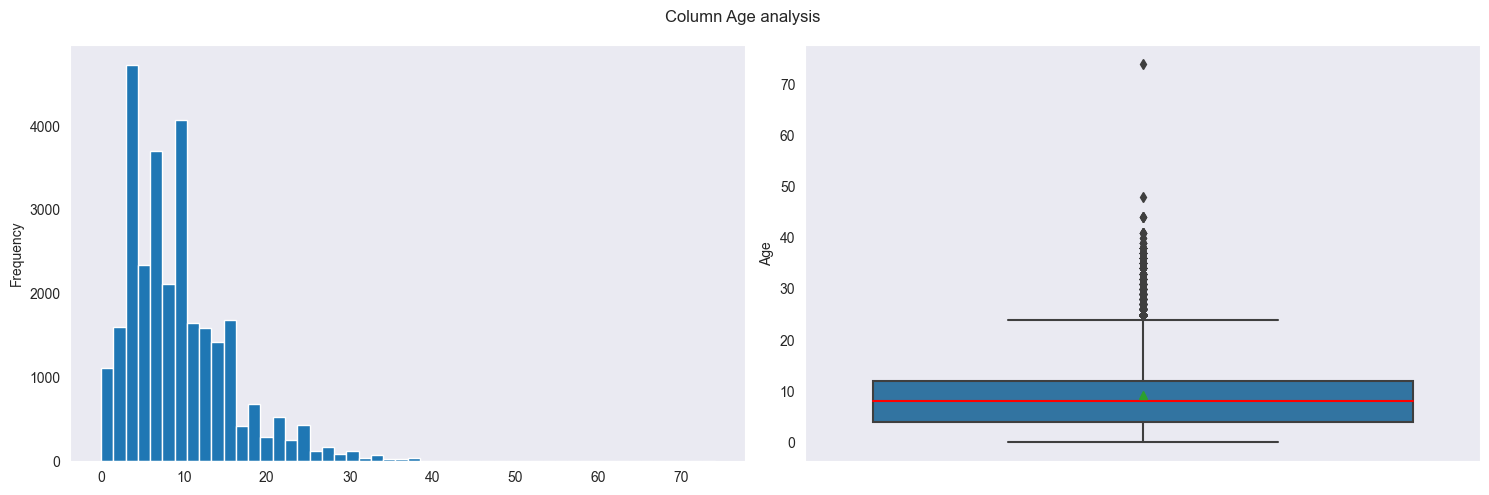

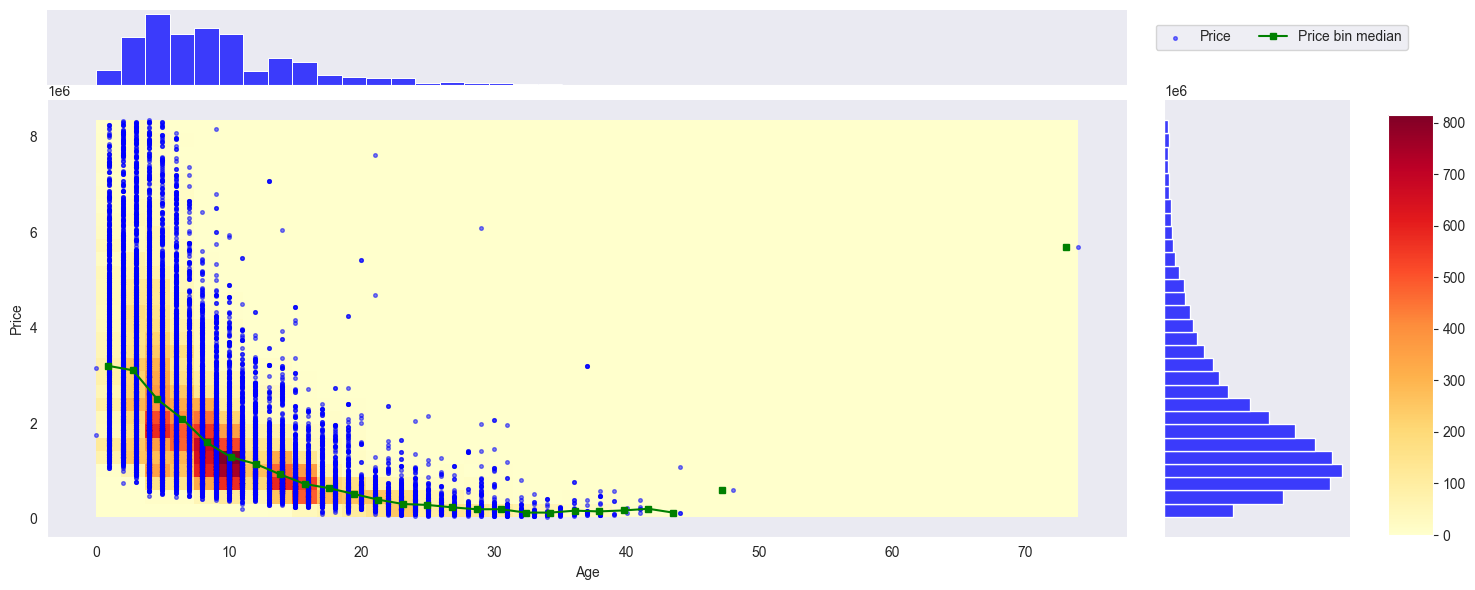

Statistics for Age column:


count                    29374.0
mean                    9.247294
std                     6.345862
min                          0.0
25%                          4.0
50%                          8.0
75%                         12.0
max                         74.0
Median                       8.0
Mode/Count              4.0/2842
Skewness                1.351194
IQR                          8.0
Number of outliers    922 (3.1%)
Name: Age, dtype: object


Column Age log transform analysis:


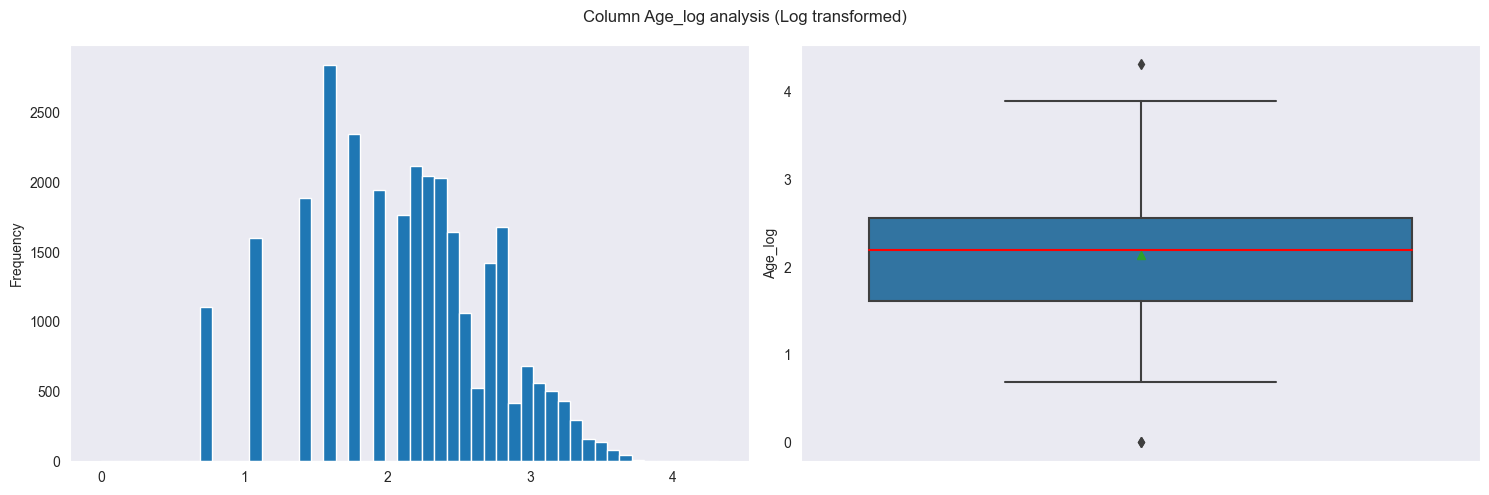

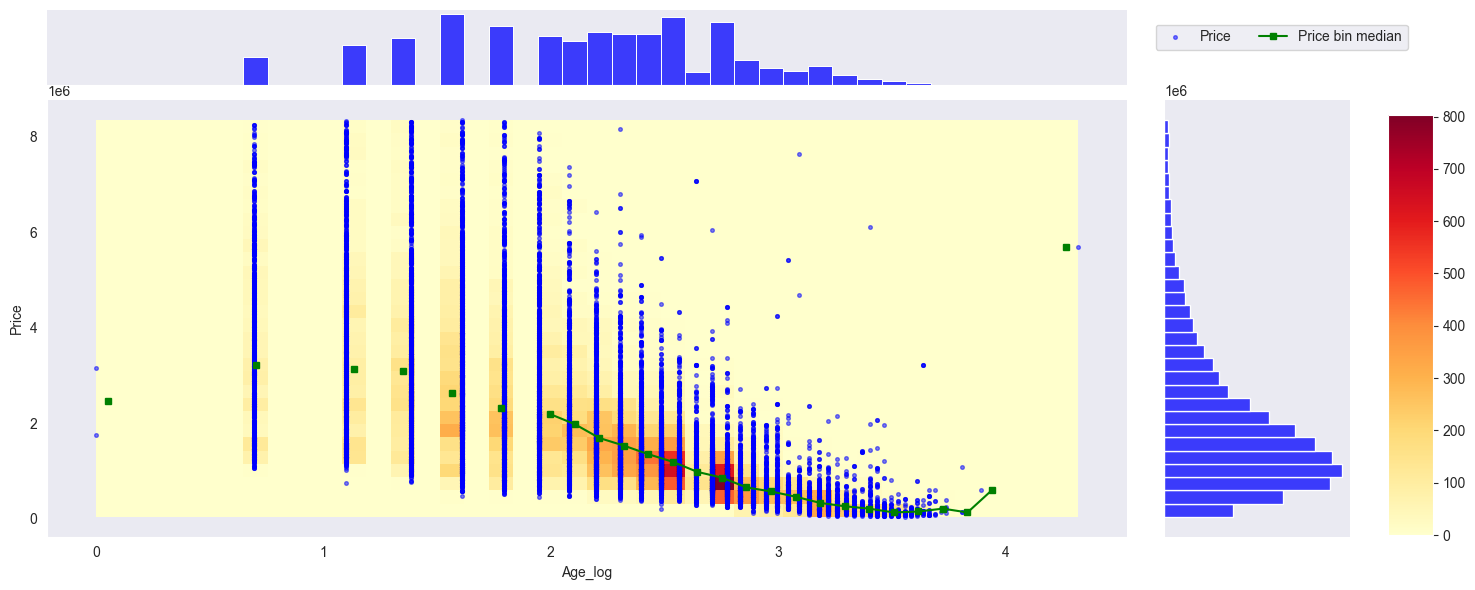

Statistics for Age_log column:


count                                 29374.0
mean                                 2.139912
std                                  0.630305
min                                       0.0
25%                                  1.609438
50%                                  2.197225
75%                                  2.564949
max                                  4.317488
Median                               2.197225
Mode/Count            1.6094379124341003/2842
Skewness                            -0.242307
IQR                                  0.955511
Number of outliers                   3 (0.0%)
Name: Age_log, dtype: object

Age   Age_log     Price
Age      1.000000  0.927047 -0.600870
Age_log  0.927047  1.000000 -0.641297
Price   -0.600870 -0.641297  1.000000

****************************************************************************************************
**************************************     MileagePerYear     **************************************
****************************************************************************************************


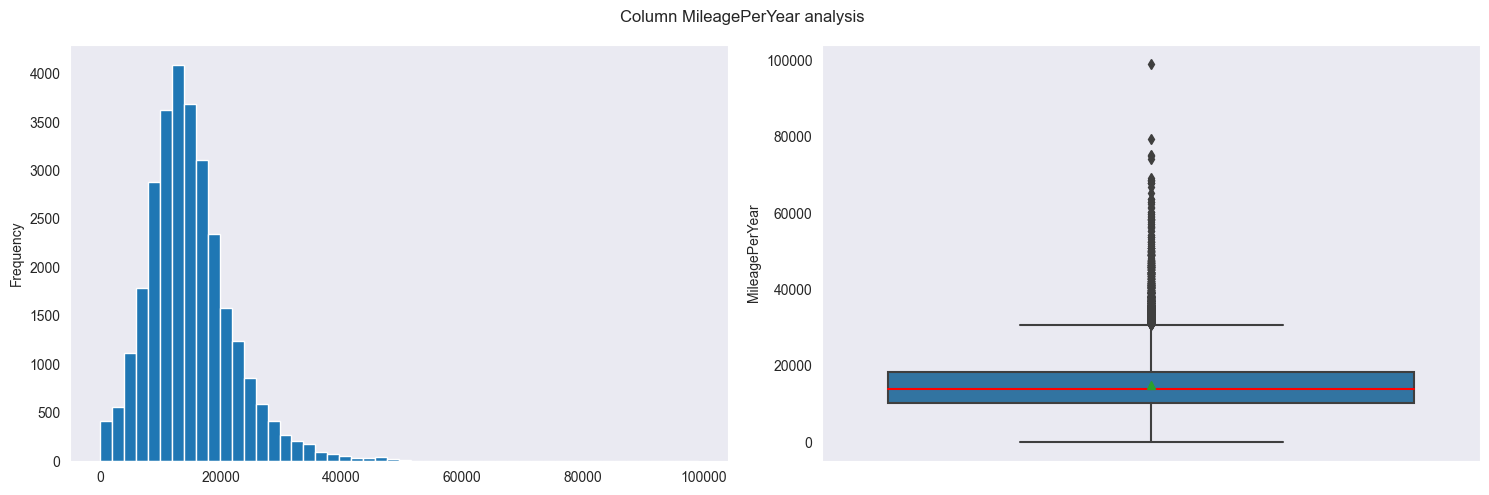

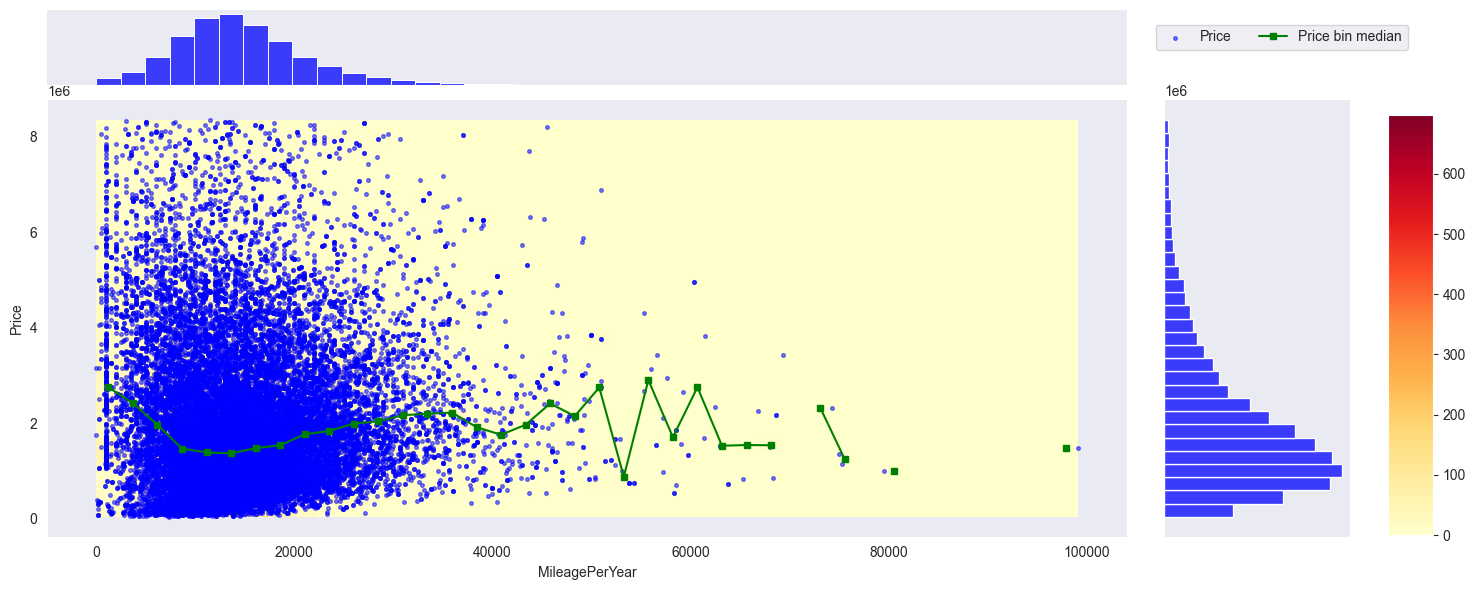

Statistics for MileagePerYear column:


count                      29374.0
mean                  14919.885444
std                    7313.514637
min                            0.0
25%                        10200.0
50%                        14000.0
75%                   18444.444444
max                   99090.909091
Median                     14000.0
Mode/Count             15000.0/329
Skewness                  1.366914
IQR                    8244.444444
Number of outliers      908 (3.1%)
Name: MileagePerYear, dtype: object


Column MileagePerYear log transform analysis:


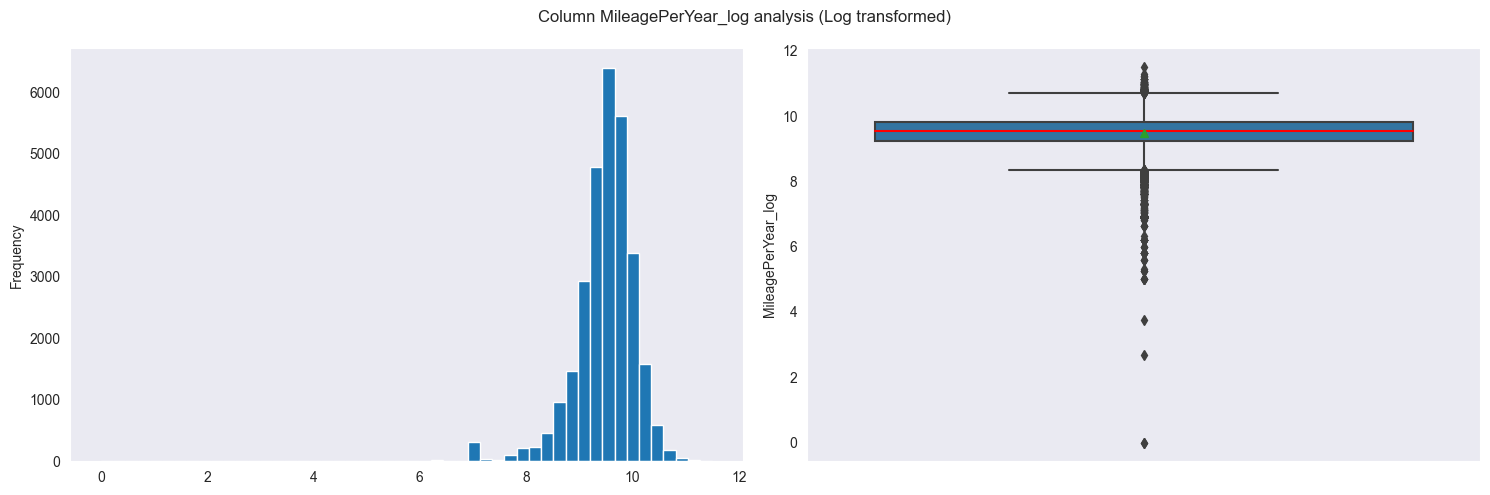

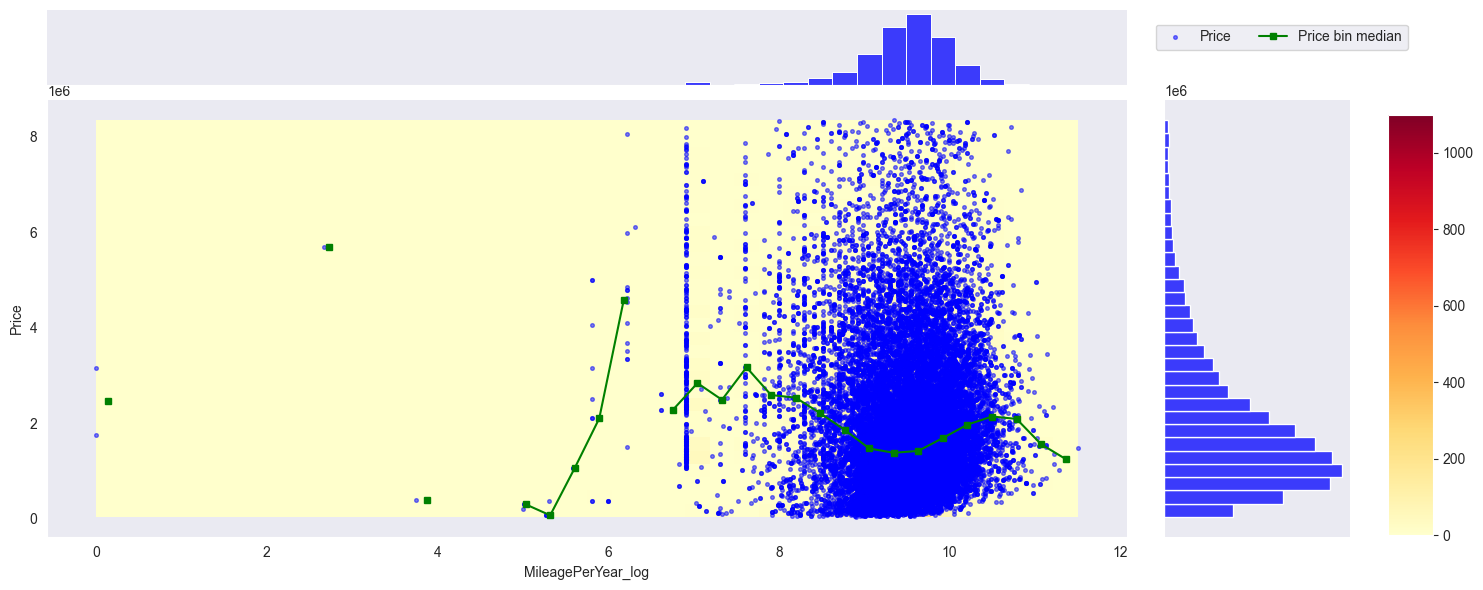

Statistics for MileagePerYear_log column:


count                              29374.0
mean                              9.474475
std                               0.587313
min                                    0.0
25%                               9.230241
50%                               9.546884
75%                               9.822573
max                              11.503803
Median                            9.546884
Mode/Count            9.61587214452889/329
Skewness                         -1.898128
IQR                               0.592332
Number of outliers             1279 (4.4%)
Name: MileagePerYear_log, dtype: object

MileagePerYear  MileagePerYear_log     Price
MileagePerYear            1.000000            0.872337  0.008127
MileagePerYear_log        0.872337            1.000000 -0.073134
Price                     0.008127           -0.073134  1.000000

****************************************************************************************************
**************************************     YearsPerOwner     **************************************
****************************************************************************************************


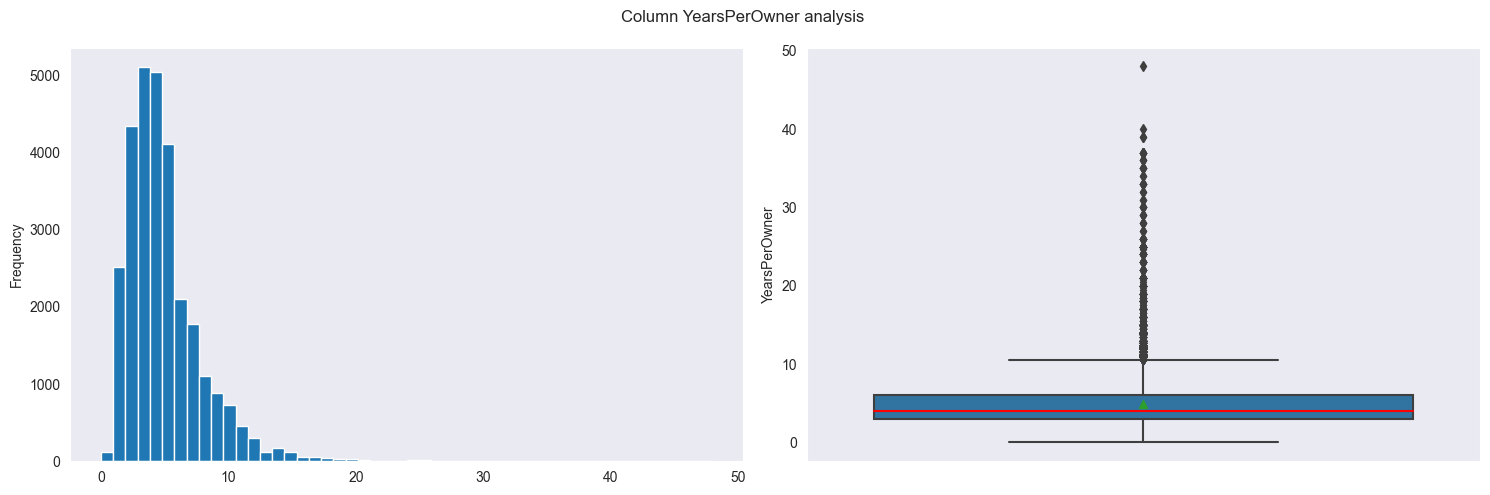

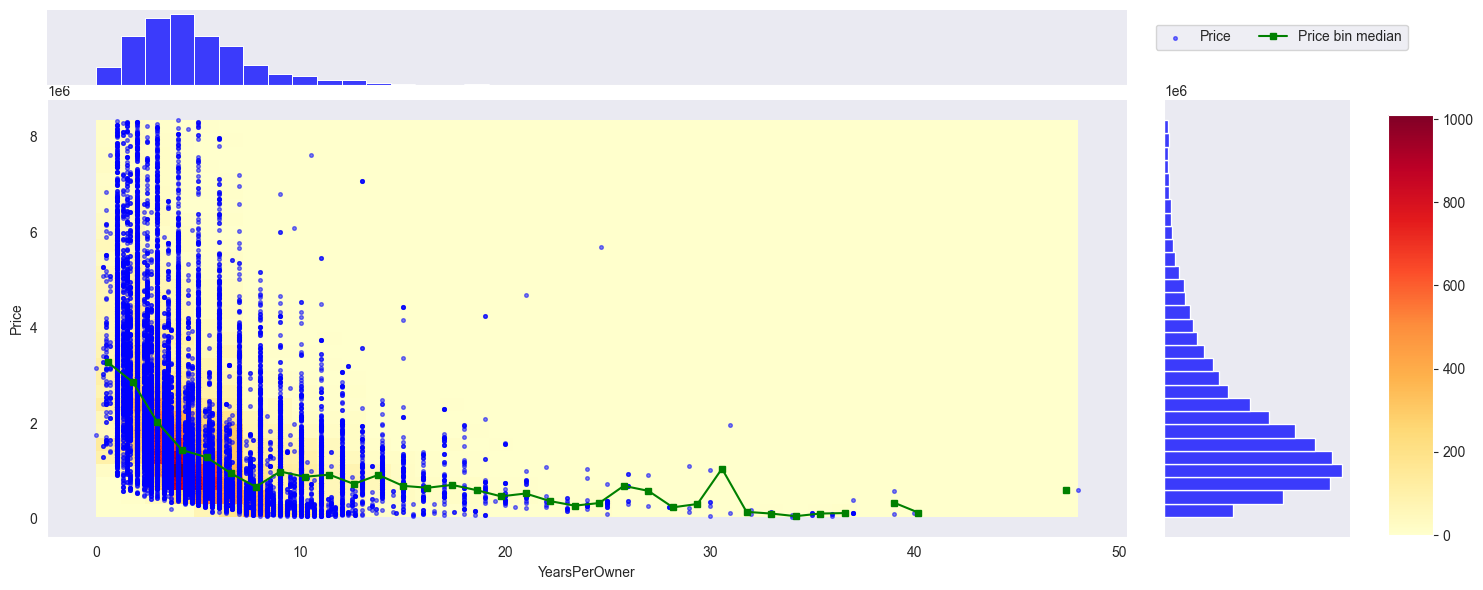

Statistics for YearsPerOwner column:


count                     29374.0
mean                     4.879985
std                      3.238346
min                           0.0
25%                           3.0
50%                           4.0
75%                           6.0
max                          48.0
Median                        4.0
Mode/Count               4.0/3089
Skewness                 2.543339
IQR                           3.0
Number of outliers    1525 (5.2%)
Name: YearsPerOwner, dtype: object


Column YearsPerOwner log transform analysis:


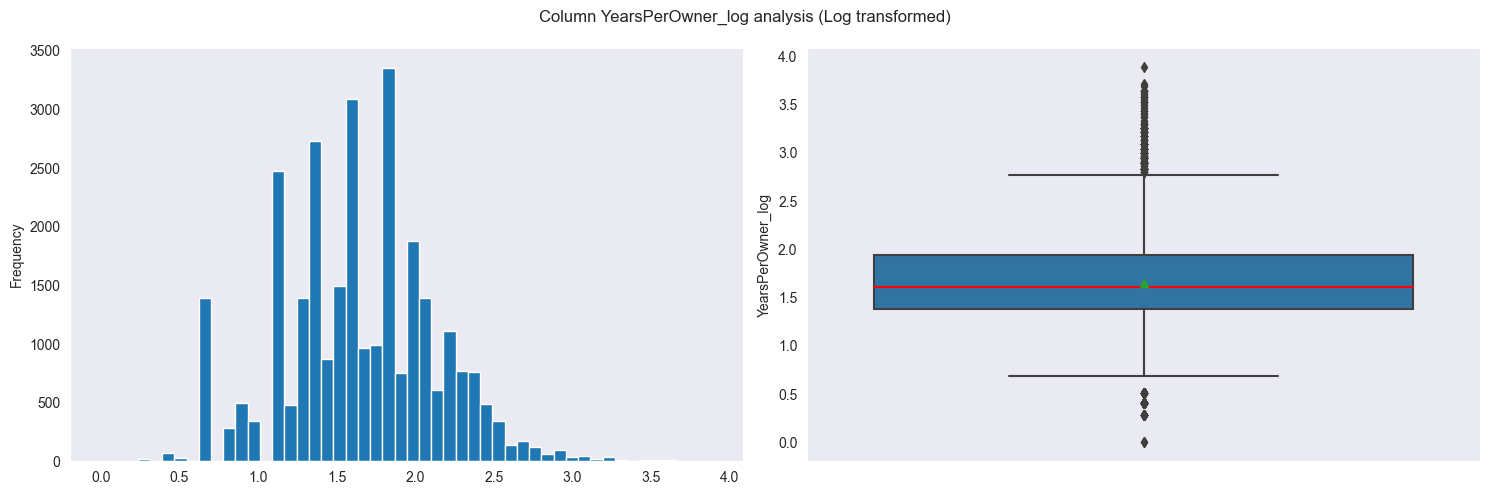

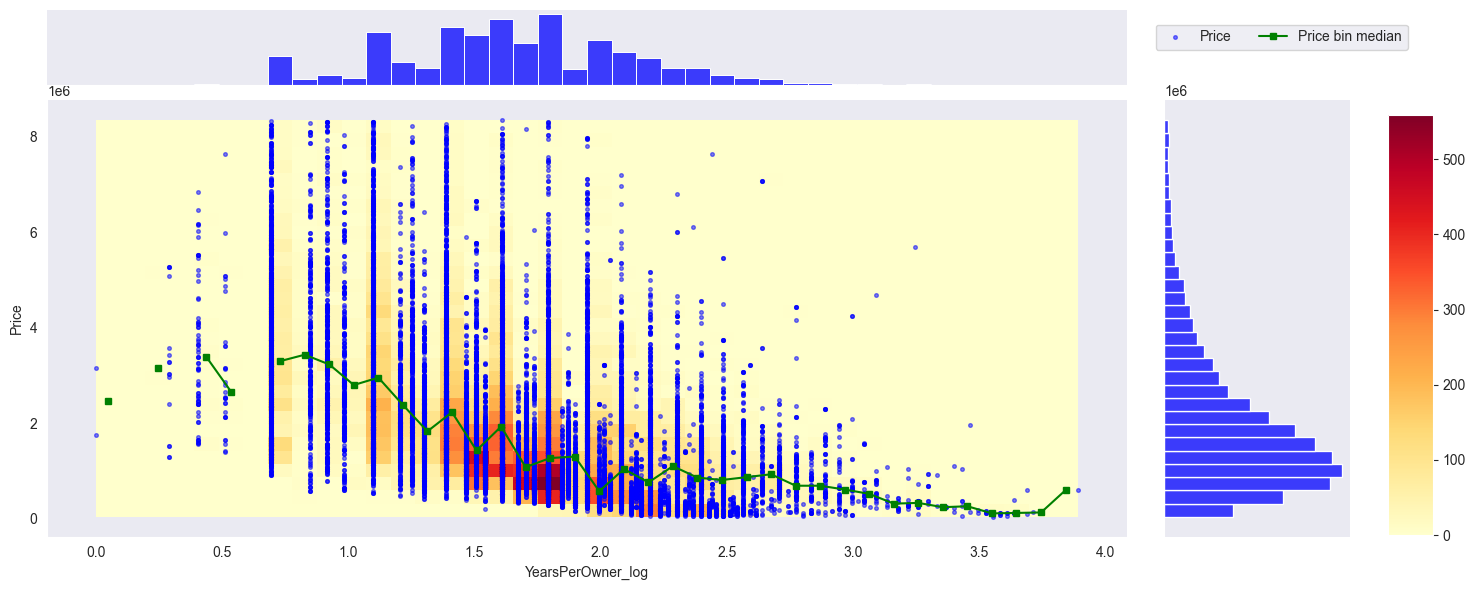

Statistics for YearsPerOwner_log column:


count                                 29374.0
mean                                  1.65032
std                                  0.484893
min                                       0.0
25%                                  1.386294
50%                                  1.609438
75%                                   1.94591
max                                   3.89182
Median                               1.609438
Mode/Count            1.6094379124341003/3089
Skewness                              0.15944
IQR                                  0.559616
Number of outliers                 457 (1.6%)
Name: YearsPerOwner_log, dtype: object

YearsPerOwner  YearsPerOwner_log     Price
YearsPerOwner           1.000000           0.924840 -0.426814
YearsPerOwner_log       0.924840           1.000000 -0.508989
Price                  -0.426814          -0.508989  1.000000

In [327]:
# analyze new numeric features
for col in new_num_cols:
    print_framed(col)
    analyze_num_col(df_train[df_train['Price'] < df_train['Price'].quantile(0.98)], col, 'Price', need_log=True, hist_bins=50, hist2d_x_bins=40, hist2d_y_bins=30)


<AxesSubplot:>

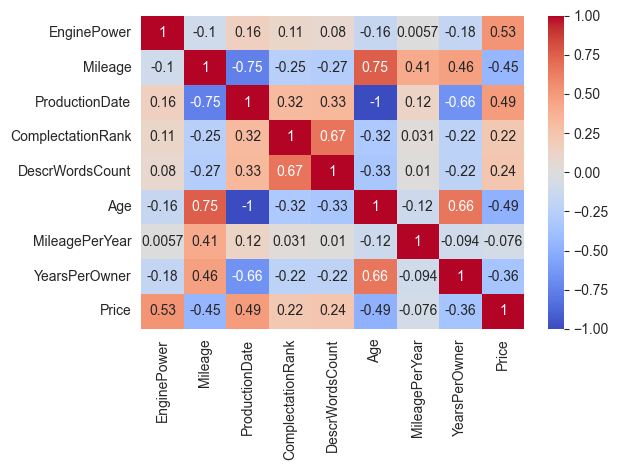

In [328]:
# correlation analysis for all numeric features
sb.heatmap(df_train[(num_cols | new_num_cols) - cols_to_del | {'Price'}].corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')

Conclusion:
'ComplectationRank'
We can see expected correlation with 'DescrWordsCount' feature, but not extreme. And as described earlier there is some correlation with price - visually and by corr coefficient (0.28 for price 0.98 percentile and 0.22 for all records). Leave this feature.
Log transofrm seems not to be helpful due to distribution form and corr coefficients comparing to original data. Don't use log transform for this feature.

'DescrWordsCount'
There is also some visual and numeric correlation with price. Let's leave this feature. Don't use log transform.

'Age'
We can see strong correlation with ProductionDate and considerable correlation with Mileage. Decide to leave Age feature because of 2 points:
1. Age have more relative difference between values compared to ProductionDate
2. Age wouldn't have this shift between train and test compared to ProductionDate feature due to their different parsing time. For example for ProductionDate = 2010 for train set all dependencies would be like for 12 years old car, but for test ProductionDate 2010 - it is only 10 years old

'MileagePerYear'
We can see almost no correlation with price. Maybe just a little positive (surprisingly) from visual analysis of scatter for small number of observations. But let's leave the feature for experiments. No sense to log transform.

'YearsPerOwner'
We can see some negative (a bit surprisingly) correlation (corr coeff = -0.42 for 0.98 percentile). Cars which belonged to one owner long time cost less. Maybe it is like an indicator of car liquidity. Interesting dependency. We remember that this is rather questionable feature, but let's try it and decide about its usefulness later.
Decide to log transform this feature due to greater corr coef for log transformed data.

In [329]:
cols_to_del |= {'ProductionDate'}
cols_to_log |= {'YearsPerOwner'}

### Qualitative

In [330]:
# create new qualitative features (for train and test)
for df in dfs.values():
    # car rarity flag
    df['Rarity'] = df['Age'].apply(lambda age: 1 if age > 45 else 0)

    # 3 top (expensive) colors
    df['ExpensiveColor'] = df['Color'].apply(lambda c: 1 if c in expensive_colors else 0)
    # and 3 cheap colors
    df['CheapColor'] = df['Color'].apply(lambda c: 1 if c in cheap_colors else 0)

    # expensive models - which are in list we defined earlier
    df['ExpensiveModel'] = df['ModelName'].apply(lambda n: 1 if n in expensive_models else 0)

    # expensive and cheap brands - which are in list we defined earlier
    df['ExpensiveBrand'] = df['Brand'].apply(lambda n: 1 if n in expensive_brands else 0)
    df['CheapBrand'] = df['Brand'].apply(lambda n: 1 if n in cheap_brands else 0)

# add new bin columns in separate list
new_bin_cols = OSet(['Rarity', 'ExpensiveColor', 'CheapColor', 'ExpensiveModel', 'ExpensiveBrand', 'CheapBrand'])

****************************************************************************************************
******************************************     Rarity     ******************************************
****************************************************************************************************
For TRAIN:


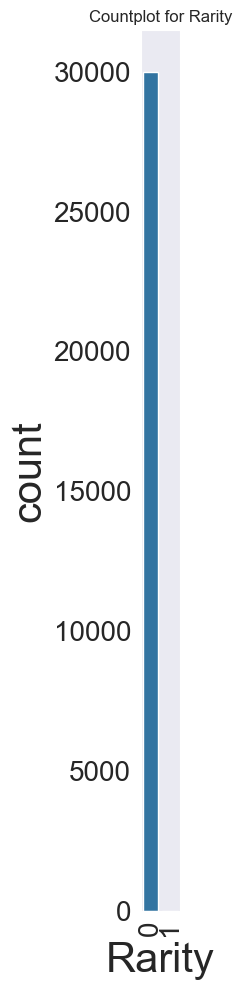

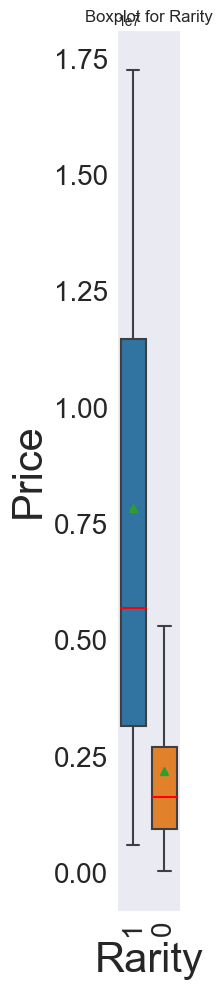

For TEST:


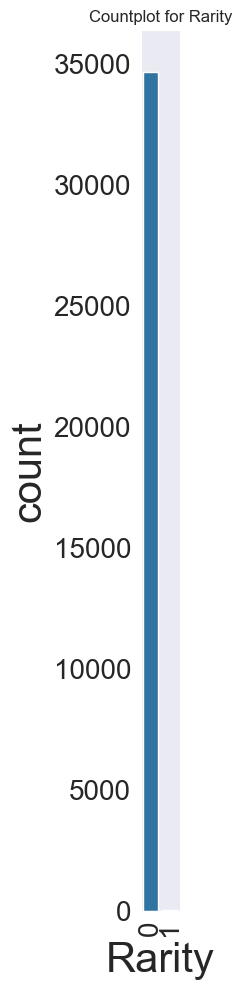

****************************************************************************************************
**************************************     ExpensiveColor     **************************************
****************************************************************************************************
For TRAIN:


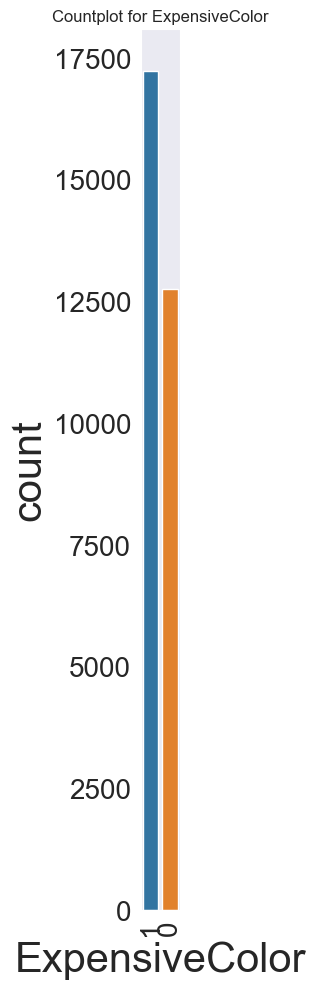

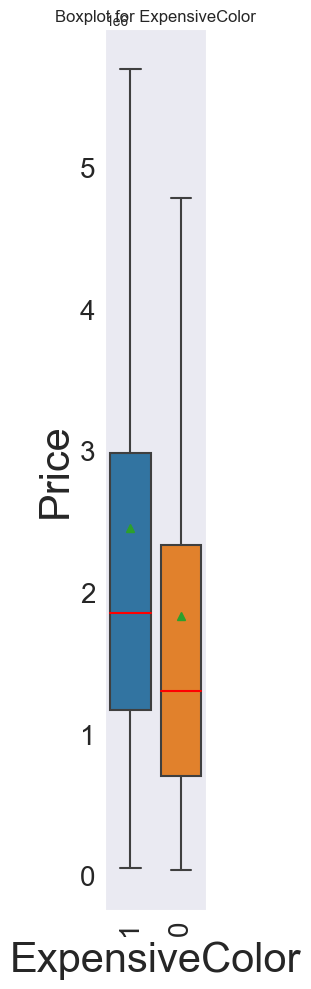

For TEST:


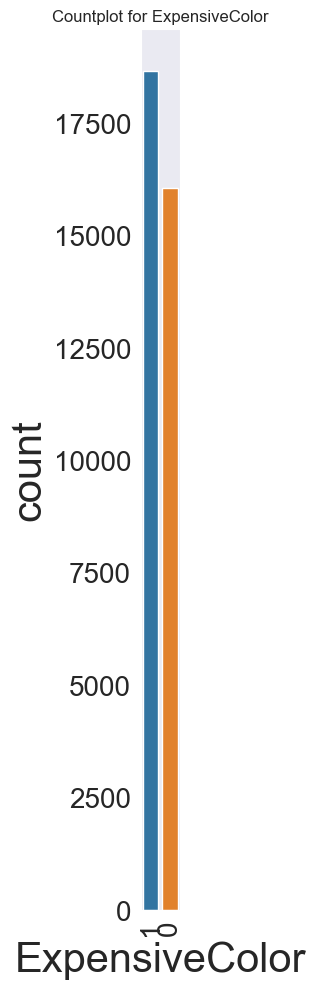

****************************************************************************************************
****************************************     CheapColor     ****************************************
****************************************************************************************************
For TRAIN:


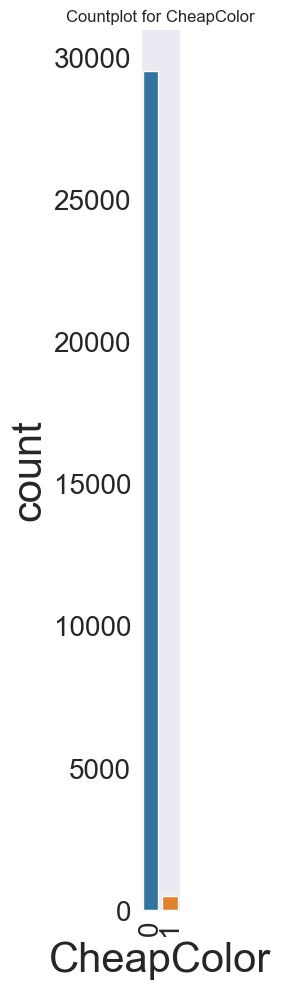

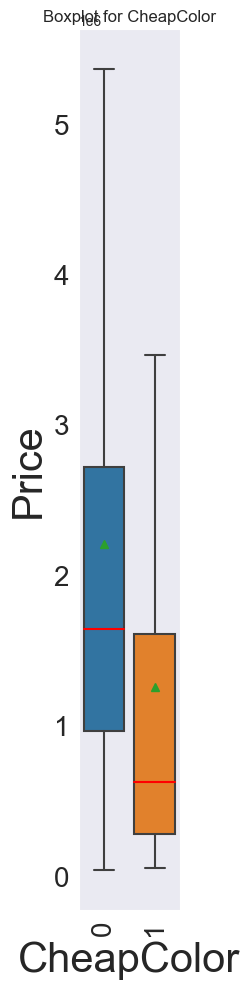

For TEST:


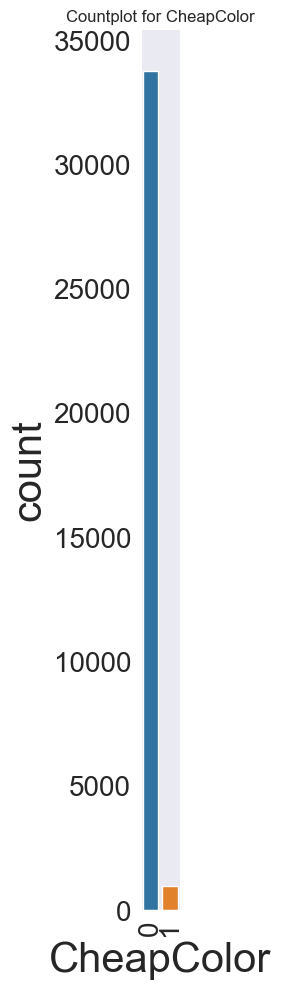

****************************************************************************************************
**************************************     ExpensiveModel     **************************************
****************************************************************************************************
For TRAIN:


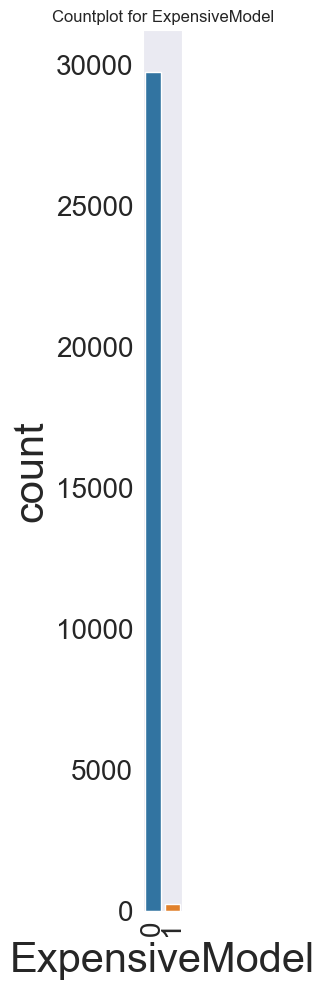

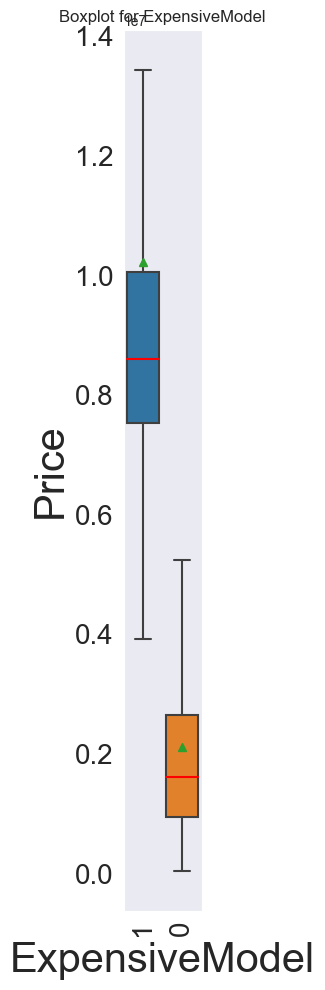

For TEST:


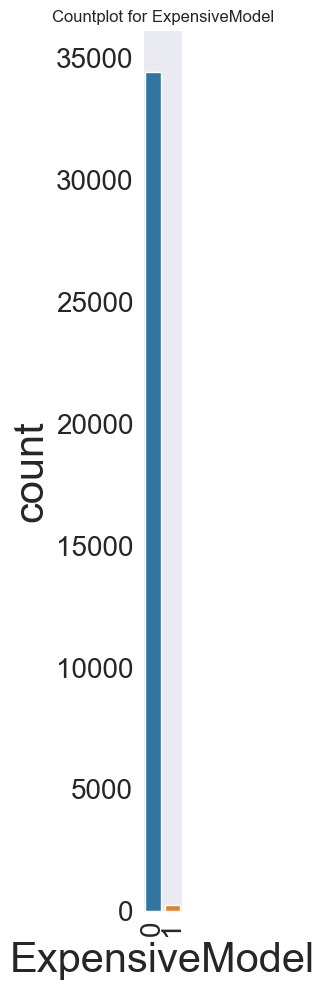

****************************************************************************************************
**************************************     ExpensiveBrand     **************************************
****************************************************************************************************
For TRAIN:


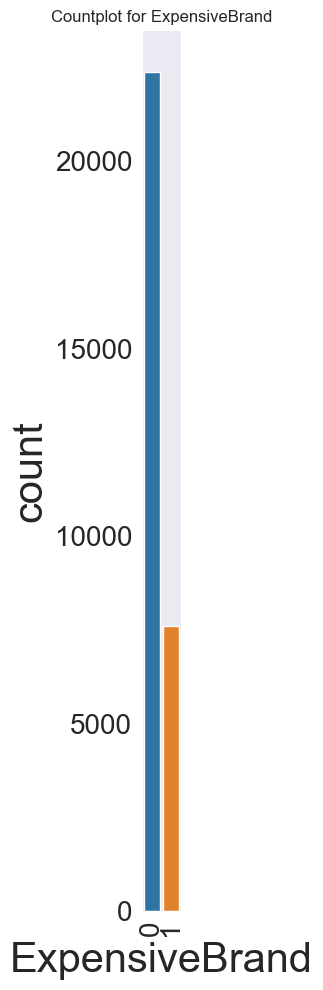

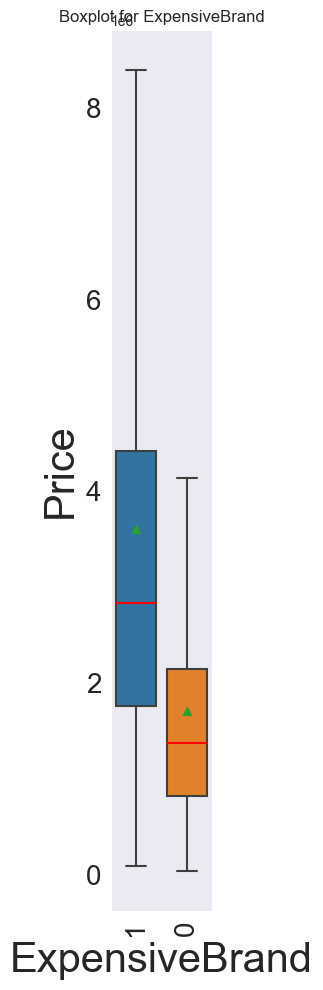

For TEST:


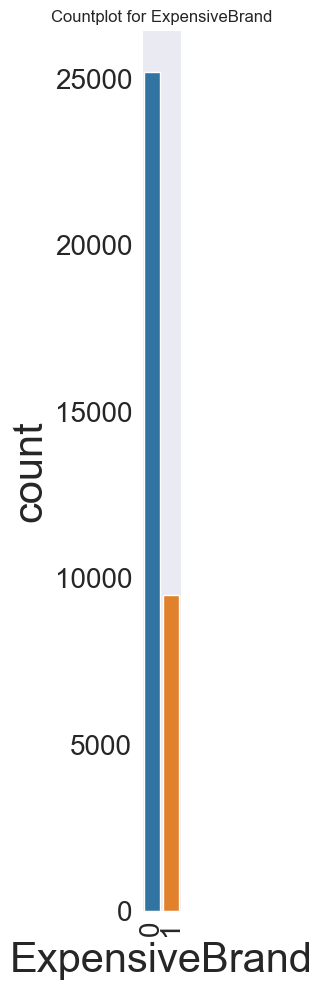

****************************************************************************************************
****************************************     CheapBrand     ****************************************
****************************************************************************************************
For TRAIN:


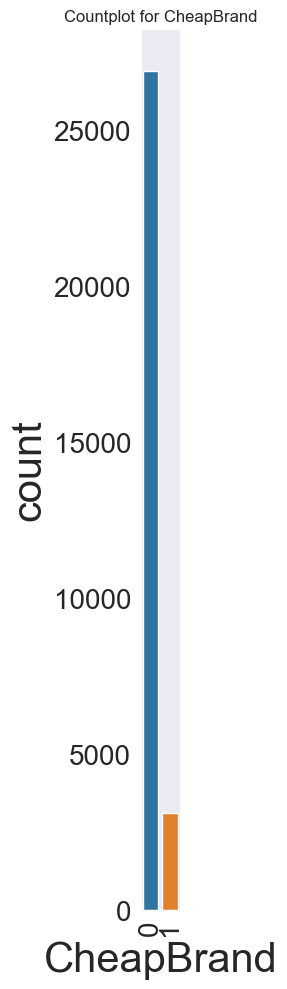

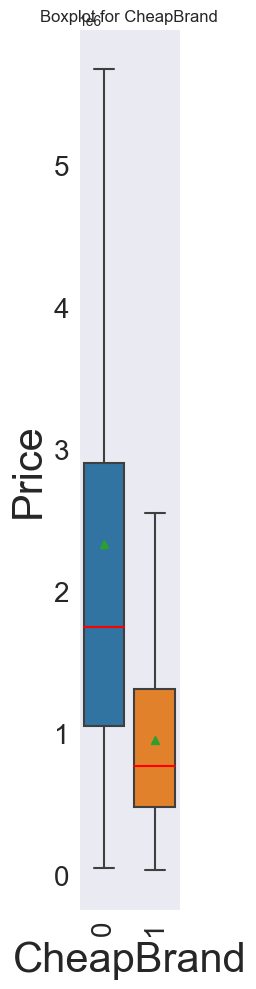

For TEST:


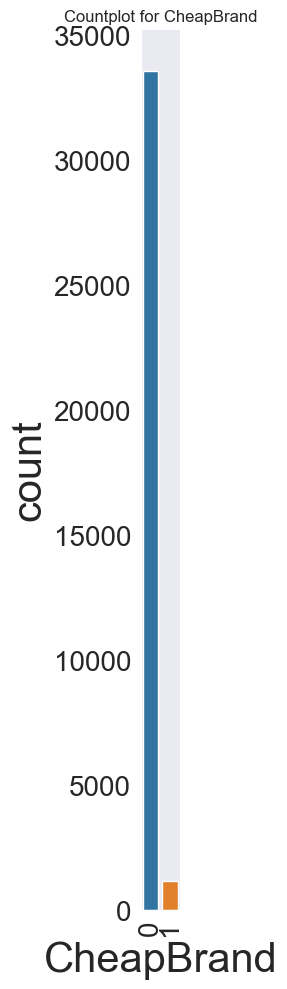

In [331]:
# let's analyze new features
for col in new_bin_cols:
    print_framed(col)
    print('For TRAIN:')
    show_countplot(df_train, col, ordering=True)
    show_boxplot(df_train, col, 'Price', ordering=True, showfliers=False)
    print('For TEST:')
    show_countplot(df_test, col, ordering=True)

Most of our new binary features have small amount of records, but all of them as we planned have significant difference in price boxplots, hope this will help.

Now we finished with EDA and feature engineering and ready to start feature preparation stage.

## Feature preparation and encoding

In [332]:
# # TEMP for faster model testing iterations
# df_train_tmp = df_train.copy()
# df_test_tmp = df_test.copy()

# # noinspection PyUnresolvedReferences
# df_train = df_train_tmp.copy()
# # noinspection PyUnresolvedReferences
# df_test = df_test_tmp.copy()
# dfs = {'train': df_train, 'test': df_test}
#
# cols_to_del = OSet()
# cols_to_del |= {'EngineDisplacement', 'ModelDate'}
# cols_to_del |= {'ProductionDate'}

In [333]:
# add other already unnecessary features to deletion
cols_to_del |= {'SuperGen', 'ParsingUnixtime', 'Description'}
# cols_to_del |= new_bin_cols

# and delete all unnecessary features
for df in dfs.values():
    df.drop(columns=cols_to_del, inplace=True)
    df.info()

print()

# define final cols lists for further processing
num_cols_fin = num_cols - cols_to_del;      print(f'num_cols_fin: {num_cols_fin}')
cat_cols_fin = cat_cols - cols_to_del;      print(f'cat_cols_fin: {cat_cols_fin}')
bin_cols_fin = bin_cols - cols_to_del;      print(f'bin_cols_fin: {bin_cols_fin}')
qual_cols_fin = qual_cols - cols_to_del;    print(f'qual_cols_fin: {qual_cols_fin}')

new_num_cols_fin = new_num_cols - cols_to_del;  print(f'new_num_cols_fin: {new_num_cols_fin}')
new_bin_cols_fin = new_bin_cols - cols_to_del;  print(f'new_bin_cols_fin: {new_bin_cols_fin}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29975 entries, 0 to 29974
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BodyType             29975 non-null  object 
 1   Brand                29975 non-null  object 
 2   Color                29975 non-null  object 
 3   EnginePower          29975 non-null  float64
 4   FuelType             29975 non-null  object 
 5   Mileage              29975 non-null  float64
 6   ModelName            29975 non-null  object 
 7   NumberOfDoors        29975 non-null  int64  
 8   VehicleTransmission  29975 non-null  object 
 9   Vendor               29975 non-null  object 
 10  Owners               29975 non-null  object 
 11  PTS                  29975 non-null  object 
 12  Drive                29975 non-null  object 
 13  Wheel                29975 non-null  object 
 14  Price                29975 non-null  float64
 15  ComplectationRank    29975 non-null 

In [334]:
# let's see on final qualitative (cat+bin) features that are not yet encoded
df_train[qual_cols_fin].nunique().sort_values(ascending=False)

ModelName              416
BodyType                22
Color                   16
Brand                   12
FuelType                 5
NumberOfDoors            4
VehicleTransmission      4
Owners                   3
Drive                    3
Vendor                   2
PTS                      2
Wheel                    2
dtype: int64

In [335]:
# there is no clear natural ordering in our categorical features
# (it could be owners, but eventually decide that it's more like category)
# (it could be number of doors, but we didn't see monotonic change in price from less to greater values - it's more like category too)
# so no ordinal features and no label encoding for them - only for binary features
label_encoding = bin_cols_fin
binary_encoding = {}
# for ModelName feature with high cardinality we've tried different encodings and settled on target LOOE encoding for it
# a bit risky with our unknown submission target distribution, but showed relatively good result
loo_encoding = {'ModelName'}
onehot_encoding = cat_cols_fin - label_encoding - binary_encoding - loo_encoding

print(f'label_encoding: {label_encoding}')
print(f'binary_encoding: {binary_encoding}')
print(f'loo_encoding: {loo_encoding}')
print(f'onehot_encoding: {onehot_encoding}')

label_encoding: OrderedSet(['Vendor', 'PTS', 'Wheel'])
binary_encoding: {}
loo_encoding: {'ModelName'}
onehot_encoding: OrderedSet(['BodyType', 'Brand', 'Color', 'FuelType', 'NumberOfDoors', 'VehicleTransmission', 'Owners', 'Drive'])


In [336]:
df_train['Train'] = 1
df_test['Train'] = 0
df_comb = pd.concat([df_train, df_test], ignore_index=True)

for col in onehot_encoding:
    vals_no_train = set(df_test[col].unique()).difference(set(df_train[col].unique()))

    df_comb = pd.get_dummies(df_comb, prefix=[col], columns=[col])

    # remove from combined data dummy cols that not in train - have no choice with this train..
    df_comb.drop(columns=[col+'_' + str(val) for val in vals_no_train], axis=1, inplace=True)

for col in label_encoding:
    vals_no_train = set(df_test[col].unique()).difference(set(df_train[col].unique()))
    start_idx = 1 if vals_no_train else 0
    labels_mapping = {cat:label for label,cat in enumerate(df_comb[col].unique(), start=start_idx)}
    labels_mapping.update({cat:0 for cat in vals_no_train})

    df_comb[col] = df_comb[col].map(labels_mapping)

for col in binary_encoding:
    vals_no_train = set(df_test[col].unique()).difference(set(df_train[col].unique()))

    df_comb[col] = df_comb[col].apply(lambda v: None if v in vals_no_train else v)
    bin_enc = BinaryEncoder(cols=[col])

    df_comb = bin_enc.fit_transform(df_comb, handle_missing='value')

for col in loo_encoding:
    loo_enc = LeaveOneOutEncoder(cols=[col], return_df=True, handle_unknown='value', handle_missing='value', sigma=0.05, verbose=5)
    loo_enc.fit(df_comb, df_comb['Price'])
    df_comb = loo_enc.transform(df_comb)

In [337]:
# log transform defined features
for col in cols_to_log:
    df_comb[f'{col}_log'] = log_transform(df_comb[col])
    df_comb.drop(columns=[col], axis=1, inplace=True)

# move Price and Train to the end after transformations
cols = list(df_comb.columns)
cols = [e for e in cols if e not in ['Price', 'Train']+list(loo_encoding)] + list(loo_encoding) + ['Price', 'Train']
df_comb = df_comb[cols]

df_comb

Mileage  Vendor  PTS  Wheel  ComplectationRank  DescrWordsCount   Age  \
0       98000.0       0    0      0                  2               26   8.0   
1      239000.0       0    0      0                  1              155  14.0   
2        2000.0       0    0      0                  5              384   2.0   
3      156000.0       0    0      0                  2              207   5.0   
4       50000.0       0    0      0                  6              427   6.0   
...         ...     ...  ...    ...                ...              ...   ...   
64656  115000.0       0    0      0                  0               60   6.0   
64657   98000.0       0    0      0                  0                3   2.0   
64658  360000.0       0    1      0                  0                2  23.0   
64659   90500.0       0    0      0                  2               75   7.0   
64660  240000.0       0    0      0                  0               74  12.0   

       MileagePerYear  Rarity  ExpensiveColor  ...  Owners_2 владельца  \
0        12250.000000       0               1  ...                   0   
1        17071.428571       0               0  ...                   1   
2         1000.000000       0               1  ...                   0   
3        31200.000000       0               1  ...                   1   
4         8333.333333       0               0  ...                   0   
...               ...     ...             ...  ...                 ...   
64656    19166.666667       0               1  ...                   0   
64657    49000.000000       0               1  ...                   0   
64658    15652.173913       0               0  ...                   0   
64659    12928.571429       0               1  ...                   1   
64660    20000.000000       0               1  ...                   0   

       Owners_3 или более  Drive_задний  Drive_передний  Drive_полный  \
0                       0             0               1             0   
1                       0             0               1             0   
2                       0             0               1             0   
3                       0             0               1             0   
4                       0             0               0             1   
...                   ...           ...             ...           ...   
64656                   1             1               0             0   
64657                   0             0               0             1   
64658                   1             1               0             0   
64659                   0             0               0             1   
64660                   1             0               0             1   

       EnginePower_log  YearsPerOwner_log     ModelName      Price  Train  
0             5.198497           2.197225  1.372917e+06  1030000.0      1  
1             5.017280           2.079442  1.372917e+06   400000.0      1  
2             4.709530           1.098612  1.181642e+06  1820000.0      1  
3             4.812184           1.252763  1.181642e+06   730000.0      1  
4             5.198497           1.945910  1.372917e+06  2250000.0      1  
...                ...                ...           ...        ...    ...  
64656         4.919981           1.098612  2.214737e+06        NaN      0  
64657         5.252273           1.098612  2.615764e+06        NaN      0  
64658         5.141664           2.159484  2.615764e+06        NaN      0  
64659         5.220356           1.504077  1.970160e+06        NaN      0  
64660         5.463832           1.609438  4.649204e+06        NaN      0  

[64661 rows x 88 columns]

## Learning

In [183]:
X = df_comb[df_comb['Train'] == 1].drop(columns=['Price', 'Train']).values
y = df_comb[df_comb['Train'] == 1]['Price']
X_sub = df_comb[df_comb['Train'] == 0].drop(columns=['Price', 'Train']).values

print(X.shape)
print(X_sub.shape)
print(y.shape)

(29975, 86)
(34686, 86)
(29975,)


In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)

# if we have some target features we should log transform them too
# and later always use for training with log target X_train_log and X_test_log
n_target_features = len(loo_encoding)
if n_target_features:
    X_train_log = np.hstack((X_train[:,:-len(loo_encoding)], log_transform(X_train[:,-len(loo_encoding):])))
    X_test_log = np.hstack((X_test[:,:-len(loo_encoding)], log_transform(X_test[:,-len(loo_encoding):])))
else:
    X_train_log = X_train
    X_test_log = X_test

y_train_log = log_transform(y_train)
y_test_log = log_transform(y_test)

print(X_train.shape)
print(X_test.shape)

(23980, 86)
(5995, 86)


### Simple model (linear regression)

In [186]:
# X_train_cur = MinMaxScaler().fit_transform(X_train_cur)

lin_reg = LinearRegression()

# also tried Ridge and Lasso regressors,
# but they were no better than LinearRegression model

# reg_pipe = Pipeline([('mms', StandardScaler()),
#                      ('reg', Lasso(max_iter=10_000))])
# params = [{'reg__alpha': np.logspace(-5,1,5)}]
# reg_model = GridSearchCV(reg_pipe, param_grid=params, scoring='neg_mean_absolute_percentage_error' ,cv=3, n_jobs=-1)

lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

lin_reg.fit(X_train_log, y_train_log)
y_pred_log = lin_reg.predict(X_test_log)

y_mape_log = mape(y_pred_log, y_test_log)
y_mape_inv_log = mape(inv_log_transform(y_pred_log), y_test)
y_mape = mape(y_pred, y_test)

print(f'y_mape_log =     {y_mape_log:.2%}')
print(f'y_mape_inv_log = {y_mape_inv_log:.2%}')
print(f'y_mape =         {y_mape:.2%}')

y_mape_log =     1.31%
y_mape_inv_log = 18.83%
y_mape =         45.77%


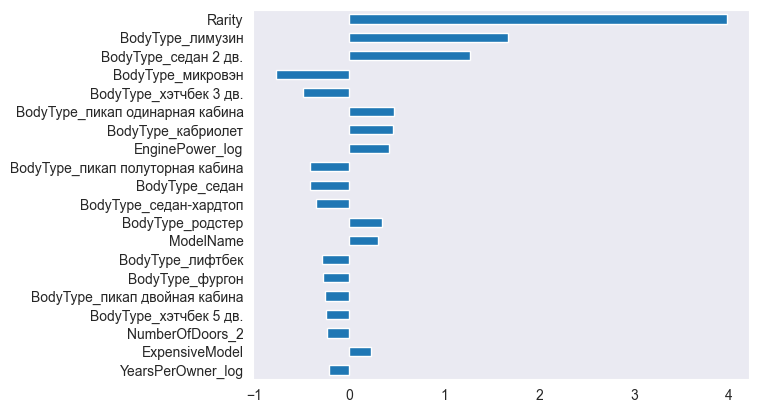

In [165]:
# reg_model.best_params_
# reg_model.best_estimator_['reg'].coef_
lin_reg.coef_
n_coef_show = 20
ser_coef = pd.Series(lin_reg.coef_)
ser_coef.index = list(df_comb.columns)[:-2]
ser_coef.sort_values(key=abs, ascending=False, inplace=True)
ser_coef[:n_coef_show].plot(kind = 'barh')
plt.gca().invert_yaxis()

We see new features Rarity and ExpensiveModel and many BodyType features in top of important features based on LinRegr coefficients.
UPD: After adding target encoded feature ModelName we also see that this feature appeared on 13th place. This indicates that this was useful step for this model.
Get ~20% MAPE (18.8% after adding LOOE feature) for this simple model on our test data as well as on submission test with experimentally defined price corr coefficient = 0.57. Will try to improve it.

### XGBRegressor

In [151]:
# # # === Randomized search ===
# # # various hyper-parameters to tune
# # params = {'objective':['reg:squarederror'],
# #           'learning_rate': [.03], #so called `eta` value
# #           'max_depth': [10, 15, 20],
# #           'alpha': [1],
# #           'colsample_bytree': [0.7],
# #           # 'min_child_weight': [1,2,3,4,5],
# #           # 'silent': [1],
# #           # 'subsample': [0.7],
# #           'n_estimators': [1000],
# #           'nthread': [N_THREADS], #when use hyperthread, xgboost may become slower
# #           }
# #
# # # run randomized search
# # xgb_rnd_search = RandomizedSearchCV(XGBRegressor(random_state=SEED), params,
# #                                     cv = 3,
# #                                     n_iter=5,
# #                                     random_state=SEED,
# #                                     n_jobs = N_THREADS,
# #                                     verbose=2,
# #                                     scoring='neg_mean_absolute_percentage_error')
# #
# # xgb_rnd_search.fit(X_train, y_train)
# # y_pred = xgb_rnd_search.predict(X_test)
# #
# # xgb_rnd_search.fit(X_train, y_train_log)
# # y_pred_log = xgb_rnd_search.predict(X_test)
# #
# # xgb_reg = xgb_rnd_search.best_estimator_
#
#
# # === Specific estimator ===
# xgb_reg = XGBRegressor( objective='reg:squarederror',
#                         colsample_bytree=0.7,
#                         learning_rate=0.03,
#                         max_depth=6,
#                         alpha=1,
#                         n_estimators=1000,
#                         random_state=SEED,
#                         n_jobs=N_THREADS)
#
# xgb_reg.fit(X_train, y_train)
# y_pred = xgb_reg.predict(X_test)
#
# xgb_reg.fit(X_train, y_train_log)
# y_pred_log = xgb_reg.predict(X_test)
#
#
# y_mape_log = mape(y_pred_log, y_test_log)
# y_mape_inv_log = mape(inv_log_transform(y_pred_log), y_test)
# y_mape = mape(y_pred, y_test)
#
# print(f'y_mape_log =     {y_mape_log:.2%}')
# print(f'y_mape_inv_log = {y_mape_inv_log:.2%}')
# print(f'y_mape =         {y_mape:.2%}')

In [152]:
# out = str(xgb_reg.best_params_)
# with open("xgb_regressor_params__mape_7_93.txt", "w") as f:
#     f.write(out)

# xgb_reg.best_estimator_.save_model("xgb_regressor_model__mape_7_93.json")

Based on experiments for several models we concluded that models have better performance on log transform target, so we will use this target transformation for models.

### RandomForest regressor

In [153]:
# rf_reg = RandomForestRegressor(
#                                 n_estimators=1000,
#                                 random_state=SEED,
#                                 n_jobs=N_THREADS)
#
# rf_reg.fit(X_train, y_train_log)
# y_pred_log = rf_reg.predict(X_test)
#
# y_mape_log = mape(y_pred_log, y_test_log)
# y_mape_inv_log = mape(inv_log_transform(y_pred_log), y_test)
#
# print(f'y_mape_log =     {y_mape_log:.2%}')
# print(f'y_mape_inv_log = {y_mape_inv_log:.2%}')

### ExtraTreesRegressor

In [154]:
# et_reg = ExtraTreesRegressor(
#                             n_estimators=100,
#                             # max_depth=10,
#                             random_state=SEED,
#                             n_jobs=N_THREADS)
#
# et_reg.fit(X_train, y_train_log)
# y_pred_log = et_reg.predict(X_test)
#
# y_mape_log = mape(y_pred_log, y_test_log)
# y_mape_inv_log = mape(inv_log_transform(y_pred_log), y_test)
#
# print(f'y_mape_log =     {y_mape_log:.2%}')
# print(f'y_mape_inv_log = {y_mape_inv_log:.2%}')

### CatBoost

y_mape_log =     0.45%
y_mape_inv_log = 6.49%


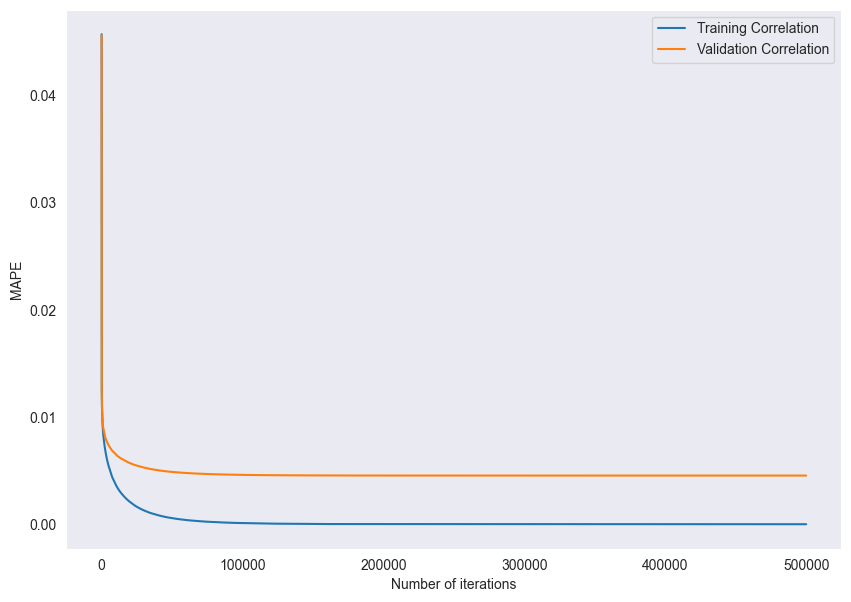

In [191]:
# cb_reg = CatBoostRegressor(
#                             iterations=500_000,
#                             max_depth=7,
#                             learning_rate= 0.03,
#                             random_seed = SEED,
#                             eval_metric='MAPE',
#                             verbose = 0,
#                             thread_count=N_THREADS
#                          )
#
# cb_reg.fit(X_train_log, y_train_log, eval_set=Pool(data=X_test_log, label=y_test_log))
# y_pred_log = cb_reg.predict(X_test_log)
#
# y_mape_log = mape(y_pred_log, y_test_log)
# y_mape_inv_log = mape(inv_log_transform(y_pred_log), y_test)
#
# print(f'y_mape_log =     {y_mape_log:.2%}')
# print(f'y_mape_inv_log = {y_mape_inv_log:.2%}')
#
#
# plt.figure(figsize=(10,7))
# plt.plot(cb_reg.evals_result_["learn"]["MAPE"], label="Training Correlation")
# plt.plot(cb_reg.evals_result_["validation"]["MAPE"], label="Validation Correlation")
# plt.xlabel("Number of iterations")
# plt.ylabel("MAPE")
# plt.legend()


In [156]:
# we can see that validation curve decrease slower than training and eventually both curves become virtually horizontal,
# there is no signs of overfitting for this number of iterations, but there is no sense to train more - "saturation" come at ~200_000 iterarations.

### Stacking

In [157]:
# # xgb_reg = XGBRegressor()
# # xgb_reg.load_model('Models/xgb_regressor/xgb_regressor_1/xgb_regressor_model__mape_7_93.json')
#
# estimators = [
#                 ('et_reg', et_reg),
#                 ('cb_reg', cb_reg)
# ]
#
# stack_reg = StackingRegressor(
#                             estimators=estimators,
#                             final_estimator=LinearRegression(),
#                             n_jobs=N_THREADS
# )
#
# stack_reg.fit(X_train, y_train_log)
# y_pred_log = stack_reg.predict(X_test)
#
# y_mape_log = mape(y_pred_log, y_test_log)
# y_mape_inv_log = mape(inv_log_transform(y_pred_log), y_test)
#
# print(f'y_mape_log =     {y_mape_log:.2%}')
# print(f'y_mape_inv_log = {y_mape_inv_log:.2%}')

### Submission

In [158]:
# experimentally defined price corr coefficient = 0.57
coef_grid = [0.57] #np.arange(0.56, 0.66, 0.01)

for n_iter in np.arange(1000, 4000+1, 1000):
    for depth in [6]:
        reg_model = CatBoostRegressor(
                                        iterations=n_iter,
                                        max_depth=depth,
                                        learning_rate= 0.03,
                                        random_seed = SEED,
                                        eval_metric='MAPE',
                                        thread_count=N_THREADS,
                                        verbose=0
        )

        name_add = f'all_onehot__iter_{n_iter}__depth_{depth}'

        # train model on all train and infer predictions for X_sub
        gs_sub = gridsearch_for_submission(reg_model, 'fit', 'predict', X, y, X_sub, coef_grid,
                                           n_target_features, log_transform, inv_log_transform)

        # save submission gridsearch results
        save_time = time.strftime("%H_%M__%d_%m_%Y")
        sub_dir = f'{SUB_DIR}/sub__model_{str(reg_model.__class__).split(".")[-1][:-2]}_{name_add}__{save_time}'

        Path(sub_dir).mkdir(parents=True, exist_ok=True)

        for coef, y_sub_res in zip(coef_grid, gs_sub):
            df_sub = pd.DataFrame()
            df_sub['sell_id'] = df_test_orig['sell_id']
            df_sub['price'] = y_sub_res

            # save to file
            path = f'{sub_dir}/sub__model_{str(reg_model.__class__).split(".")[-1][:-2]}_{name_add}__coef_{coef:.2f}__{save_time}.csv'
            df_sub.to_csv(path, index=False)

        print(f'Submissions ({len(coef_grid)} file(s)) were saved to {sub_dir}.')

Submissions (1 file(s)) were saved to Data/Submission/sub__model_CatBoostRegressor_all_onehot__iter_1000__depth_6__11_39__17_02_2022.
Submissions (1 file(s)) were saved to Data/Submission/sub__model_CatBoostRegressor_all_onehot__iter_2000__depth_6__11_39__17_02_2022.
Submissions (1 file(s)) were saved to Data/Submission/sub__model_CatBoostRegressor_all_onehot__iter_3000__depth_6__11_40__17_02_2022.
Submissions (1 file(s)) were saved to Data/Submission/sub__model_CatBoostRegressor_all_onehot__iter_4000__depth_6__11_40__17_02_2022.


Conclusions for learning stage:

Generally those models which showed good performance (~6 %) on our test set showed rather low score on submission. So we can conclude that our parsed data is not similar (in some statistic sense) to project submission test data.
As expected there was some optimal max tree depths for used algorithms (depth=6 for best performed algorithm). For greater depth our test score improved but submission score get worse as a sign of known dependency: more tree depth - less generalisation ability.
We tried different qualitative features encodings. Best results for our test set was achieved for all category features encoded as one hot and ModelName - with binary encoding (ExtraTrees with ~6 % MAPE), BUT for submission best results appeared to be with all feature one hot encoding (CatBoost with 16.2 % MAPE).
Stacking algorithm with CatBoost and ExtraTrees performed worse than ExtraTrees alone but better than CatBoost on our test set and get only 17.99% MAPE on submission. So, stacking is not always better than its level 0 models alone.

Steps for improvement:
- get more data for training from public resources (and perhaps more relevant to submission test)
- add new features, e.g.  most expensive model within body type and/or brand (these features have rather high value of linear regression coefficients that indicates their potential importance)
- use more powerful algorithms or some AutoML toolkits
- use different price correction coefficients for different types of cars (price segments, body types, brands etc.).

# Trials
(section for quick experiments)